# Example Cross Validation and Linear Regression Framework

Testing cross-validation frameworks, feature engineering, feature selection, and SciKitLearn machine learning system with linear regression models.

Also doing an initial check on the differences between CIMMYT environmental data and Earth Engine remote sensing data for a linear model.

## Setting up the Environment

NOTE: This notebook may use more RAM than your session has available. Switch the Runtime to a TPU on Colab to access 35Gb of RAM to avoid crashing.

In [1]:
# Install Packages

# Import Packages
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model, preprocessing

DISPLAY_PRECISION = 4
pd.set_option("display.precision", DISPLAY_PRECISION)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Mount User's Drive
# Copy and paste the passkey from your Google account
# You should use the same account that is operating the Colab file
# Ignore if you aren't accessing this file in Google Colab

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
parent_dir_name = 'GxE with GEE'

for dirpath, subdirs, files in os.walk('/content'):
  if parent_dir_name in subdirs:
    parent_path = dirpath + "/" + parent_dir_name

parent_path

'/content/drive/My Drive/Research/GxE with GEE'

In [4]:
# Set Data Path
## Change the destination to your Drive directory containing the folder 'raw_data.zip'
data_path_end = '/Colab Workspace/Data'
os.chdir(parent_path + data_path_end)

# Print the current working directory
os.getcwd()

'/content/drive/My Drive/Research/GxE with GEE/Colab Workspace/Data'

In [0]:
# os.chdir('C:/Users/theaa/Downloads')

## Import and Process CIMMYT Data

In [0]:
data = pd.read_pickle('proc_data.pkl')
data.columns=data.columns.str.upper()
data.head()

,TRIAL NAME_X,OCC_X,LOC_NO,COUNTRY,LOC_DESC_X,CYCLE_X,CID_X,SID_X,GEN_NAME,GRAIN_YIELD,EMS,SE,UNIT,TRIAL NAME_Y,OCC_Y,COUNTRY_X,LOC_DESC_Y,CYCLE_Y,COOPERATOR_NOTE_TAKER,HARVEST_FINISHING_DATE,HARVEST_STARTING_DATE,IRRIGATED,LENGTH_OF_ROWS_HARVESTED,LENGTH_OF_ROWS_SOWN,NO_OF_ROWS_HARVESTED,NO_OF_ROWS_SOWN,OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N,SOIL_ALUMINIUM_TOXICITY,SOWING_DATE,SPACE_BTN_ROWS_SOWN,YIELD_FACTOR,COUNTRY_Y,LOC. DESCRIPTION,INSTITUTE NAME,COOPERATOR,ALTITUDE,LAT_COORD,LONG_COORD,GENO_ID,CID_Y,...,SOIL_CLASIFICATION,SOIL_DEPTH_OF_ROOT_ZONE,SOIL_PERCENT_ORGANIC_MATTER,SOIL_PH,SOIL_PH_ACTUAL_VALUE,SOIL_ROOT_BARRIER,SOIL_SURFACE_TEXTURE,SPECIFY_OTHER_UNIT_FERTILIZER_FROM_KG/HA,SPIKE_DISEASE_DEVELOPMENT,TOTAL_PRECIPIT_IN_12_MONTHS,USE_OF_FIELD_IN_YEAR_PRECEDING_TRIAL_SOWING,USE_OF_FIELD_SPECIFY_CROP,WEATHER_COMMENTS,WEED_PROBLEM,OTHER_CHEMICAL(S),FERTILIZER_%K2O_2,FERTILIZER_%K2O_3,FERTILIZER_%P2O5_3,OTHER_CHEMICAL_PRODUCT(S),OTHER_ELEMENT(S)_3,SOIL_OTHER_SURFACE_TEXTURE,CHEMICAL_CONTROL_OF_WEEDS,GERMINATION_%,GERMINATION_OLD_P/G,HAND_WEEDING,MOISTURE_AVAILABLE_IN_FULL_ROOT_ZONE_AT_SOWING_OLD,NO_OF_RAINS_DURING_CYCLE_OLD,SOWING_OLD,SOIL_DEPTH_BARRIER,HARVEST_FINISH_MISSING,TRIAL_TYPE,HARVEST_FINISHING_YEAR,HARVEST_FINISHING_MONTH,HARVEST_FINISHING_DAY,LAT_LONG_DAY_MONTH_YEAR,GID,CID,SID,DIFF_CID,DIFF_SID
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4ESWYT_19105_254741_5,4ESWYT,1,19105,EGYPT,SHANDAWEEL,82-83,254741,5,R37/GHL121//KAL/BB,6.250,0,0,t/ha,4ESWYT,1,EGYPT,SHANDAWEEL,82-83,"MOUSA GERGIS, MOUSTAFA AZAB, FARGHAL HEFNAWY",1983-05-22,NaT,NO,3.5,3.5,4,4,NO,NO,1982-11-21,20,3.5714,EGYPT,SHANDAWEEL,Agric. Res. Center,Abdel/A. Maboud/Shafi Ali,57.0,26.36,31.40,254741_5,254741.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,ESWYT,1983,5,22,26.36_31.4_22_5_1983,2099196,254741,5,False,False
4ESWYT_19207_254741_5,4ESWYT,2,19207,LIBYA,KUFRA PRODUCTION PROJECT,82-83,254741,5,R37/GHL121//KAL/BB,5.944,0,0,t/ha,4ESWYT,2,LIBYA,KUFRA PRODUCTION PROJECT,82-83,DIRECTOR RESEARCH K.P.P.,1983-04-30,NaT,NO,2.5,2.5,4,4,NO,NO,1982-11-10,30,3.3333,LIBYA,KUFRA PRODUCTION PROJECT,Kufra Production,Moftah S. Elhata,415.0,25.00,23.00,254741_5,254741.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,ESWYT,1983,4,30,25.0_23.0_30_4_1983,2099196,254741,5,False,False
4ESWYT_19402_254741_5,4ESWYT,3,19402,TUNISIA,BEJA,82-83,254741,5,R37/GHL121//KAL/BB,5.089,0,0,t/ha,4ESWYT,3,TUNISIA,BEJA,82-83,"M. DEGHAN, A. R. MAAMOURI",1983-06-08,NaT,NO,2.5,2.5,4,4,NO,NO,1982-12-02,25,4,TUNISIA,BEJA,INRAT,Ali Maamouri,150.0,36.44,9.08,254741_5,254741.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,ESWYT,1983,6,8,36.44_9.08_8_6_1983,2099196,254741,5,False,False
4ESWYT_11101_254741_5,4ESWYT,4,11101,ZIMBABWE,HARARE,82-83,254741,5,R37/GHL121//KAL/BB,7.983,0,0,t/ha,4ESWYT,4,ZIMBABWE,HARARE,82-83,N. MASHIRINGWANI,1983-10-27,NaT,NO,2,2,4,4,NO,NO,1983-05-12,25,5,ZIMBABWE,HARARE,Crop Breeding Inst.,Bruce Mutari,1448.0,-17.41,30.25,254741_5,254741.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,ESWYT,1983,10,27,-17.41_30.25_27_10_1983,2099196,254741,5,False,False
4ESWYT_22001_254741_5,4ESWYT,5,22001,BANGLADESH,JOYDEBPUR,82-83,254741,5,R37/GHL121//KAL/BB,4.452,0,0,t/ha,4ESWYT,5,BANGLADESH,JOYDEBPUR,82-83,S. M. AHMED AND A.B.S. HOSSAIN,1983-03-15,NaT,NO,2.5,2.5,4,4,NO,NO,1982-11-19,20,5,BANGLADESH,JOYDEBPUR,CIMMYT,. Project Advisor,8.0,23.59,90.25,254741_5,254741.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,ESWYT,1983,3,15,23.59_90.25_15_3_1983,2099196,254741,5,False,False


In [0]:
init_len = data.shape[0]
init_len

169529

In [0]:
# Ensure target variable is numeric and drop observations missing for key variables
data['GRAIN_YIELD'] = pd.to_numeric(data['GRAIN_YIELD'],errors='coerce')
data.drop_duplicates(subset=['UNIQUE_ID'],inplace=True)
data.dropna(subset=['GRAIN_YIELD'],inplace=True)
data.dropna(subset=['HARVEST_FINISHING_DATE'],inplace=True)
data.dropna(subset=['GENO_ID'],inplace=True)

In [0]:
# Yield Vector (nx1)
Y = pd.DataFrame(data['GRAIN_YIELD'],index=data.index)
# Varieties (nx1)
VAR = pd.DataFrame(pd.to_numeric(data['GID'], errors='coerce'),index=data.index)
# Environment locations
ENV = pd.DataFrame(data['LAT_LONG_DAY_MONTH_YEAR'],index=data.index)

Y_VAR_ENV = pd.concat([Y,VAR,ENV],axis=1)
Y_VAR_ENV.to_csv('Y_VAR_ENV.csv')
Y_VAR_ENV.to_pickle('Y_VAR_ENV.pkl')
print(Y.shape)
print(VAR.shape)
print(ENV.shape)
print(Y_VAR_ENV.shape)

(169529, 1)
(169529, 1)
(169529, 1)
(169529, 3)


In [0]:
# Data from the Imputed environmental covariates done in the LMM replication

W = pd.read_pickle('W_imp.pkl')

W.head()

,ALTITUDE,PPN_10TH_MO_BEFORE_HARVESTED,PPN_11TH_MO_BEFORE_HARVESTED,PPN_1ST_MO_BEFORE_HARVESTED,PPN_2ND_MO_BEFORE_HARVESTED,PPN_3RD_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED,PPN_9TH_MO_BEFORE_HARVESTED,PPN_MONTH_OF_HARVESTED,PRECIPITATION_FROM_SOWING_TO_MATURITY,TOTAL_PRECIPIT_IN_12_MONTHS,LENGTH_OF_ROWS_SOWN,SPACE_BTN_ROWS_SOWN,NO_OF_ROWS_SOWN,LENGTH_OF_ROWS_HARVESTED,NO_OF_ROWS_HARVESTED,IRRIGATED_NO,IRRIGATED_YES,SOIL_ALUMINIUM_TOXICITY_NO,SOIL_ALUMINIUM_TOXICITY_YES,OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N_NO,OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N_YES,BIRD_DAMAGE_MODERATE,BIRD_DAMAGE_NONE,BIRD_DAMAGE_SEVERE,BIRD_DAMAGE_SLIGHT,BIRD_DAMAGE_TRACES,CROP_STAND_OR_DENSITY_DENSE,CROP_STAND_OR_DENSITY_NORMAL,CROP_STAND_OR_DENSITY_SPARSE,WEED_PROBLEM_MODERATE,WEED_PROBLEM_NONE,WEED_PROBLEM_SEVERE,WEED_PROBLEM_SLIGHT,WEED_PROBLEM_TRACES,INSECT_DAMAGE_MODERATE,INSECT_DAMAGE_NONE,INSECT_DAMAGE_SEVERE,INSECT_DAMAGE_SLIGHT,INSECT_DAMAGE_TRACES,FERTILIZER_APPLIED_NO,FERTILIZER_APPLIED_YES,FOLIAR_DISEASE_DEVELOPMENT_MODERATE,FOLIAR_DISEASE_DEVELOPMENT_NONE,FOLIAR_DISEASE_DEVELOPMENT_SEVERE,FOLIAR_DISEASE_DEVELOPMENT_SLIGHT,FOLIAR_DISEASE_DEVELOPMENT_TRACES,LODGING_MODERATE,LODGING_NONE,LODGING_SEVERE,LODGING_SLIGHT,LODGING_TRACES,ROOT_DISEASE_DEVELOPMENT_MODERATE,ROOT_DISEASE_DEVELOPMENT_NONE,ROOT_DISEASE_DEVELOPMENT_SEVERE,ROOT_DISEASE_DEVELOPMENT_SLIGHT,ROOT_DISEASE_DEVELOPMENT_TRACES,HAIL_DAMAGE_MODERATE,HAIL_DAMAGE_NONE,HAIL_DAMAGE_SEVERE,HAIL_DAMAGE_SLIGHT,HAIL_DAMAGE_TRACES,FROST_DAMAGE_SPIKE_MODERATE,FROST_DAMAGE_SPIKE_NONE,FROST_DAMAGE_SPIKE_SEVERE,FROST_DAMAGE_SPIKE_SLIGHT,FROST_DAMAGE_SPIKE_TRACES
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4ESWYT_19105_254741_5,57.0,29.930,21.359,28.893,31.468,20.8195,22.456,18.264,16.9880,26.3400,56.991,38.320,40.879,222.4300,0.0,3.5,20.0,4.0,3.5,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4ESWYT_19207_254741_5,415.0,44.911,48.096,20.998,70.347,21.3820,18.201,49.838,29.4454,25.2614,93.085,95.362,54.998,159.6100,0.0,2.5,30.0,4.0,2.5,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4ESWYT_19402_254741_5,150.0,39.141,21.406,14.299,69.066,16.2220,18.483,13.459,16.0520,25.6374,53.807,34.708,38.123,137.9644,0.0,2.5,25.0,4.0,2.5,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4ESWYT_11101_254741_5,1448.0,47.314,32.253,40.856,45.474,97.1960,36.445,42.274,15.8552,25.2919,43.952,137.308,115.840,301.5471,0.0,2.0,25.0,4.0,2.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4ESWYT_22001_254741_5,8.0,27.798,20.835,28.472,26.006,19.6375,28.621,22.544,17.9850,22.3520,54.886,37.881,40.676,224.6500,0.0,2.5,20.0,4.0,2.5,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
W.shape

(169529, 71)

In [0]:
# Drop repeated categorical variables
neg_columns = W.filter(like='_NO').columns
neg_columns

Index(['IRRIGATED_NO', 'SOIL_ALUMINIUM_TOXICITY_NO',
       'OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N_NO', 'BIRD_DAMAGE_NONE',
       'CROP_STAND_OR_DENSITY_NORMAL', 'WEED_PROBLEM_NONE',
       'INSECT_DAMAGE_NONE', 'FERTILIZER_APPLIED_NO',
       'FOLIAR_DISEASE_DEVELOPMENT_NONE', 'LODGING_NONE',
       'ROOT_DISEASE_DEVELOPMENT_NONE', 'HAIL_DAMAGE_NONE',
       'FROST_DAMAGE_SPIKE_NONE'],
      dtype='object')

In [0]:
W.drop(neg_columns,axis=1,inplace=True)
W.head()

,ALTITUDE,PPN_10TH_MO_BEFORE_HARVESTED,PPN_11TH_MO_BEFORE_HARVESTED,PPN_1ST_MO_BEFORE_HARVESTED,PPN_2ND_MO_BEFORE_HARVESTED,PPN_3RD_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED,PPN_9TH_MO_BEFORE_HARVESTED,PPN_MONTH_OF_HARVESTED,PRECIPITATION_FROM_SOWING_TO_MATURITY,TOTAL_PRECIPIT_IN_12_MONTHS,LENGTH_OF_ROWS_SOWN,SPACE_BTN_ROWS_SOWN,NO_OF_ROWS_SOWN,LENGTH_OF_ROWS_HARVESTED,NO_OF_ROWS_HARVESTED,IRRIGATED_YES,SOIL_ALUMINIUM_TOXICITY_YES,OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N_YES,BIRD_DAMAGE_MODERATE,BIRD_DAMAGE_SEVERE,BIRD_DAMAGE_SLIGHT,BIRD_DAMAGE_TRACES,CROP_STAND_OR_DENSITY_DENSE,CROP_STAND_OR_DENSITY_SPARSE,WEED_PROBLEM_MODERATE,WEED_PROBLEM_SEVERE,WEED_PROBLEM_SLIGHT,WEED_PROBLEM_TRACES,INSECT_DAMAGE_MODERATE,INSECT_DAMAGE_SEVERE,INSECT_DAMAGE_SLIGHT,INSECT_DAMAGE_TRACES,FERTILIZER_APPLIED_YES,FOLIAR_DISEASE_DEVELOPMENT_MODERATE,FOLIAR_DISEASE_DEVELOPMENT_SEVERE,FOLIAR_DISEASE_DEVELOPMENT_SLIGHT,FOLIAR_DISEASE_DEVELOPMENT_TRACES,LODGING_MODERATE,LODGING_SEVERE,LODGING_SLIGHT,LODGING_TRACES,ROOT_DISEASE_DEVELOPMENT_MODERATE,ROOT_DISEASE_DEVELOPMENT_SEVERE,ROOT_DISEASE_DEVELOPMENT_SLIGHT,ROOT_DISEASE_DEVELOPMENT_TRACES,HAIL_DAMAGE_MODERATE,HAIL_DAMAGE_SEVERE,HAIL_DAMAGE_SLIGHT,HAIL_DAMAGE_TRACES,FROST_DAMAGE_SPIKE_MODERATE,FROST_DAMAGE_SPIKE_SEVERE,FROST_DAMAGE_SPIKE_SLIGHT,FROST_DAMAGE_SPIKE_TRACES
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4ESWYT_19105_254741_5,57.0,29.930,21.359,28.893,31.468,20.8195,22.456,18.264,16.9880,26.3400,56.991,38.320,40.879,222.4300,0.0,3.5,20.0,4.0,3.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4ESWYT_19207_254741_5,415.0,44.911,48.096,20.998,70.347,21.3820,18.201,49.838,29.4454,25.2614,93.085,95.362,54.998,159.6100,0.0,2.5,30.0,4.0,2.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4ESWYT_19402_254741_5,150.0,39.141,21.406,14.299,69.066,16.2220,18.483,13.459,16.0520,25.6374,53.807,34.708,38.123,137.9644,0.0,2.5,25.0,4.0,2.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4ESWYT_11101_254741_5,1448.0,47.314,32.253,40.856,45.474,97.1960,36.445,42.274,15.8552,25.2919,43.952,137.308,115.840,301.5471,0.0,2.0,25.0,4.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4ESWYT_22001_254741_5,8.0,27.798,20.835,28.472,26.006,19.6375,28.621,22.544,17.9850,22.3520,54.886,37.881,40.676,224.6500,0.0,2.5,20.0,4.0,2.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
W.to_pickle('W_proc.pkl')

print(Y.shape) # Should only have one column of target values
print(W.shape) # Should have as many rows as Y

(169529, 1)
(169529, 58)


### Visualization of CIMMYT Environmental Variable Correlations

In [0]:
def correlation_matrix(y, X, is_plot=False):
  # Calculate and plot the correlation symmetrical matrix
  # Return:
  # yX - concatenated data
  # yX_corr - correlation matrix, pearson correlation of values from -1 to +1
  # yX_abs_corr - correlation matrix, absolute values
  
  yX = pd.concat([y, X], axis=1)

  print("Function correlation_matrix: X.shape, y.shape, yX.shape:", X.shape, y.shape, yX.shape)
  print()

  # Get feature correlations and transform to dataframe
  yX_corr = yX.corr(method='pearson')

  # Convert to abolute values
  yX_abs_corr = np.abs(yX_corr) 
  
  if is_plot:
    plt.figure(figsize=(10, 10))
    plt.imshow(yX_abs_corr, cmap='RdYlGn', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(yX_abs_corr)), yX_abs_corr.columns, rotation='vertical')
    plt.yticks(range(len(yX_abs_corr)), yX_abs_corr.columns);
    plt.suptitle('Pearson Correlation Heat Map (absolute values)', fontsize=15, fontweight='bold')
    plt.show()
  
  return yX, yX_corr, yX_abs_corr


In [0]:

# Build the correlation matrix for the train data
yX, yX_corr, yX_abs_corr = correlation_matrix(Y['GRAIN_YIELD'], W, is_plot=True)  

In [0]:
env_cov_list = ['ALTITUDE',
'PPN_10TH_MO_BEFORE_HARVESTED',
'PPN_11TH_MO_BEFORE_HARVESTED',
'PPN_1ST_MO_BEFORE_HARVESTED',
'PPN_2ND_MO_BEFORE_HARVESTED',
'PPN_3RD_MO_BEFORE_HARVESTED',
'PPN_4TH_MO_BEFORE_HARVESTED',
'PPN_5TH_MO_BEFORE_HARVESTED',
'PPN_6TH_MO_BEFORE_HARVESTED',
'PPN_7TH_MO_BEFORE_HARVESTED',
'PPN_8TH_MO_BEFORE_HARVESTED',
'PPN_9TH_MO_BEFORE_HARVESTED',
'PPN_MONTH_OF_HARVESTED',
'PRECIPITATION_FROM_SOWING_TO_MATURITY',
'TOTAL_PRECIPIT_IN_12_MONTHS',
'IRRIGATED',
'SOIL_ALUMINIUM_TOXICITY',
'OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N',
'LENGTH_OF_ROWS_SOWN',
'SPACE_BTN_ROWS_SOWN',
'NO_OF_ROWS_SOWN',
'LENGTH_OF_ROWS_HARVESTED',
'NO_OF_ROWS_HARVESTED',
'CROP_STAND_OR_DENSITY',
'WEED_PROBLEM', 
'BIRD_DAMAGE', 
'INSECT_DAMAGE',
'FERTILIZER_APPLIED', 
'FOLIAR_DISEASE_DEVELOPMENT',
'LODGING',
'ROOT_DISEASE_DEVELOPMENT', 
'HAIL_DAMAGE', 
'FROST_DAMAGE_SPIKE'
]

W_factors = ['IRRIGATED',
             'SOIL_ALUMINIUM_TOXICITY',
             'OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N',
             'BIRD_DAMAGE',
             'CROP_STAND_OR_DENSITY',
             'WEED_PROBLEM',
             'INSECT_DAMAGE',
             'FERTILIZER_APPLIED',
             'FOLIAR_DISEASE_DEVELOPMENT',
              'LODGING',
              'ROOT_DISEASE_DEVELOPMENT', 
              'HAIL_DAMAGE', 
              'FROST_DAMAGE_SPIKE'
              ]

W_numeric = [x for x in env_cov_list if x not in W_factors]
W_numeric

In [0]:
W_factor_dummies = [x for x in W.columns if x not in W_numeric]
W_factor_dummies

In [0]:
W_column_names = W.columns

In [0]:
W_numeric_interesting = ['GRAIN_YIELD',
                         'ALTITUDE',
                         'PPN_MONTH_OF_HARVESTED',
                        'TOTAL_PRECIPIT_IN_12_MONTHS',
                        'LENGTH_OF_ROWS_SOWN',
                        'SPACE_BTN_ROWS_SOWN',
                        'NO_OF_ROWS_SOWN']

In [0]:
train_data_sample = pd.concat([Y['GRAIN_YIELD'],W], axis=1).sample(5000)

In [0]:
g = sns.PairGrid(train_data_sample[W_numeric_interesting])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

In [0]:
# Visualize multiplot of scatterplots against grain yield
# https://seaborn.pydata.org/tutorial/axis_grids.html

g = sns.PairGrid(train_data_sample[W_numeric_interesting])
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False);

In [0]:
# Visualization of factor variables
# https://seaborn.pydata.org/tutorial/categorical.html

sns.catplot(x="IRRIGATED.YES", y="grain_yield", kind="box", data=train_data_sample, axis=1));

In [0]:
# https://cmdlinetips.com/2019/03/how-to-make-grouped-boxplots-in-python-with-seaborn/
sns.stripplot(y='grain_yield', x='IRRIGATED.YES', 
                   data=train_data_sample, 
                   jitter=True,
                   dodge=True,
                   marker='o', 
                   alpha=0.5)
#                   hue='year')

## Import GEE Data and Check for Missing Values

In [0]:
gee_data = pd.read_pickle('GEE_Data/earth_engine_data.pkl')
gee_data.head()

,"(END_DATE, 0)","(END_DATE, 1)","(END_DATE, 2)","(END_DATE, 3)","(END_DATE, 4)","(END_DATE, 5)","(END_DATE, 6)","(END_DATE, 7)","(END_DATE, 8)","(END_DATE, 9)","(END_DATE, 10)","(END_DATE, 11)","(END_DATE, 12)","(LAT_COORD, 0)","(LAT_COORD, 1)","(LAT_COORD, 2)","(LAT_COORD, 3)","(LAT_COORD, 4)","(LAT_COORD, 5)","(LAT_COORD, 6)","(LAT_COORD, 7)","(LAT_COORD, 8)","(LAT_COORD, 9)","(LAT_COORD, 10)","(LAT_COORD, 11)","(LAT_COORD, 12)","(LONG_COORD, 0)","(LONG_COORD, 1)","(LONG_COORD, 2)","(LONG_COORD, 3)","(LONG_COORD, 4)","(LONG_COORD, 5)","(LONG_COORD, 6)","(LONG_COORD, 7)","(LONG_COORD, 8)","(LONG_COORD, 9)","(LONG_COORD, 10)","(LONG_COORD, 11)","(LONG_COORD, 12)","(START_DATE, 0)",...,"(vap, 0)","(vap, 1)","(vap, 2)","(vap, 3)","(vap, 4)","(vap, 5)","(vap, 6)","(vap, 7)","(vap, 8)","(vap, 9)","(vap, 10)","(vap, 11)","(vap, 12)","(tmmn, 0)","(tmmn, 1)","(tmmn, 2)","(tmmn, 3)","(tmmn, 4)","(tmmn, 5)","(tmmn, 6)","(tmmn, 7)","(tmmn, 8)","(tmmn, 9)","(tmmn, 10)","(tmmn, 11)","(tmmn, 12)","(tmmx, 0)","(tmmx, 1)","(tmmx, 2)","(tmmx, 3)","(tmmx, 4)","(tmmx, 5)","(tmmx, 6)","(tmmx, 7)","(tmmx, 8)","(tmmx, 9)","(tmmx, 10)","(tmmx, 11)","(tmmx, 12)","(av_altitude, 0)"
LAT_LONG_D,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-0.16_29.1_10_9_1997,1997-09-10,1997-08-11,1997-07-12,1997-06-12,1997-05-13,1997-04-13,1997-03-14,1997-02-12,1997-01-13,1996-12-14,1996-11-14,1996-10-15,1996-09-15,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,1997-08-11,...,1700,1655,1600,1667,1640,1654,1589,1358,1513,1621,1678,1686,1677,126,104,109,110,129,121,117,118,119,123,104,119,109,247,240,235,234,238,237,253,245,252,251,235,230,241,1959
-0.16_29.1_23_8_1994,1994-08-23,1994-07-24,1994-06-24,1994-05-25,1994-04-25,1994-03-26,1994-02-24,1994-01-25,1993-12-26,1993-11-26,1993-10-27,1993-09-27,1993-08-28,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,1994-07-24,...,1682,1409,1671,1723,1670,1617,1496,1578,1698,2164,1514,1583,1941,104,95,109,119,106,103,106,102,118,133,99,105,123,234,219,230,237,240,235,233,233,234,265,230,229,244,1959
-0.16_29.1_7_8_1996,1996-08-07,1996-07-08,1996-06-08,1996-05-09,1996-04-09,1996-03-10,1996-02-09,1996-01-10,1995-12-11,1995-11-11,1995-10-12,1995-09-12,1995-08-13,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,29.1,1996-07-08,...,1642,1683,1637,1634,1704,1508,1572,1619,1636,1929,1706,1748,1941,104,107,109,105,114,106,116,112,115,119,118,116,131,240,232,236,245,243,239,255,250,244,254,243,238,237,1959
-0.22_-78.32_12_8_2011,2011-08-12,2011-07-13,2011-06-13,2011-05-14,2011-04-14,2011-03-15,2011-02-13,2011-01-14,2010-12-15,2010-11-15,2010-10-16,2010-09-16,2010-08-17,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,2011-07-13,...,1118,1061,1209,1219,1138,1133,1124,1131,1095,1138,1185,1139,1094,70,72,79,79,76,73,71,66,66,70,71,67,73,206,192,192,191,185,177,179,189,180,179,191,192,197,2756
-0.22_-78.32_16_7_2010,2010-07-16,2010-06-16,2010-05-17,2010-04-17,2010-03-18,2010-02-16,2010-01-17,2009-12-18,2009-11-18,2009-10-19,2009-09-19,2009-08-20,2009-07-21,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,-78.32,2010-06-16,...,1074,1137,1264,1312,1315,1297,1283,1292,1261,1256,1207,1223,1202,71,73,83,90,84,72,71,72,72,71,76,80,71,193,187,193,184,192,203,208,203,197,204,208,210,191,2756


In [0]:
index_vars = ['HARVEST_FINISHING_DATE','LAT_LONG_DAY_MONTH_YEAR']
data_index = data[index_vars]
data_index.head()

,HARVEST_FINISHING_DATE,LAT_LONG_DAY_MONTH_YEAR
Unique_ID,,
4ESWYT_19105_254741_5,1983-05-22,26.36_31.4_22_5_1983
4ESWYT_19207_254741_5,1983-04-30,25.0_23.0_30_4_1983
4ESWYT_19402_254741_5,1983-06-08,36.44_9.08_8_6_1983
4ESWYT_11101_254741_5,1983-10-27,-17.41_30.25_27_10_1983
4ESWYT_22001_254741_5,1983-03-15,23.59_90.25_15_3_1983


In [0]:
gee_merge = data_index.merge(gee_data,how='left',left_on='LAT_LONG_DAY_MONTH_YEAR',right_index=True)
gee_merge.head()

,HARVEST_FINISHING_DATE,LAT_LONG_DAY_MONTH_YEAR,"(END_DATE, 0)","(END_DATE, 1)","(END_DATE, 2)","(END_DATE, 3)","(END_DATE, 4)","(END_DATE, 5)","(END_DATE, 6)","(END_DATE, 7)","(END_DATE, 8)","(END_DATE, 9)","(END_DATE, 10)","(END_DATE, 11)","(END_DATE, 12)","(LAT_COORD, 0)","(LAT_COORD, 1)","(LAT_COORD, 2)","(LAT_COORD, 3)","(LAT_COORD, 4)","(LAT_COORD, 5)","(LAT_COORD, 6)","(LAT_COORD, 7)","(LAT_COORD, 8)","(LAT_COORD, 9)","(LAT_COORD, 10)","(LAT_COORD, 11)","(LAT_COORD, 12)","(LONG_COORD, 0)","(LONG_COORD, 1)","(LONG_COORD, 2)","(LONG_COORD, 3)","(LONG_COORD, 4)","(LONG_COORD, 5)","(LONG_COORD, 6)","(LONG_COORD, 7)","(LONG_COORD, 8)","(LONG_COORD, 9)","(LONG_COORD, 10)","(LONG_COORD, 11)",...,"(vap, 0)","(vap, 1)","(vap, 2)","(vap, 3)","(vap, 4)","(vap, 5)","(vap, 6)","(vap, 7)","(vap, 8)","(vap, 9)","(vap, 10)","(vap, 11)","(vap, 12)","(tmmn, 0)","(tmmn, 1)","(tmmn, 2)","(tmmn, 3)","(tmmn, 4)","(tmmn, 5)","(tmmn, 6)","(tmmn, 7)","(tmmn, 8)","(tmmn, 9)","(tmmn, 10)","(tmmn, 11)","(tmmn, 12)","(tmmx, 0)","(tmmx, 1)","(tmmx, 2)","(tmmx, 3)","(tmmx, 4)","(tmmx, 5)","(tmmx, 6)","(tmmx, 7)","(tmmx, 8)","(tmmx, 9)","(tmmx, 10)","(tmmx, 11)","(tmmx, 12)","(av_altitude, 0)"
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4ESWYT_19105_254741_5,1983-05-22,26.36_31.4_22_5_1983,1983-05-22,1983-04-22,1983-03-23,1983-02-21,1983-01-22,1982-12-23,1982-11-23,1982-10-24,1982-09-24,1982-08-25,1982-07-26,1982-06-26,1982-05-27,26.36,26.36,26.36,26.36,26.36,26.36,26.36,26.36,26.36,26.36,26.36,26.36,26.36,31.4,31.4,31.4,31.4,31.4,31.4,31.4,31.4,31.4,31.4,31.4,31.4,...,834,654,606,573,558,715,787,1122,1236,1294,1179,994,808,166,104,57,30,15,45,77,166,182,207,199,189,148,340,285,234,199,172,200,230,303,332,365,362,355,320,351
4ESWYT_19207_254741_5,1983-04-30,25.0_23.0_30_4_1983,1983-04-30,1983-03-31,1983-03-01,1983-01-30,1982-12-31,1982-12-01,1982-11-01,1982-10-02,1982-09-02,1982-08-03,1982-07-04,1982-06-04,1982-05-05,25,25,25,25,25,25,25,25,25,25,25,25,25,23,23,23,23,23,23,23,23,23,23,23,23,...,557,479,529,516,640,709,NaN,1091,1028,1051,903,833,633,152,88,71,26,60,95,NaN,196,212,230,226,212,175,315,248,226,176,206,242,NaN,345,355,381,378,390,350,425
4ESWYT_19402_254741_5,1983-06-08,36.44_9.08_8_6_1983,1983-06-08,1983-05-09,1983-04-09,1983-03-10,1983-02-08,1983-01-09,1982-12-10,1982-11-10,1982-10-11,1982-09-11,1982-08-12,1982-07-13,1982-06-13,36.44,36.44,36.44,36.44,36.44,36.44,36.44,36.44,36.44,36.44,36.44,36.44,36.44,9.08,9.08,9.08,9.08,9.08,9.08,9.08,9.08,9.08,9.08,9.08,9.08,...,1328,1211,1032,874,722,769,879,1108,1393,1639,1614,1583,1503,144,109,75,46,23,26,39,81,124,155,175,190,163,305,253,216,163,130,122,127,176,241,299,346,378,331,609
4ESWYT_11101_254741_5,1983-10-27,-17.41_30.25_27_10_1983,1983-10-27,1983-09-27,1983-08-28,1983-07-29,1983-06-29,1983-05-30,1983-04-30,1983-03-31,1983-03-01,1983-01-30,1982-12-31,1982-12-01,1982-11-01,-17.41,-17.41,-17.41,-17.41,-17.41,-17.41,-17.41,-17.41,-17.41,-17.41,-17.41,-17.41,-17.41,30.25,30.25,30.25,30.25,30.25,30.25,30.25,30.25,30.25,30.25,30.25,30.25,...,1149,1023,903,957,1080,1356,1619,1917,2046,2052,1886,1493,NaN,141,116,67,67,74,101,129,153,162,170,161,153,NaN,288,294,242,232,241,259,274,280,279,283,283,277,NaN,1220
4ESWYT_22001_254741_5,1983-03-15,23.59_90.25_15_3_1983,1983-03-15,1983-02-13,1983-01-14,1982-12-15,1982-11-15,1982-10-16,1982-09-16,1982-08-17,1982-07-18,1982-06-18,1982-05-19,1982-04-19,1982-03-20,23.59,23.59,23.59,23.59,23.59,23.59,23.59,23.59,23.59,23.59,23.59,23.59,23.59,90.25,90.25,90.25,90.25,90.25,90.25,90.25,90.25,90.25,90.25,90.25,90.25,...,2260,1655,1497,1592,2079,2750,3224,3249,3433,3231,3124,2670,2008,195,139,121,127,178,235,257,260,264,255,248,221,180,308,263,242,252,278,320,317,307,318,315,346,332,304,6


In [0]:
drop_list = ['HARVEST_FINISHING_DATE','LAT_LONG_DAY_MONTH_YEAR','END_DATE','START_DATE','LAT_COORD','LONG_COORD']
for item in drop_list :
  gee_drop = gee_merge.filter(like=item,axis=1).columns
  gee_merge.drop(gee_drop,axis=1,inplace=True)

gee_merge.head()

,"(total_precipitation, 0)","(total_precipitation, 1)","(total_precipitation, 2)","(total_precipitation, 3)","(total_precipitation, 4)","(total_precipitation, 5)","(total_precipitation, 6)","(total_precipitation, 7)","(total_precipitation, 8)","(total_precipitation, 9)","(total_precipitation, 10)","(total_precipitation, 11)","(total_precipitation, 12)","(mean_2m_air_temperature, 0)","(mean_2m_air_temperature, 1)","(mean_2m_air_temperature, 2)","(mean_2m_air_temperature, 3)","(mean_2m_air_temperature, 4)","(mean_2m_air_temperature, 5)","(mean_2m_air_temperature, 6)","(mean_2m_air_temperature, 7)","(mean_2m_air_temperature, 8)","(mean_2m_air_temperature, 9)","(mean_2m_air_temperature, 10)","(mean_2m_air_temperature, 11)","(mean_2m_air_temperature, 12)","(maximum_2m_air_temperature, 0)","(maximum_2m_air_temperature, 1)","(maximum_2m_air_temperature, 2)","(maximum_2m_air_temperature, 3)","(maximum_2m_air_temperature, 4)","(maximum_2m_air_temperature, 5)","(maximum_2m_air_temperature, 6)","(maximum_2m_air_temperature, 7)","(maximum_2m_air_temperature, 8)","(maximum_2m_air_temperature, 9)","(maximum_2m_air_temperature, 10)","(maximum_2m_air_temperature, 11)","(maximum_2m_air_temperature, 12)","(minimum_2m_air_temperature, 0)",...,"(vap, 0)","(vap, 1)","(vap, 2)","(vap, 3)","(vap, 4)","(vap, 5)","(vap, 6)","(vap, 7)","(vap, 8)","(vap, 9)","(vap, 10)","(vap, 11)","(vap, 12)","(tmmn, 0)","(tmmn, 1)","(tmmn, 2)","(tmmn, 3)","(tmmn, 4)","(tmmn, 5)","(tmmn, 6)","(tmmn, 7)","(tmmn, 8)","(tmmn, 9)","(tmmn, 10)","(tmmn, 11)","(tmmn, 12)","(tmmx, 0)","(tmmx, 1)","(tmmx, 2)","(tmmx, 3)","(tmmx, 4)","(tmmx, 5)","(tmmx, 6)","(tmmx, 7)","(tmmx, 8)","(tmmx, 9)","(tmmx, 10)","(tmmx, 11)","(tmmx, 12)","(av_altitude, 0)"
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4ESWYT_19105_254741_5,7.007e-06,6.46e-06,1.903e-05,0.0003675,1.211e-05,2.645e-07,0.0002461,8.736e-07,3.353e-07,1.965e-07,2.179e-07,1.807e-07,0.001004,299.1,293.2,285.7,284.9,283.1,285.6,291.3,299.2,300.8,302.7,302.4,301.2,298,305.7,299.9,291.6,291.2,289.4,292.1,297.5,306.1,306.8,308.6,308.4,307.7,304.3,292.4,...,834,654,606,573,558,715,787,1122,1236,1294,1179,994,808,166,104,57,30,15,45,77,166,182,207,199,189,148,340,285,234,199,172,200,230,303,332,365,362,355,320,351
4ESWYT_19207_254741_5,3.129e-07,2.702e-05,2.84e-05,0.001269,9e-05,1.367e-05,3.539e-07,3.343e-07,2.403e-07,1.304e-07,2.682e-07,8.941e-08,0.00245,296.3,289,287.2,282.3,285.6,289.1,300,301.2,303.5,302.9,303.5,299.9,298.7,302.9,295.2,293.3,287.3,292.1,295.4,306.7,307,309.3,308.5,309.7,306.2,305.1,289,...,557,479,529,516,640,709,NaN,1091,1028,1051,903,833,633,152,88,71,26,60,95,NaN,196,212,230,226,212,175,315,248,226,176,206,242,NaN,345,355,381,378,390,350,425
4ESWYT_19402_254741_5,0.0196,0.02241,0.07197,0.02949,0.02619,0.04463,0.1022,0.05582,0.02062,0.01773,0.006176,0.004846,0.0161,293.8,290.2,285.3,281.6,281.3,282,285,290.7,295.4,298.7,300.9,300.8,293.8,300.6,296.7,290.5,286.9,286.2,285.9,288.8,295.5,301.5,305.4,307.8,308.2,299.8,286.8,...,1328,1211,1032,874,722,769,879,1108,1393,1639,1614,1583,1503,144,109,75,46,23,26,39,81,124,155,175,190,163,305,253,216,163,130,122,127,176,241,299,346,378,331,609
4ESWYT_11101_254741_5,0.02596,7.951e-05,0.004022,0.004454,0.004246,0.002761,0.01218,0.07346,0.108,0.1835,0.136,0.06696,0.04568,296,294.8,289.6,290,290.5,293.3,295.4,296.2,296,296.6,296.4,296.8,295.1,302,302,296.5,296.6,297.3,300,301.2,301.7,301.3,301.5,301.8,302.4,301,290,...,1149,1023,903,957,1080,1356,1619,1917,2046,2052,1886,1493,NaN,141,116,67,67,74,101,129,153,162,170,161,153,NaN,288,294,242,232,241,259,274,280,279,283,283,277,NaN,1220
4ESWYT_22001_254741_5,0.03218,0.00702,0.003061,0.0007023,0.05396,0.0169,0.1707,0.2379,0.2023,0.2203,0.1582,0.1647,0.05199,296.7,292,291.6,293.8,298.7,302,301.7,301.4,301.8,302.6,301.7,300.2,295.6,302.6,297.8,297.2,299.5,303.2,305.5,304.3,304.2,304.8,306.1,306.4,305.4,301,291.4,...,2260,1655,1497,1592,2079,2750,3224,3249,3433,3231,3124,2670,2008,195,139

In [0]:
for variable in gee_merge.columns :
  gee_merge[variable] = pd.to_numeric(gee_merge[variable], errors='coerce')
gee_merge.dtypes

(total_precipitation, 0)    float64
(total_precipitation, 1)    float64
(total_precipitation, 2)    float64
(total_precipitation, 3)    float64
(total_precipitation, 4)    float64
                             ...   
(tmmx, 9)                   float64
(tmmx, 10)                  float64
(tmmx, 11)                  float64
(tmmx, 12)                  float64
(av_altitude, 0)            float64
Length: 339, dtype: object

In [0]:
gee_merge.to_pickle('gee_data_pre_imp.pkl')

In [0]:
gee_merge.isna().sum().sort_values(ascending=False)[0:20]

(SoilTemp10_40cm_tavg, 3)      31410
(Qair_f_tavg, 3)               31410
(SoilMoi40_100cm_tavg, 3)      31410
(Tair_f_tavg, 3)               31410
(SoilMoi100_200cm_tavg, 3)     31410
(SoilMoi10_40cm_tavg, 3)       31410
(SoilMoi00_10cm_tavg, 3)       31410
(Rainf_f_tavg, 3)              31410
(SoilTemp40_100cm_tavg, 3)     31410
(SoilTemp00_10cm_tavg, 3)      31410
(Qsb_tavg, 3)                  31410
(Qg_tavg, 3)                   31410
(SoilTemp100_200cm_tavg, 3)    31410
(RadT_tavg, 3)                 31410
(Psurf_f_tavg, 3)              31410
(Evap_tavg, 3)                 31410
(Qg_tavg, 6)                   31373
(RadT_tavg, 6)                 31373
(Tair_f_tavg, 6)               31373
(SoilTemp00_10cm_tavg, 6)      31373
dtype: int64

In [0]:
gee_precip = gee_merge.filter(like='precip',axis=1).columns
gee_precip

Index([], dtype='object')

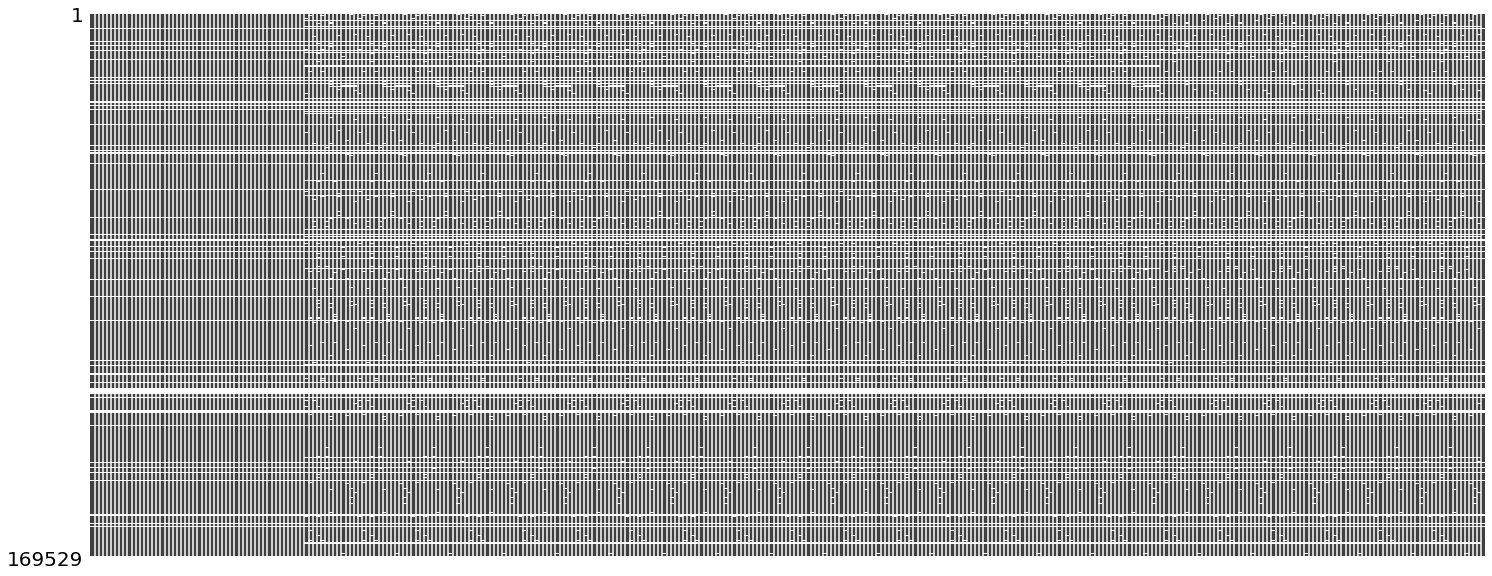

In [0]:
import missingno
missingno.matrix(gee_merge, sparkline=False)

In [0]:
missingno.matrix(gee_merge[gee_precip])

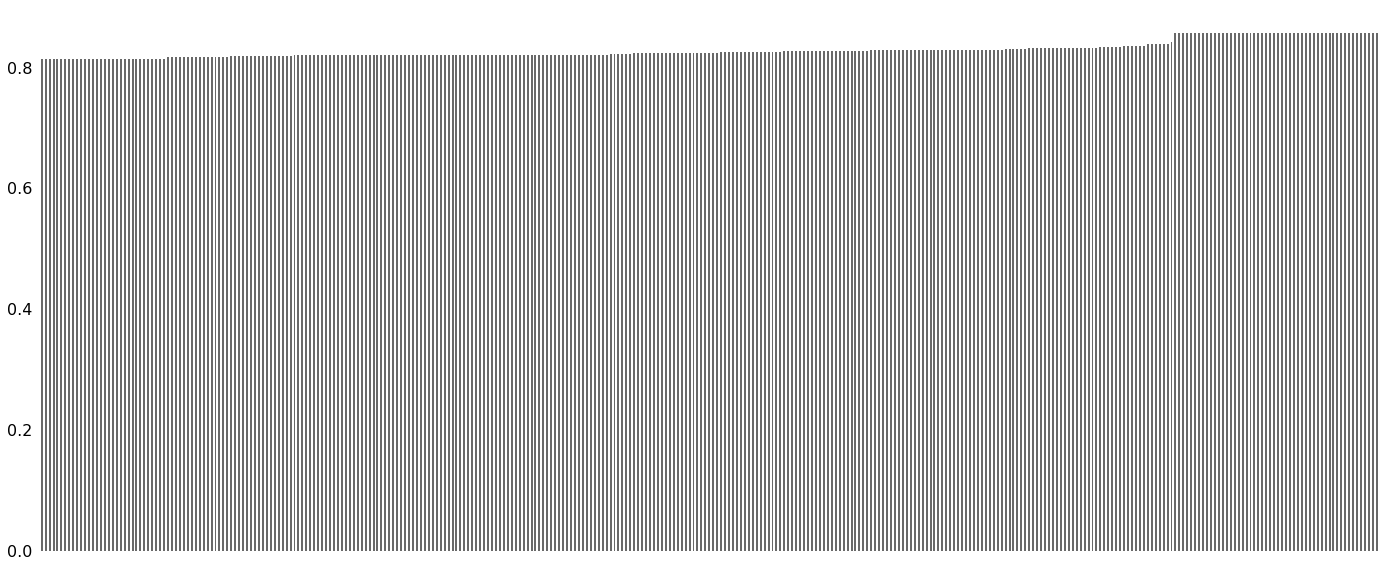

In [0]:
missingno.bar(gee_merge,sort='ascending')

In [0]:
# Random forest imputation takes over 10 hours
# imputer = MissForest()
# gee_merge_imp = imputer.fit_transform(gee_merge)

In [0]:
# https://scikit-learn.org/stable/modules/impute.html
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=3, random_state=0, n_nearest_features = 50)
gee_merge_imp = pd.DataFrame(imp.fit_transform(gee_merge))
gee_merge_imp.head()

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338
0,7.0073e-06,6.4597e-06,1.9034e-05,0.0004,1.2106e-05,2.6450e-07,2.4611e-04,8.7358e-07,3.3528e-07,1.9651e-07,2.1793e-07,1.8068e-07,0.0010,299.1134,293.1567,285.6674,284.9066,283.0721,285.5657,291.2571,299.2114,300.7594,302.7293,302.4364,301.1776,298.0068,305.6742,299.8900,291.6362,291.1770,289.3540,292.0720,297.5405,306.0551,306.7567,308.6465,308.3518,307.6812,304.2836,292.4492,...,834.0,654.0,606.0,573.0,558.0,715.0,787.0000,1122.0,1236.0,1294.0,1179.0,994.0,808.0000,166.0,104.0,57.0,30.0,15.0,45.0,77.0000,166.0,182.0,207.0,199.0,189.0,148.000,340.0,285.0,234.0,199.0,172.0,200.0,230.0000,303.0,332.0,365.0,362.0,355.0,320.0000,351.0
1,3.1292e-07,2.7023e-05,2.8402e-05,0.0013,8.9999e-05,1.3670e-05,3.5390e-07,3.3434e-07,2.4028e-07,1.3039e-07,2.6822e-07,8.9407e-08,0.0025,296.2534,288.9605,287.2007,282.3174,285.6470,289.0997,299.9706,301.1915,303.5060,302.9342,303.5437,299.9451,298.6671,302.8565,295.2007,293.2851,287.2592,292.1219,295.3519,306.7212,306.9961,309.3208,308.4730,309.7279,306.1953,305.1323,289.0441,...,557.0,479.0,529.0,516.0,640.0,709.0,1049.9921,1091.0,1028.0,1051.0,903.0,833.0,633.0000,152.0,88.0,71.0,26.0,60.0,95.0,166.4081,196.0,212.0,230.0,226.0,212.0,175.000,315.0,248.0,226.0,176.0,206.0,242.0,297.6903,345.0,355.0,381.0,378.0,390.0,350.0000,425.0
2,1.9599e-02,2.2406e-02,7.1968e-02,0.0295,2.6193e-02,4.4627e-02,1.0215e-01,5.5820e-02,2.0620e-02,1.7727e-02,6.1757e-03,4.8462e-03,0.0161,293.7984,290.1615,285.3027,281.5806,281.3073,281.9963,284.9608,290.6607,295.4207,298.6623,300.8982,300.7842,293.8475,300.5960,296.7315,290.5296,286.8741,286.1828,285.9498,288.8385,295.4506,301.5076,305.3788,307.8492,308.1998,299.8096,286.7686,...,1328.0,1211.0,1032.0,874.0,722.0,769.0,879.0000,1108.0,1393.0,1639.0,1614.0,1583.0,1503.0000,144.0,109.0,75.0,46.0,23.0,26.0,39.0000,81.0,124.0,155.0,175.0,190.0,163.000,305.0,253.0,216.0,163.0,130.0,122.0,127.0000,176.0,241.0,299.0,346.0,378.0,331.0000,609.0
3,2.5962e-02,7.9507e-05,4.0216e-03,0.0045,4.2459e-03,2.7613e-03,1.2176e-02,7.3460e-02,1.0799e-01,1.8349e-01,1.3596e-01,6.6958e-02,0.0457,296.0192,294.8300,289.5608,289.9531,290.5349,293.2784,295.3645,296.2125,296.0294,296.5884,296.4400,296.7964,295.0937,302.0390,301.9722,296.4940,296.5933,297.3080,299.9913,301.2359,301.7325,301.3194,301.5213,301.8096,302.3876,300.9992,289.9825,...,1149.0,1023.0,903.0,957.0,1080.0,1356.0,1619.0000,1917.0,2046.0,2052.0,1886.0,1493.0,1363.7913,141.0,116.0,67.0,67.0,74.0,101.0,129.0000,153.0,162.0,170.0,161.0,153.0,142.008,288.0,294.0,242.0,232.0,241.0,259.0,274.0000,280.0,279.0,283.0,283.0,277.0,297.9742,1220.0
4,3.2184e-02,7.0202e-03,3.0607e-03,0.0007,5.3964e-02,1.6903e-02,1.7070e-01,2.3786e-01,2.0231e-01,2.2035e-01,1.5817e-01,1.6469e-01,0.0520,296.7374,291.9684,291.5591,293.7823,298.7383,301.9528,301.6745,301.4377,301.8101,302.5836,301.6844,300.2223,295.6015,302.6340,297.8095,297.1943,299.5117,303.1986,305.4783,304.2817,304.1788,304.7936,306.0596,306.3792,305.4156,301.0398,291.4184,...,2260.0,1655.0,1497.0,1592.0,2079.0,2750.0,3224.0000,3249.0,3433.0,3231.0,3124.0,2670.0,2008.0000,195.0,139.0,121.0,127.0,178.0,235.0,257.0000,260.0,264.0,255.0,248.0,221.0,180.000,308.0,263.0,242.0,252.0,278.0,320.0,317.0000,307.0,318.0,315.0,346.0,332.0,304.0000,6.0


In [0]:
gee_merge_imp.index = gee_merge.index
gee_merge_imp.columns = gee_merge.columns
gee_merge_imp.head()


(169529, 339)


In [0]:

print(gee_merge_imp.shape)

In [0]:
gee_merge_imp.to_pickle('gee_data_imp.pkl')

## Importing GEE Environmental Variables


In [0]:
gee_data = pd.read_pickle('gee_data_imp.pkl')
gee_data.head()

,"(total_precipitation, 0)","(total_precipitation, 1)","(total_precipitation, 2)","(total_precipitation, 3)","(total_precipitation, 4)","(total_precipitation, 5)","(total_precipitation, 6)","(total_precipitation, 7)","(total_precipitation, 8)","(total_precipitation, 9)","(total_precipitation, 10)","(total_precipitation, 11)","(total_precipitation, 12)","(mean_2m_air_temperature, 0)","(mean_2m_air_temperature, 1)","(mean_2m_air_temperature, 2)","(mean_2m_air_temperature, 3)","(mean_2m_air_temperature, 4)","(mean_2m_air_temperature, 5)","(mean_2m_air_temperature, 6)","(mean_2m_air_temperature, 7)","(mean_2m_air_temperature, 8)","(mean_2m_air_temperature, 9)","(mean_2m_air_temperature, 10)","(mean_2m_air_temperature, 11)","(mean_2m_air_temperature, 12)","(maximum_2m_air_temperature, 0)","(maximum_2m_air_temperature, 1)","(maximum_2m_air_temperature, 2)","(maximum_2m_air_temperature, 3)","(maximum_2m_air_temperature, 4)","(maximum_2m_air_temperature, 5)","(maximum_2m_air_temperature, 6)","(maximum_2m_air_temperature, 7)","(maximum_2m_air_temperature, 8)","(maximum_2m_air_temperature, 9)","(maximum_2m_air_temperature, 10)","(maximum_2m_air_temperature, 11)","(maximum_2m_air_temperature, 12)","(minimum_2m_air_temperature, 0)",...,"(vap, 0)","(vap, 1)","(vap, 2)","(vap, 3)","(vap, 4)","(vap, 5)","(vap, 6)","(vap, 7)","(vap, 8)","(vap, 9)","(vap, 10)","(vap, 11)","(vap, 12)","(tmmn, 0)","(tmmn, 1)","(tmmn, 2)","(tmmn, 3)","(tmmn, 4)","(tmmn, 5)","(tmmn, 6)","(tmmn, 7)","(tmmn, 8)","(tmmn, 9)","(tmmn, 10)","(tmmn, 11)","(tmmn, 12)","(tmmx, 0)","(tmmx, 1)","(tmmx, 2)","(tmmx, 3)","(tmmx, 4)","(tmmx, 5)","(tmmx, 6)","(tmmx, 7)","(tmmx, 8)","(tmmx, 9)","(tmmx, 10)","(tmmx, 11)","(tmmx, 12)","(av_altitude, 0)"
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4ESWYT_19105_254741_5,7.0073e-06,6.4597e-06,1.9034e-05,0.0004,1.2106e-05,2.6450e-07,2.4611e-04,8.7358e-07,3.3528e-07,1.9651e-07,2.1793e-07,1.8068e-07,0.0010,299.1134,293.1567,285.6674,284.9066,283.0721,285.5657,291.2571,299.2114,300.7594,302.7293,302.4364,301.1776,298.0068,305.6742,299.8900,291.6362,291.1770,289.3540,292.0720,297.5405,306.0551,306.7567,308.6465,308.3518,307.6812,304.2836,292.4492,...,834.0,654.0,606.0,573.0,558.0,715.0,787.0000,1122.0,1236.0,1294.0,1179.0,994.0,808.0000,166.0,104.0,57.0,30.0,15.0,45.0,77.0000,166.0,182.0,207.0,199.0,189.0,148.000,340.0,285.0,234.0,199.0,172.0,200.0,230.0000,303.0,332.0,365.0,362.0,355.0,320.0000,351.0
4ESWYT_19207_254741_5,3.1292e-07,2.7023e-05,2.8402e-05,0.0013,8.9999e-05,1.3670e-05,3.5390e-07,3.3434e-07,2.4028e-07,1.3039e-07,2.6822e-07,8.9407e-08,0.0025,296.2534,288.9605,287.2007,282.3174,285.6470,289.0997,299.9706,301.1915,303.5060,302.9342,303.5437,299.9451,298.6671,302.8565,295.2007,293.2851,287.2592,292.1219,295.3519,306.7212,306.9961,309.3208,308.4730,309.7279,306.1953,305.1323,289.0441,...,557.0,479.0,529.0,516.0,640.0,709.0,1049.9921,1091.0,1028.0,1051.0,903.0,833.0,633.0000,152.0,88.0,71.0,26.0,60.0,95.0,166.4081,196.0,212.0,230.0,226.0,212.0,175.000,315.0,248.0,226.0,176.0,206.0,242.0,297.6903,345.0,355.0,381.0,378.0,390.0,350.0000,425.0
4ESWYT_19402_254741_5,1.9599e-02,2.2406e-02,7.1968e-02,0.0295,2.6193e-02,4.4627e-02,1.0215e-01,5.5820e-02,2.0620e-02,1.7727e-02,6.1757e-03,4.8462e-03,0.0161,293.7984,290.1615,285.3027,281.5806,281.3073,281.9963,284.9608,290.6607,295.4207,298.6623,300.8982,300.7842,293.8475,300.5960,296.7315,290.5296,286.8741,286.1828,285.9498,288.8385,295.4506,301.5076,305.3788,307.8492,308.1998,299.8096,286.7686,...,1328.0,1211.0,1032.0,874.0,722.0,769.0,879.0000,1108.0,1393.0,1639.0,1614.0,1583.0,1503.0000,144.0,109.0,75.0,46.0,23.0,26.0,39.0000,81.0,124.0,155.0,175.0,190.0,163.000,305.0,253.0,216.0,163.0,130.0,122.0,127.0000,176.0,241.0,299.0,346.0,378.0,331.0000,609.0
4ESWYT_11101_254741_5,2.5962e-02,7.9507e-05,4.0216e-03,0.0045,4.2459e-03,2.7613e-03,1.2176e-02,7.3460e-02,1.0799e-01,1.8349e-01,1.3596e-01,6.6958e-02,0.0457,296.0192,294.8300,289.5608,289.9531,290.5

In [0]:
gee_data.shape

(169529, 339)

In [0]:
gee_columns = gee_data.columns

### Visualizing GEE Data

In [0]:
gee_precip = gee_data.filter(like='precip',axis=1).columns
gee_precip

Index([ ('total_precipitation', 0),  ('total_precipitation', 1),
        ('total_precipitation', 2),  ('total_precipitation', 3),
        ('total_precipitation', 4),  ('total_precipitation', 5),
        ('total_precipitation', 6),  ('total_precipitation', 7),
        ('total_precipitation', 8),  ('total_precipitation', 9),
       ('total_precipitation', 10), ('total_precipitation', 11),
       ('total_precipitation', 12)],
      dtype='object')

In [0]:
gee_data[gee_precip].head()

,"(total_precipitation, 0)","(total_precipitation, 1)","(total_precipitation, 2)","(total_precipitation, 3)","(total_precipitation, 4)","(total_precipitation, 5)","(total_precipitation, 6)","(total_precipitation, 7)","(total_precipitation, 8)","(total_precipitation, 9)","(total_precipitation, 10)","(total_precipitation, 11)","(total_precipitation, 12)"
Unique_ID,,,,,,,,,,,,,
4ESWYT_19105_254741_5,7.0073e-06,6.4597e-06,1.9034e-05,0.0004,1.2106e-05,2.6450e-07,2.4611e-04,8.7358e-07,3.3528e-07,1.9651e-07,2.1793e-07,1.8068e-07,0.0010
4ESWYT_19207_254741_5,3.1292e-07,2.7023e-05,2.8402e-05,0.0013,8.9999e-05,1.3670e-05,3.5390e-07,3.3434e-07,2.4028e-07,1.3039e-07,2.6822e-07,8.9407e-08,0.0025
4ESWYT_19402_254741_5,1.9599e-02,2.2406e-02,7.1968e-02,0.0295,2.6193e-02,4.4627e-02,1.0215e-01,5.5820e-02,2.0620e-02,1.7727e-02,6.1757e-03,4.8462e-03,0.0161
4ESWYT_11101_254741_5,2.5962e-02,7.9507e-05,4.0216e-03,0.0045,4.2459e-03,2.7613e-03,1.2176e-02,7.3460e-02,1.0799e-01,1.8349e-01,1.3596e-01,6.6958e-02,0.0457
4ESWYT_22001_254741_5,3.2184e-02,7.0202e-03,3.0607e-03,0.0007,5.3964e-02,1.6903e-02,1.7070e-01,2.3786e-01,2.0231e-01,2.2035e-01,1.5817e-01,1.6469e-01,0.0520


In [0]:
gee_precip_mm = gee_data[gee_precip] * 1000
gee_precip_mm.head()

,"(total_precipitation, 0)","(total_precipitation, 1)","(total_precipitation, 2)","(total_precipitation, 3)","(total_precipitation, 4)","(total_precipitation, 5)","(total_precipitation, 6)","(total_precipitation, 7)","(total_precipitation, 8)","(total_precipitation, 9)","(total_precipitation, 10)","(total_precipitation, 11)","(total_precipitation, 12)"
Unique_ID,,,,,,,,,,,,,
4ESWYT_19105_254741_5,0.0070,0.0065,0.0190,0.3675,0.0121,0.0003,0.2461,0.0009,0.0003,0.0002,0.0002,1.8068e-04,1.0045
4ESWYT_19207_254741_5,0.0003,0.0270,0.0284,1.2691,0.0900,0.0137,0.0004,0.0003,0.0002,0.0001,0.0003,8.9407e-05,2.4501
4ESWYT_19402_254741_5,19.5987,22.4063,71.9678,29.4920,26.1929,44.6266,102.1540,55.8195,20.6197,17.7266,6.1757,4.8462e+00,16.1039
4ESWYT_11101_254741_5,25.9617,0.0795,4.0216,4.4536,4.2459,2.7613,12.1760,73.4602,107.9861,183.4929,135.9608,6.6958e+01,45.6753
4ESWYT_22001_254741_5,32.1843,7.0202,3.0607,0.7023,53.9639,16.9033,170.6983,237.8621,202.3085,220.3454,158.1706,1.6469e+02,51.9862


### Comparing GEE and CIMMYT Environmental Data

In [0]:
W = pd.read_pickle('W_proc.pkl')


In [0]:
W_precip = W.filter(like='PPN',axis=1).columns
W_precip


Index(['PPN_10TH_MO_BEFORE_HARVESTED', 'PPN_11TH_MO_BEFORE_HARVESTED',
       'PPN_1ST_MO_BEFORE_HARVESTED', 'PPN_2ND_MO_BEFORE_HARVESTED',
       'PPN_3RD_MO_BEFORE_HARVESTED', 'PPN_4TH_MO_BEFORE_HARVESTED',
       'PPN_5TH_MO_BEFORE_HARVESTED', 'PPN_6TH_MO_BEFORE_HARVESTED',
       'PPN_7TH_MO_BEFORE_HARVESTED', 'PPN_8TH_MO_BEFORE_HARVESTED',
       'PPN_9TH_MO_BEFORE_HARVESTED', 'PPN_MONTH_OF_HARVESTED'],
      dtype='object')

In [0]:
W_precip_sorted = ['PPN_MONTH_OF_HARVESTED',
                   'PPN_1ST_MO_BEFORE_HARVESTED',
                   'PPN_2ND_MO_BEFORE_HARVESTED',
                    'PPN_3RD_MO_BEFORE_HARVESTED', 
                    'PPN_4TH_MO_BEFORE_HARVESTED',
                    'PPN_5TH_MO_BEFORE_HARVESTED', 
                    'PPN_6TH_MO_BEFORE_HARVESTED',
                    'PPN_7TH_MO_BEFORE_HARVESTED', 
                    'PPN_8TH_MO_BEFORE_HARVESTED',
                    'PPN_9TH_MO_BEFORE_HARVESTED',
                   'PPN_10TH_MO_BEFORE_HARVESTED', 
                   'PPN_11TH_MO_BEFORE_HARVESTED']

In [0]:
W[W_precip_sorted].head()

,PPN_MONTH_OF_HARVESTED,PPN_1ST_MO_BEFORE_HARVESTED,PPN_2ND_MO_BEFORE_HARVESTED,PPN_3RD_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED,PPN_9TH_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED,PPN_11TH_MO_BEFORE_HARVESTED
Unique_ID,,,,,,,,,,,,
4ESWYT_19105_254741_5,40.879,28.893,31.468,20.8195,22.456,18.264,16.9880,26.3400,56.991,38.320,29.930,21.359
4ESWYT_19207_254741_5,54.998,20.998,70.347,21.3820,18.201,49.838,29.4454,25.2614,93.085,95.362,44.911,48.096
4ESWYT_19402_254741_5,38.123,14.299,69.066,16.2220,18.483,13.459,16.0520,25.6374,53.807,34.708,39.141,21.406
4ESWYT_11101_254741_5,115.840,40.856,45.474,97.1960,36.445,42.274,15.8552,25.2919,43.952,137.308,47.314,32.253
4ESWYT_22001_254741_5,40.676,28.472,26.006,19.6375,28.621,22.544,17.9850,22.3520,54.886,37.881,27.798,20.835


Function correlation_matrix: X.shape, y.shape, yX.shape: (169529, 13) (169529, 12) (169529, 25)



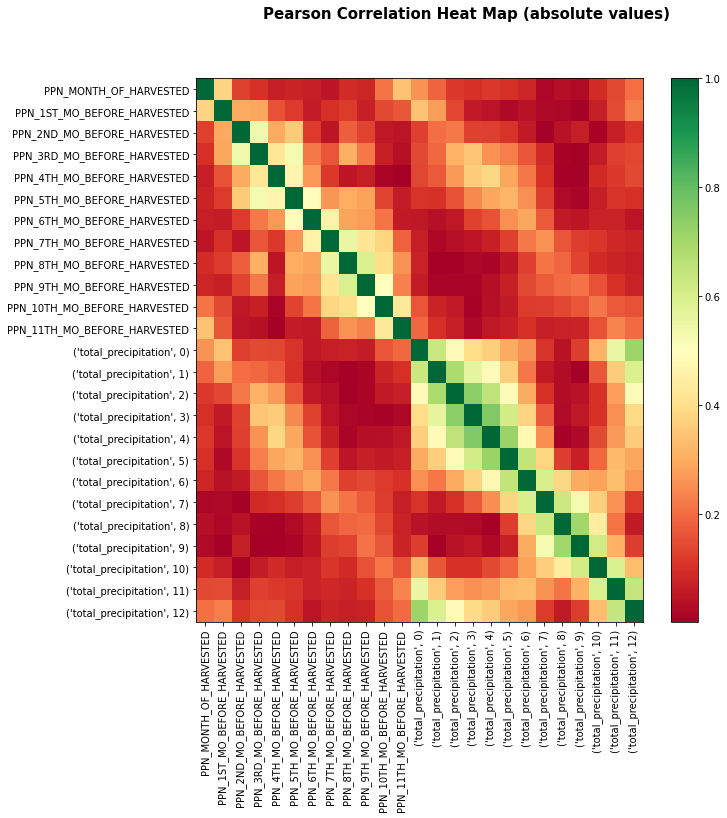

In [0]:

# Build the correlation matrix for the train data
yX, yX_corr, yX_abs_corr = correlation_matrix(W[W_precip_sorted], gee_precip_mm, is_plot=True)  

## Introduction of Pedigree Coefficient of Parentage Columns

In [0]:
A = pd.read_pickle('A_matrix_unique.pkl')
A.head()

,2099196,464211,419525,12867,13119,13469,20424,13421,92207,414940,67929,13098,424689,13396,4570,345434,416396,775,39359,420158,4248,13569,1477994,422181,669426,16262,62576,304136,13302,3895,434655,460695,24825,13662,41750,222439,427366,670359,427668,1478148,...,4754333,4754361,4754550,4754941,4754971,4755016,4755015,4755033,4755104,4755407,4755406,4755489,4755554,4755706,4755691,4755841,4755979,4757265,4757836,4757872,4757918,4757908,4757903,4758872,4760307,4879639,4880354,4880451,4880411,4880410,4763642,4763836,4764397,4764687,4880829,4881156,4885160,4904773,4905340,4905746
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0587,0.0587,0.0587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
A.shape

(3489, 3489)

In [0]:
A.to_csv('A_matrix_unique.csv')

In [0]:
from sklearn.preprocessing import StandardScaler
A_scaled = pd.DataFrame(StandardScaler().fit_transform(A), index = A.index)

In [0]:
from sklearn.decomposition import PCA
n_components = 100
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(A_scaled)
principalDf = pd.DataFrame(data = principalComponents, index=A.index, columns=['PC_' + str(comp) for comp in range(n_components)])

In [0]:
principalDf.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,PC_35,PC_36,PC_37,PC_38,PC_39,...,PC_60,PC_61,PC_62,PC_63,PC_64,PC_65,PC_66,PC_67,PC_68,PC_69,PC_70,PC_71,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78,PC_79,PC_80,PC_81,PC_82,PC_83,PC_84,PC_85,PC_86,PC_87,PC_88,PC_89,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30374,-68.1798,0.1502,-5.4699,-4.1179,-11.7563,-9.8165,3.8804,-4.9781,2.2299,2.5035,-2.377,-3.0300,0.1700,-0.4190,-2.7026,-2.8962,-3.3498,-1.2418,-1.7077,-0.6397,-2.2893,7.5531,0.8338,-8.0233,-1.3137,7.0870,3.2711,10.6847,2.9635,2.6443,-0.8077,-0.2085,-2.7284,-0.3080,0.3040,-4.1702,1.4952,-1.2802,0.1238,2.0907,...,-0.4701,-1.7511,-0.4360,1.8743,-0.7920,0.5401,1.0877,-0.7496,1.6460,-0.3543,-1.4198,0.6924,0.3213,-0.3377,-1.3747,0.6697,0.6261,-0.7784,-0.2692,0.5535,0.8690,-0.2785,0.4262,0.9907,-1.7947,-1.2466,-0.5482,-0.8167,0.6659,-0.7778,-0.8837,-0.1717,0.3547,2.6644,0.6956,-2.1041,0.5963,-0.1443,-0.2478,1.5732
78690,-71.2234,1.6026,-7.4940,-3.3383,-9.9704,-9.4317,4.6433,-4.3570,1.4985,-2.2518,-0.717,-4.7956,-0.6809,0.3346,-1.8952,-1.5701,-1.8919,-2.9292,0.3409,-2.7184,-1.1151,0.6851,0.6285,0.4440,0.0422,-0.8980,0.0440,0.0861,0.4718,-0.0864,-0.9797,-0.5770,-0.1462,-1.3618,0.2129,0.5750,-0.8307,-1.8733,0.9001,-1.0935,...,0.1670,-1.1991,-0.6091,0.5605,0.5793,-0.6626,0.9629,-0.4272,-0.5872,-0.0393,-0.3836,-0.8364,-0.0401,0.4711,0.0533,-0.2318,0.1782,-0.5790,-0.4951,-0.2031,-0.2810,0.8295,0.2641,-0.2411,-0.1167,0.1452,-0.4839,0.0872,0.6244,1.0053,-2.2306,-1.0544,0.4884,-0.2018,-0.6946,-0.2705,-0.0681,0.6244,-1.5596,0.4866
15292,-71.2135,1.5883,-7.4799,-3.2906,-10.3417,-9.4054,4.6513,-4.2603,0.5775,-1.8216,-0.798,-5.2608,0.2850,0.3816,-1.8151,-1.5084,-2.2808,-2.9927,0.4211,-2.3449,-1.1359,0.9737,0.9534,0.1452,-0.4164,-1.2934,-0.2647,0.1193,0.2348,-0.0179,-0.9223,-0.4269,-0.3559,-1.0558,0.3040,0.7480,-0.8057,-1.7784,1.0757,-1.2814,...,0.0867,-1.1413,-0.7112,0.4545,0.4947,-0.6716,0.6650,-0.1396,-0.6983,0.0207,-0.6820,-0.8664,0.0716,0.7633,0.0204,-0.0903,0.1564,-0.3385,-0.6404,0.8526,0.2819,0.3652,0.2410,0.1441,-0.6462,-0.4638,-1.0011,-0.4120,-0.2352,0.3938,-0.2190,-0.4849,0.4609,0.3745,0.1964,-0.3413,0.1921,-0.2408,-0.7708,0.6914
67229,-71.2135,1.5883,-7.4799,-3.2906,-10.3417,-9.4054,4.6513,-4.2603,0.5775,-1.8216,-0.798,-5.2608,0.2850,0.3816,-1.8151,-1.5084,-2.2808,-2.9927,0.4211,-2.3449,-1.1359,0.9737,0.9534,0.1452,-0.4164,-1.2934,-0.2647,0.1194,0.2348,-0.0179,-0.9223,-0.4269,-0.3559,-1.0558,0.3040,0.7480,-0.8056,-1.7784,1.0757,-1.2815,...,0.0809,-1.1292,-0.7212,0.4564,0.4909,-0.6733,0.6675,-0.1318,-0.6785,0.0159,-0.6806,-0.8651,0.0569,0.7964,-0.0062,-0.0725,0.1593,-0.4197,-0.6816,0.8128,0.2776,0.4549,0.1701,0.2430,-0.7368,-0.4126,-0.9657,-0.3116,-0.2088,0.3295,-0.2283,-0.5327,0.2645,0.4132,0.3063,-0.5901,0.3422,-0.1942,-0.5991,0.8436
67418,-71.2135,1.5883,-7.4799,-3.2906,-10.3417,-9.4054,4.6513,-4.2603,0.5775,-1.8216,-0.798,-5.2608,0.2850,0.3816,-1.8151,-1.5084,-2.2808,-2.9927,0.4211,-2.3449,-1.1359,0.9737,0.9534,0.1452,-0.4164,-1.2934,-0.2647,0.1193,0.2348,-0.0179,-0.9223,-0.4269,-0.3559,-1.0558,0.3040,0.7480,-0.8056,-1.7783,1.0756,-1.2816,...,0.0826,-1.1301,-0.7143,0.4561,0.4930,-0.6652,0.6682,-0.1391,-0.6991,0.0150,-0.6791,-0.8735,0.0594,0.7711,0.0140,-0.0769,0.1909,-0.4141,-0.6809,0.8099,0.3190,0.4708,0.1722,0.2458,-0.6770,-0.3771,-0.9522,-0.3009,-0.2539,0.2951,-0.4488,-0.5750,0.2849,0.4377,0.1752,-0.4344,0.6396,-0.0258,-0.8091,0.6734


In [0]:
sum(pca.explained_variance_ratio_)

0.8899111251615153

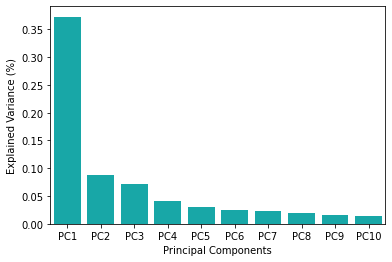

In [0]:
pc_plot_data = pd.DataFrame({'Explained Variance (%)':pca.explained_variance_ratio_[0:10],
             'Principal Components':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']})
sns.barplot(x='Principal Components',y="Explained Variance (%)", 
           data=pc_plot_data, color="c")

In [0]:
principalDf.reset_index(inplace=True)
principalDf.head()

,index,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,PC_35,PC_36,PC_37,PC_38,...,PC_60,PC_61,PC_62,PC_63,PC_64,PC_65,PC_66,PC_67,PC_68,PC_69,PC_70,PC_71,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78,PC_79,PC_80,PC_81,PC_82,PC_83,PC_84,PC_85,PC_86,PC_87,PC_88,PC_89,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99
0,30374,-68.1798,0.1502,-5.4699,-4.1179,-11.7563,-9.8165,3.8804,-4.9781,2.2299,2.5035,-2.377,-3.0300,0.1700,-0.4190,-2.7026,-2.8962,-3.3498,-1.2418,-1.7077,-0.6397,-2.2893,7.5531,0.8338,-8.0233,-1.3137,7.0870,3.2711,10.6847,2.9635,2.6443,-0.8078,-0.2085,-2.7284,-0.3080,0.3040,-4.1701,1.4951,-1.2804,0.1238,...,-0.4793,-1.7626,-0.4572,1.8870,-0.8480,0.5737,1.1094,-0.7553,1.5161,-0.3938,-1.4568,0.7929,0.2953,0.3262,-1.1617,0.5312,0.6546,-0.9492,-0.3658,0.2942,0.8830,-0.2133,0.0533,1.2410,-1.4189,-1.3254,-0.0144,-0.5791,0.6474,-0.0340,0.6987,-2.3364,1.7233,0.6572,0.8495,-1.2723,-0.7525,-0.0098,-0.9383,-0.9010
1,78690,-71.2234,1.6026,-7.4940,-3.3383,-9.9704,-9.4317,4.6433,-4.3570,1.4985,-2.2518,-0.717,-4.7956,-0.6809,0.3346,-1.8952,-1.5701,-1.8919,-2.9292,0.3409,-2.7184,-1.1151,0.6851,0.6285,0.4441,0.0422,-0.8980,0.0440,0.0862,0.4718,-0.0864,-0.9797,-0.5770,-0.1462,-1.3618,0.2129,0.5750,-0.8308,-1.8735,0.9002,...,0.1545,-1.1950,-0.6776,0.5710,0.5786,-0.6908,0.9677,-0.3618,-0.5785,-0.1212,-0.3485,-0.8347,0.0313,-0.4368,0.1467,-0.0960,0.3646,-0.8764,-0.5621,0.0923,-0.2836,0.7989,0.2451,0.0023,-0.3885,0.3476,-1.0739,-0.0263,0.8634,0.7431,1.4189,-0.7587,-0.0802,-0.2551,0.2593,-1.2487,1.0834,0.1487,-1.1391,-1.5967
2,15292,-71.2135,1.5883,-7.4799,-3.2906,-10.3417,-9.4054,4.6513,-4.2603,0.5775,-1.8216,-0.798,-5.2608,0.2850,0.3816,-1.8151,-1.5084,-2.2808,-2.9927,0.4211,-2.3449,-1.1359,0.9737,0.9534,0.1452,-0.4164,-1.2934,-0.2647,0.1194,0.2348,-0.0179,-0.9223,-0.4268,-0.3560,-1.0559,0.3041,0.7480,-0.8057,-1.7784,1.0757,...,0.0749,-1.1308,-0.7336,0.4475,0.4695,-0.6562,0.6778,-0.1559,-0.7502,-0.0121,-0.6925,-0.8512,0.0321,-0.7878,0.0509,-0.1078,0.2310,-0.4276,-0.8212,0.6363,0.3534,0.4528,0.0064,0.3565,-0.6795,-0.2414,-0.9281,-0.1693,-0.4314,0.4995,0.2264,-0.9322,-0.5193,-0.0859,0.9565,-0.5433,0.1578,-0.0785,-0.9890,-0.0437
3,67229,-71.2135,1.5883,-7.4799,-3.2906,-10.3417,-9.4054,4.6513,-4.2603,0.5775,-1.8216,-0.798,-5.2608,0.2850,0.3816,-1.8151,-1.5084,-2.2808,-2.9927,0.4211,-2.3449,-1.1359,0.9737,0.9534,0.1452,-0.4164,-1.2934,-0.2647,0.1194,0.2348,-0.0179,-0.9223,-0.4269,-0.3560,-1.0559,0.3040,0.7480,-0.8056,-1.7784,1.0756,...,0.0803,-1.1318,-0.7328,0.4345,0.4961,-0.6653,0.6830,-0.1242,-0.7245,-0.0025,-0.6900,-0.8641,0.0583,-0.7264,0.0621,-0.0492,0.2491,-0.4688,-0.8550,0.7061,0.3379,0.4300,0.0092,0.3983,-0.6868,-0.2060,-0.9461,-0.2262,-0.1078,0.2622,0.2638,-0.8411,-0.1835,0.0001,0.3952,-0.4207,0.1616,-0.2096,-0.7950,-0.9781
4,67418,-71.2135,1.5883,-7.4799,-3.2906,-10.3417,-9.4054,4.6513,-4.2603,0.5775,-1.8216,-0.798,-5.2608,0.2850,0.3816,-1.8151,-1.5084,-2.2808,-2.9927,0.4211,-2.3449,-1.1359,0.9737,0.9534,0.1452,-0.4164,-1.2934,-0.2647,0.1194,0.2348,-0.0179,-0.9223,-0.4268,-0.3560,-1.0559,0.3040,0.7480,-0.8056,-1.7784,1.0757,...,0.0748,-1.1372,-0.7376,0.4476,0.4764,-0.6695,0.6833,-0.1478,-0.7377,-0.0020,-0.6897,-0.8498,0.0394,-0.7606,0.0918,-0.0710,0.2373,-0.4752,-0.8407,0.7201,0.3100,0.3916,0.0167,0.2653,-0.6448,-0.2374,-1.0021,-0.1681,-0.3295,0.4024,0.2229,-0.7286,-0.3682,-0.0376,0.8078,-0.3585,0.3466,-0.1115,-0.7204,-0.2414


In [0]:
Y_VAR_ENV.head()

,GRAIN_YIELD,GID,LAT_LONG_MONTH_YEAR
Unique_ID,,,
4ESWYT_19105_254741_5,6.250,2099196,26.36_31.4_5_1983_22
4ESWYT_19207_254741_5,5.944,2099196,25.0_23.0_4_1983_30
4ESWYT_19402_254741_5,5.089,2099196,36.44_9.08_6_1983_8
4ESWYT_11101_254741_5,7.983,2099196,-17.41_30.25_10_1983_27
4ESWYT_22001_254741_5,4.452,2099196,23.59_90.25_3_1983_15


In [0]:
Y_VAR_ENV['GID'] = Y_VAR_ENV['GID'].astype(str)
Y_VAR_ENV.dtypes

GRAIN_YIELD                float64
GID                         object
LAT_LONG_DAY_MONTH_YEAR     object
dtype: object

In [0]:
# Remove GID with less than 3 unique observations associated

GID_counts = pd.DataFrame(np.unique(Y_VAR_ENV['GID'], return_counts=True)).transpose()
GID_counts.columns = ['GID','Count']
GID_counts.set_index('GID').sort_values('Count')

,Count
GID,
7634751,8
7729813,8
7729805,8
7729800,8
7729795,8
...,...
16004,431
109278,574
16122,666


In [0]:
Y_A = pd.merge(Y_VAR_ENV, principalDf, left_on='GID', right_on='index', how='left')
Y_A = Y_A.set_index(Y_VAR_ENV.index)
Y_A.head()

,GRAIN_YIELD,GID,LAT_LONG_DAY_MONTH_YEAR,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,PC_35,PC_36,...,PC_60,PC_61,PC_62,PC_63,PC_64,PC_65,PC_66,PC_67,PC_68,PC_69,PC_70,PC_71,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78,PC_79,PC_80,PC_81,PC_82,PC_83,PC_84,PC_85,PC_86,PC_87,PC_88,PC_89,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4ESWYT_19105_254741_5,6.250,2099196,26.36_31.4_22_5_1983,-20.577,-9.4111,5.3538,2.4173,2.268,-1.5016,0.9222,2.0571,-0.1759,0.9096,0.6057,-3.2816,2.3446,2.0401,0.507,-5.4464,3.1259,-2.0896,-0.2648,-2.6836,-3.368,-0.2274,-2.4609,-1.8656,1.2987,-1.4643,1.1615,-1.9113,-1.099,3.5851,-1.0347,1.3967,-2.766,1.1083,2.1433,-0.4217,-0.8316,...,0.1204,-0.6012,1.8196,-0.9299,1.3951,0.8239,-0.8954,-0.2847,0.5011,-0.1883,-0.1072,0.7283,-0.0418,-2.1864,-0.7232,-0.259,-0.8542,-0.2618,-0.2249,-0.7592,-0.5402,0.7735,0.1191,-1.7478,-0.0228,0.4371,0.5341,0.6928,0.1284,1.264,1.183,0.6663,-0.5348,-0.6584,-0.9918,1.2684,-2.2677,0.1783,-1.1073,-0.8831
4ESWYT_19207_254741_5,5.944,2099196,25.0_23.0_30_4_1983,-20.577,-9.4111,5.3538,2.4173,2.268,-1.5016,0.9222,2.0571,-0.1759,0.9096,0.6057,-3.2816,2.3446,2.0401,0.507,-5.4464,3.1259,-2.0896,-0.2648,-2.6836,-3.368,-0.2274,-2.4609,-1.8656,1.2987,-1.4643,1.1615,-1.9113,-1.099,3.5851,-1.0347,1.3967,-2.766,1.1083,2.1433,-0.4217,-0.8316,...,0.1204,-0.6012,1.8196,-0.9299,1.3951,0.8239,-0.8954,-0.2847,0.5011,-0.1883,-0.1072,0.7283,-0.0418,-2.1864,-0.7232,-0.259,-0.8542,-0.2618,-0.2249,-0.7592,-0.5402,0.7735,0.1191,-1.7478,-0.0228,0.4371,0.5341,0.6928,0.1284,1.264,1.183,0.6663,-0.5348,-0.6584,-0.9918,1.2684,-2.2677,0.1783,-1.1073,-0.8831
4ESWYT_19402_254741_5,5.089,2099196,36.44_9.08_8_6_1983,-20.577,-9.4111,5.3538,2.4173,2.268,-1.5016,0.9222,2.0571,-0.1759,0.9096,0.6057,-3.2816,2.3446,2.0401,0.507,-5.4464,3.1259,-2.0896,-0.2648,-2.6836,-3.368,-0.2274,-2.4609,-1.8656,1.2987,-1.4643,1.1615,-1.9113,-1.099,3.5851,-1.0347,1.3967,-2.766,1.1083,2.1433,-0.4217,-0.8316,...,0.1204,-0.6012,1.8196,-0.9299,1.3951,0.8239,-0.8954,-0.2847,0.5011,-0.1883,-0.1072,0.7283,-0.0418,-2.1864,-0.7232,-0.259,-0.8542,-0.2618,-0.2249,-0.7592,-0.5402,0.7735,0.1191,-1.7478,-0.0228,0.4371,0.5341,0.6928,0.1284,1.264,1.183,0.6663,-0.5348,-0.6584,-0.9918,1.2684,-2.2677,0.1783,-1.1073,-0.8831
4ESWYT_11101_254741_5,7.983,2099196,-17.41_30.25_27_10_1983,-20.577,-9.4111,5.3538,2.4173,2.268,-1.5016,0.9222,2.0571,-0.1759,0.9096,0.6057,-3.2816,2.3446,2.0401,0.507,-5.4464,3.1259,-2.0896,-0.2648,-2.6836,-3.368,-0.2274,-2.4609,-1.8656,1.2987,-1.4643,1.1615,-1.9113,-1.099,3.5851,-1.0347,1.3967,-2.766,1.1083,2.1433,-0.4217,-0.8316,...,0.1204,-0.6012,1.8196,-0.9299,1.3951,0.8239,-0.8954,-0.2847,0.5011,-0.1883,-0.1072,0.7283,-0.0418,-2.1864,-0.7232,-0.259,-0.8542,-0.2618,-0.2249,-0.7592,-0.5402,0.7735,0.1191,-1.7478,-0.0228,0.4371,0.5341,0.6928,0.1284,1.264,1.183,0.6663,-0.5348,-0.6584,-0.9918,1.2684,-2.2677,0.1783,-1.1073,-0.8831
4ESWYT_22001_254741_5,4.452,2099196,23.59_90.25_15_3_1983,-20.577,-9.4111,5.3538,2.4173,2.268,-1.5016,0.9222,2.0571,-0.1759,0.9096,0.6057,-3.2816,2.3446,2.0401,0.507,-5.4464,3.1259,-2.0896,-0.2648,-2.6836,-3.368,-0.2274,-2.4609,-1.8656,1.2987,-1.4643,1.1615,-1.9113,-1.099,3.5851,-1.0347,1.3967,-2.766,1.1083,2.1433,-0.4217,-0.8316,...,0.1204,-0.6012,1.8196,-0.9299,1.3951,0.8239,-0.8954,-0.2847,0.5011,-0.1883,-0.1072,0.7283,-0.0418,-2.1864,-0.7232,-0.259,-0.8542,-0.2618,-0.2249,-0.7592,-0.5402,0.7735,0.1191,-1.7478,-0.0228,0.4371,0.5341,0.6928,0.1284,1.264,1.183,0.6663,-0.5348,-0.6584,-0.9918,1.2684,-2.2677,0.1783,-1.1073,-0.8831


In [0]:
A_PC = Y_A.iloc[:,4:]
A_PC.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,PC_35,PC_36,PC_37,PC_38,PC_39,PC_40,...,PC_60,PC_61,PC_62,PC_63,PC_64,PC_65,PC_66,PC_67,PC_68,PC_69,PC_70,PC_71,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78,PC_79,PC_80,PC_81,PC_82,PC_83,PC_84,PC_85,PC_86,PC_87,PC_88,PC_89,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4ESWYT_19105_254741_5,-9.4111,5.3538,2.4173,2.268,-1.5016,0.9222,2.0571,-0.1759,0.9096,0.6057,-3.2816,2.3446,2.0401,0.507,-5.4464,3.1259,-2.0896,-0.2648,-2.6836,-3.368,-0.2274,-2.4609,-1.8656,1.2987,-1.4643,1.1615,-1.9113,-1.099,3.5851,-1.0347,1.3967,-2.766,1.1083,2.1433,-0.4217,-0.8316,-2.6288,2.0494,-1.8729,-0.4546,...,0.1204,-0.6012,1.8196,-0.9299,1.3951,0.8239,-0.8954,-0.2847,0.5011,-0.1883,-0.1072,0.7283,-0.0418,-2.1864,-0.7232,-0.259,-0.8542,-0.2618,-0.2249,-0.7592,-0.5402,0.7735,0.1191,-1.7478,-0.0228,0.4371,0.5341,0.6928,0.1284,1.264,1.183,0.6663,-0.5348,-0.6584,-0.9918,1.2684,-2.2677,0.1783,-1.1073,-0.8831
4ESWYT_19207_254741_5,-9.4111,5.3538,2.4173,2.268,-1.5016,0.9222,2.0571,-0.1759,0.9096,0.6057,-3.2816,2.3446,2.0401,0.507,-5.4464,3.1259,-2.0896,-0.2648,-2.6836,-3.368,-0.2274,-2.4609,-1.8656,1.2987,-1.4643,1.1615,-1.9113,-1.099,3.5851,-1.0347,1.3967,-2.766,1.1083,2.1433,-0.4217,-0.8316,-2.6288,2.0494,-1.8729,-0.4546,...,0.1204,-0.6012,1.8196,-0.9299,1.3951,0.8239,-0.8954,-0.2847,0.5011,-0.1883,-0.1072,0.7283,-0.0418,-2.1864,-0.7232,-0.259,-0.8542,-0.2618,-0.2249,-0.7592,-0.5402,0.7735,0.1191,-1.7478,-0.0228,0.4371,0.5341,0.6928,0.1284,1.264,1.183,0.6663,-0.5348,-0.6584,-0.9918,1.2684,-2.2677,0.1783,-1.1073,-0.8831
4ESWYT_19402_254741_5,-9.4111,5.3538,2.4173,2.268,-1.5016,0.9222,2.0571,-0.1759,0.9096,0.6057,-3.2816,2.3446,2.0401,0.507,-5.4464,3.1259,-2.0896,-0.2648,-2.6836,-3.368,-0.2274,-2.4609,-1.8656,1.2987,-1.4643,1.1615,-1.9113,-1.099,3.5851,-1.0347,1.3967,-2.766,1.1083,2.1433,-0.4217,-0.8316,-2.6288,2.0494,-1.8729,-0.4546,...,0.1204,-0.6012,1.8196,-0.9299,1.3951,0.8239,-0.8954,-0.2847,0.5011,-0.1883,-0.1072,0.7283,-0.0418,-2.1864,-0.7232,-0.259,-0.8542,-0.2618,-0.2249,-0.7592,-0.5402,0.7735,0.1191,-1.7478,-0.0228,0.4371,0.5341,0.6928,0.1284,1.264,1.183,0.6663,-0.5348,-0.6584,-0.9918,1.2684,-2.2677,0.1783,-1.1073,-0.8831
4ESWYT_11101_254741_5,-9.4111,5.3538,2.4173,2.268,-1.5016,0.9222,2.0571,-0.1759,0.9096,0.6057,-3.2816,2.3446,2.0401,0.507,-5.4464,3.1259,-2.0896,-0.2648,-2.6836,-3.368,-0.2274,-2.4609,-1.8656,1.2987,-1.4643,1.1615,-1.9113,-1.099,3.5851,-1.0347,1.3967,-2.766,1.1083,2.1433,-0.4217,-0.8316,-2.6288,2.0494,-1.8729,-0.4546,...,0.1204,-0.6012,1.8196,-0.9299,1.3951,0.8239,-0.8954,-0.2847,0.5011,-0.1883,-0.1072,0.7283,-0.0418,-2.1864,-0.7232,-0.259,-0.8542,-0.2618,-0.2249,-0.7592,-0.5402,0.7735,0.1191,-1.7478,-0.0228,0.4371,0.5341,0.6928,0.1284,1.264,1.183,0.6663,-0.5348,-0.6584,-0.9918,1.2684,-2.2677,0.1783,-1.1073,-0.8831
4ESWYT_22001_254741_5,-9.4111,5.3538,2.4173,2.268,-1.5016,0.9222,2.0571,-0.1759,0.9096,0.6057,-3.2816,2.3446,2.0401,0.507,-5.4464,3.1259,-2.0896,-0.2648,-2.6836,-3.368,-0.2274,-2.4609,-1.8656,1.2987,-1.4643,1.1615,-1.9113,-1.099,3.5851,-1.0347,1.3967,-2.766,1.1083,2.1433,-0.4217,-0.8316,-2.6288,2.0494,-1.8729,-0.4546,...,0.1204,-0.6012,1.8196,-0.9299,1.3951,0.8239,-0.8954,-0.2847,0.5011,-0.1883,-0.1072,0.7283,-0.0418,-2.1864,-0.7232,-0.259,-0.8542,-0.2618,-0.2249,-0.7592,-0.5402,0.7735,0.1191,-1.7478,-0.0228,0.4371,0.5341,0.6928,0.1284,1.264,1.183,0.6663,-0.5348,-0.6584,-0.9918,1.2684,-2.2677,0.1783,-1.1073,-0.8831


In [0]:
A_PC.to_pickle('A_matrix_PC.pkl')

In [0]:
GID_dummies = pd.get_dummies(Y_VAR_ENV['GID'].astype('category'))
GID_dummies_names = GID_dummies.columns
GID_dummies.head()

,100507,100761,1047493,1050296,1058137,1064007,1064008,1065807,1065810,1065811,1065812,1065816,1065832,1065861,1066004,1066074,1066175,1066245,1066279,1066280,1066323,1066327,1066328,1066329,1066346,1066348,1066385,1066386,1066450,1066460,1066461,1066469,1066485,1066538,1066539,1066569,106657,1066587,1066736,1066760,...,897050,897095,89762,900613,902339,904516,909641,909658,909857,915212,916362,916978,92207,934019,96413,96458,96482,96495,96501,965756,96619,96638,96678,97120,97127,97137,97474,97487,97585,980127,980979,981739,981878,981881,984151,990711,991203,991208,991388,991401
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4ESWYT_19105_254741_5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4ESWYT_19207_254741_5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4ESWYT_19402_254741_5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4ESWYT_11101_254741_5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4ESWYT_22001_254741_5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
GID_dummies.sum().sort_values()

7634751      8
7729813      8
7729805      8
7729800      8
7729795      8
          ... 
16004      431
109278     574
16122      666
3895       708
2430154    746
Length: 3489, dtype: int64

In [0]:
GID_dummies.to_pickle('GID_dummies.pkl')

In [0]:
Y_COP = pd.merge(Y_VAR_ENV, A, left_on='GID', right_on='index', how='left')
Y_COP = Y_COP.set_index(Y_VAR_ENV.index)
COP_VAR = Y_COP.iloc[:,3:]
COP_VAR.head()

In [0]:
COP_VAR.to_pickle('COP_VAR.pkl')

## Split into Train-Test Sets and Cross-Validation


URL Source: https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/sklearn/sklearn_logistic_regression_vs_gbm.ipynb#scrollTo=TYPRYxhH6qJ3

In [0]:
Y_VAR_ENV = pd.read_pickle('Y_VAR_ENV.pkl')
W = pd.read_pickle('W_proc.pkl')
W_column_names = W.columns

print(Y_VAR_ENV.shape)
print(W.shape)

(169529, 3)
(169529, 58)


In [0]:

COP_VAR = pd.read_pickle('COP_VAR.pkl')
GID_dummies = pd.read_pickle('GID_dummies.pkl')
GID_dummies_names = GID_dummies.columns
W_column_names = W.columns

print(COP_VAR.shape)
print(GID_dummies.shape)

(169529, 3489)
(169529, 3489)


In [0]:
feature_set_CIMMYT_COP = pd.concat([Y_VAR_ENV,W,COP_VAR], axis=1)
feature_set_CIMMYT_COP.shape

(169529, 3550)

In [0]:
feature_set_CIMMYT_COP['YEAR'] = feature_set_CIMMYT_COP['LAT_LONG_DAY_MONTH_YEAR'].str.split("_").str[4]
feature_set_CIMMYT_COP['MONTH'] = feature_set_CIMMYT_COP['LAT_LONG_DAY_MONTH_YEAR'].str.split("_").str[3]
feature_set_CIMMYT_COP['DAY'] = feature_set_CIMMYT_COP['LAT_LONG_DAY_MONTH_YEAR'].str.split("_").str[2]
feature_set_CIMMYT_COP['DATE'] = pd.to_datetime(feature_set_CIMMYT_COP['YEAR'] + "-" + feature_set_CIMMYT_COP['MONTH'] + "-" + feature_set_CIMMYT_COP['DAY'])
feature_set_CIMMYT_COP['DATE']

Unique_ID
4ESWYT_19105_254741_5     1983-05-22
4ESWYT_19207_254741_5     1983-04-30
4ESWYT_19402_254741_5     1983-06-08
4ESWYT_11101_254741_5     1983-10-27
4ESWYT_22001_254741_5     1983-03-15
                             ...    
27ESWYT_20015_420707_34   2007-06-07
27ESWYT_53519_420707_34   2008-06-05
27ESWYT_22009_420707_34   2007-03-26
27ESWYT_22001_420707_34   2007-04-06
27ESWYT_10704_420707_34   2007-11-01
Name: DATE, Length: 169529, dtype: datetime64[ns]

In [0]:
# feature_set_CIMMYT_COP.sort_values(by='DATE',inplace=True)

In [0]:
# Setup X and y
y = pd.DataFrame(feature_set_CIMMYT_COP['GRAIN_YIELD'])
X = feature_set_CIMMYT_COP.drop('GRAIN_YIELD',axis=1)


In [0]:
# Split holdout set for final model comparison
holdout_ratio = 0.15

X_build, X_holdout, y_build, y_holdout = train_test_split(X, y, test_size=holdout_ratio, random_state=0, stratify=X['GID'])

print("X_build.shape, y_build.shape", X_build.shape, y_build.shape)
print("X_holdout.shape, y_holdout.shape", X_holdout.shape, y_holdout.shape)

X_build.shape, y_build.shape (144099, 3553) (144099, 1)
X_holdout.shape, y_holdout.shape (25430, 3553) (25430, 1)


In [0]:
# Split test set for hyperparameter tuning
TEST_SIZE_RATIO = 0.15  # split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_build, y_build, test_size=TEST_SIZE_RATIO, random_state=0, stratify=X_build['GID'])
print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)

X_train.shape, y_train.shape (122484, 3553) (122484, 1)
X_test.shape, y_test.shape (21615, 3553) (21615, 1)


In [0]:
X_train_index = X_train.index
X_test_index = X_test.index
y_train_index = y_train.index
y_test_index = y_test.index

In [0]:
X_train_GID = X_train['GID']
X_test_GID = X_test['GID']
X_holdout_GID = X_holdout['GID']


In [0]:
set(X_holdout_GID) - (set(X_train_GID) | set(X_test_GID))

set()

In [0]:
X_train_GID.to_csv('X_train_GID.csv')
X_test_GID.to_csv('X_test_GID.csv')
X_holdout_GID.to_csv('X_holdout_GID.csv')

## Scaling CIMMYT Columns with Standard Scaler

In [0]:
#@title Create W_numeric and W_factor_dummies object if not already present
W = pd.read_pickle('W_proc.pkl')
W_column_names = W.columns

env_cov_list = ['ALTITUDE',
'PPN_10TH_MO_BEFORE_HARVESTED',
'PPN_11TH_MO_BEFORE_HARVESTED',
'PPN_1ST_MO_BEFORE_HARVESTED',
'PPN_2ND_MO_BEFORE_HARVESTED',
'PPN_3RD_MO_BEFORE_HARVESTED',
'PPN_4TH_MO_BEFORE_HARVESTED',
'PPN_5TH_MO_BEFORE_HARVESTED',
'PPN_6TH_MO_BEFORE_HARVESTED',
'PPN_7TH_MO_BEFORE_HARVESTED',
'PPN_8TH_MO_BEFORE_HARVESTED',
'PPN_9TH_MO_BEFORE_HARVESTED',
'PPN_MONTH_OF_HARVESTED',
'PRECIPITATION_FROM_SOWING_TO_MATURITY',
'TOTAL_PRECIPIT_IN_12_MONTHS',
'IRRIGATED',
'SOIL_ALUMINIUM_TOXICITY',
'OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N',
'LENGTH_OF_ROWS_SOWN',
'SPACE_BTN_ROWS_SOWN',
'NO_OF_ROWS_SOWN',
'LENGTH_OF_ROWS_HARVESTED',
'NO_OF_ROWS_HARVESTED',
'CROP_STAND_OR_DENSITY',
'WEED_PROBLEM', 
'BIRD_DAMAGE', 
'INSECT_DAMAGE',
'FERTILIZER_APPLIED', 
'FOLIAR_DISEASE_DEVELOPMENT',
'LODGING',
'ROOT_DISEASE_DEVELOPMENT', 
'HAIL_DAMAGE', 
'FROST_DAMAGE_SPIKE'
]

W_factors = ['IRRIGATED',
             'SOIL_ALUMINIUM_TOXICITY',
             'OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N',
             'BIRD_DAMAGE',
             'CROP_STAND_OR_DENSITY',
             'WEED_PROBLEM',
             'INSECT_DAMAGE',
             'FERTILIZER_APPLIED',
             'FOLIAR_DISEASE_DEVELOPMENT',
              'LODGING',
              'ROOT_DISEASE_DEVELOPMENT', 
              'HAIL_DAMAGE', 
              'FROST_DAMAGE_SPIKE'
              ]

W_numeric = [x for x in env_cov_list if x not in W_factors]

W_factor_dummies = [x for x in W.columns if x not in W_numeric]

In [0]:
X_train.name = 'X_train'
X_test.name = 'X_test'
X_holdout.name = 'X_holdout'

In [0]:
for data_set in [X_train, X_test, X_holdout] :
  names = data_set[W_numeric].columns
  scaler = preprocessing.StandardScaler()
  data_set_scaled = scaler.fit_transform(data_set[W_numeric]) # Scales numeric columns
  data_set_scaled = pd.DataFrame(data_set_scaled, columns=names, index=data_set.index) # Adds back column names and index
  data_set_scaled = pd.concat([data_set_scaled,data_set[W_factor_dummies],data_set[GID_dummies_names]], axis = 1) # Concatenate scaled numeric columns with factor columns
  pkl_name = data_set.name + '_scaled_GID.pkl'
  data_set_scaled.to_pickle(pkl_name)

In [0]:
del X_train, X_test, X_holdout

In [0]:
import gc
gc.collect()

80

In [0]:
y_train.name = 'y_train'
y_test.name = 'y_test'
y_holdout.name = 'y_holdout'

In [0]:
for data_set in [y_train, y_test, y_holdout] :
  names = data_set.columns
  scaler = preprocessing.StandardScaler()
  data_set_scaled = scaler.fit_transform(data_set)
  data_set_scaled = pd.DataFrame(data_set_scaled, columns=names, index=data_set.index)
  pkl_name = data_set.name + '_scaled.pkl'
  data_set_scaled.to_pickle(pkl_name)

In [0]:
X_train_scaled_GID = pd.read_pickle('X_train_scaled_GID.pkl')
X_test_scaled_GID = pd.read_pickle('X_test_scaled_GID.pkl')
X_holdout_scaled_GID = pd.read_pickle('X_holdout_scaled_GID.pkl')

In [0]:
X_train_scaled_GID.index[0:5]

Index(['8HTYWT_11001_69587_51', '21ESWYT_53014_8890_1549',
       '18SAWYT_22207_486152_105', '7ESWYT_51010_7741_7',
       '8SAWYT_19314_289455_7'],
      dtype='object', name='Unique_ID')

In [0]:
y_train_scaled = pd.read_pickle('y_train_scaled.pkl')
y_test_scaled = pd.read_pickle('y_test_scaled.pkl')
y_holdout_scaled = pd.read_pickle('y_holdout_scaled.pkl')

In [0]:
y_train_scaled.index[0:5]

Index(['8HTYWT_11001_69587_51', '21ESWYT_53014_8890_1549',
       '18SAWYT_22207_486152_105', '7ESWYT_51010_7741_7',
       '8SAWYT_19314_289455_7'],
      dtype='object', name='Unique_ID')

In [0]:
print(sum(X_train_scaled_GID.index == y_train_scaled.index) == X_train_scaled_GID.shape[0])
print(sum(X_test_scaled_GID.index == y_test_scaled.index) == X_test_scaled_GID.shape[0])

True
True


In [0]:
y_train_scaled.to_csv('y_train_scaled.csv')
y_test_scaled.to_csv('y_test_scaled.csv')
y_holdout_scaled.to_csv('y_holdout_scaled.csv')

In [0]:
X_train_scaled = X_train_scaled_GID[W_column_names]
X_test_scaled = X_test_scaled_GID[W_column_names]
X_holdout_scaled = X_holdout_scaled_GID[W_column_names]

X_train_scaled.to_pickle('X_train_scaled.pkl')
X_test_scaled.to_pickle('X_test_scaled.pkl')
X_holdout_scaled.to_pickle('X_holdout_scaled.pkl')

In [0]:
X_train_scaled.to_csv('X_train_scaled.csv')
X_test_scaled.to_csv('X_test_scaled.csv')
X_holdout_scaled.to_csv('X_holdout_scaled.csv')

In [0]:
X_train_scaled.head()

,ALTITUDE,PPN_10TH_MO_BEFORE_HARVESTED,PPN_11TH_MO_BEFORE_HARVESTED,PPN_1ST_MO_BEFORE_HARVESTED,PPN_2ND_MO_BEFORE_HARVESTED,PPN_3RD_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED,PPN_9TH_MO_BEFORE_HARVESTED,PPN_MONTH_OF_HARVESTED,PRECIPITATION_FROM_SOWING_TO_MATURITY,TOTAL_PRECIPIT_IN_12_MONTHS,LENGTH_OF_ROWS_SOWN,SPACE_BTN_ROWS_SOWN,NO_OF_ROWS_SOWN,LENGTH_OF_ROWS_HARVESTED,NO_OF_ROWS_HARVESTED,IRRIGATED_YES,SOIL_ALUMINIUM_TOXICITY_YES,OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N_YES,BIRD_DAMAGE_MODERATE,BIRD_DAMAGE_SEVERE,BIRD_DAMAGE_SLIGHT,BIRD_DAMAGE_TRACES,CROP_STAND_OR_DENSITY_DENSE,CROP_STAND_OR_DENSITY_SPARSE,WEED_PROBLEM_MODERATE,WEED_PROBLEM_SEVERE,WEED_PROBLEM_SLIGHT,WEED_PROBLEM_TRACES,INSECT_DAMAGE_MODERATE,INSECT_DAMAGE_SEVERE,INSECT_DAMAGE_SLIGHT,INSECT_DAMAGE_TRACES,FERTILIZER_APPLIED_YES,FOLIAR_DISEASE_DEVELOPMENT_MODERATE,FOLIAR_DISEASE_DEVELOPMENT_SEVERE,FOLIAR_DISEASE_DEVELOPMENT_SLIGHT,FOLIAR_DISEASE_DEVELOPMENT_TRACES,LODGING_MODERATE,LODGING_SEVERE,LODGING_SLIGHT,LODGING_TRACES,ROOT_DISEASE_DEVELOPMENT_MODERATE,ROOT_DISEASE_DEVELOPMENT_SEVERE,ROOT_DISEASE_DEVELOPMENT_SLIGHT,ROOT_DISEASE_DEVELOPMENT_TRACES,HAIL_DAMAGE_MODERATE,HAIL_DAMAGE_SEVERE,HAIL_DAMAGE_SLIGHT,HAIL_DAMAGE_TRACES,FROST_DAMAGE_SPIKE_MODERATE,FROST_DAMAGE_SPIKE_SEVERE,FROST_DAMAGE_SPIKE_SLIGHT,FROST_DAMAGE_SPIKE_TRACES
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8HTYWT_11001_69587_51,0.7998,-0.0973,-0.1102,-0.4134,1.2432,-0.3277,0.3452,0.4145,-0.5408,-0.2274,-0.1023,0.0129,-0.1825,0.1634,-0.5237,1.2910,-0.4305,-0.0322,1.0465,-1.0767,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21ESWYT_53014_8890_1549,3.7812,-0.0499,-0.0806,-0.5785,0.1807,1.7194,1.1006,1.3226,0.4966,0.6032,-0.2917,-0.2798,-0.7077,0.2918,0.4892,0.6722,0.1657,0.0034,1.0465,0.7509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18SAWYT_22207_486152_105,-0.4547,-0.1840,-0.2787,-0.2981,0.5698,-0.3323,-0.1203,0.4835,-0.4422,-0.2434,0.4447,-0.0197,-0.3182,0.1386,-0.5237,1.2910,-0.0728,0.0034,1.0465,0.7509,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7ESWYT_51010_7741_7,-0.7191,-0.3830,-0.4338,-0.2823,-0.6105,-0.5292,0.0996,-0.5979,-0.2700,-0.2970,-0.2625,-0.5192,-0.0988,-0.0838,-0.5237,0.0534,-0.4305,-0.0322,0.2454,0.1417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8SAWYT_19314_289455_7,-0.5586,-0.4154,1.5884,0.5056,-0.5917,-0.7483,-0.2616,-0.4523,-0.6713,-0.2111,0.0007,-0.6017,0.5812,-0.1876,-0.5237,-0.8747,0.7620,0.0034,-0.9561,-0.4675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [0]:
y_train_scaled.head()

,GRAIN_YIELD
Unique_ID,
8HTYWT_11001_69587_51,-0.3075
21ESWYT_53014_8890_1549,-0.3983
18SAWYT_22207_486152_105,0.5417
7ESWYT_51010_7741_7,-0.4119
8SAWYT_19314_289455_7,-1.1567


In [0]:
# Should interactions with factors be scaled?
# If so, should the values for 0 from the original factor still be 0 in the interaction column?

## Adding COP PCA Columns to CIMMYT Data

In [0]:
A_PC = pd.read_pickle('A_matrix_PC.pkl')

In [0]:
# Rejoin Principal Components from A Matrix to Features
X_train_scaled_PCA = pd.merge(X_train_scaled, A_PC, left_index = True, right_index = True, how = 'left')
X_test_scaled_PCA = pd.merge(X_test_scaled, A_PC, left_index = True, right_index = True, how = 'left')
X_holdout_scaled_PCA = pd.merge(X_holdout_scaled, A_PC, left_index = True, right_index = True, how = 'left')

In [0]:
X_train_scaled_PCA.head()

,ALTITUDE,PPN_10TH_MO_BEFORE_HARVESTED,PPN_11TH_MO_BEFORE_HARVESTED,PPN_1ST_MO_BEFORE_HARVESTED,PPN_2ND_MO_BEFORE_HARVESTED,PPN_3RD_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED,PPN_9TH_MO_BEFORE_HARVESTED,PPN_MONTH_OF_HARVESTED,PRECIPITATION_FROM_SOWING_TO_MATURITY,TOTAL_PRECIPIT_IN_12_MONTHS,LENGTH_OF_ROWS_SOWN,SPACE_BTN_ROWS_SOWN,NO_OF_ROWS_SOWN,LENGTH_OF_ROWS_HARVESTED,NO_OF_ROWS_HARVESTED,IRRIGATED_YES,SOIL_ALUMINIUM_TOXICITY_YES,OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N_YES,BIRD_DAMAGE_MODERATE,BIRD_DAMAGE_SEVERE,BIRD_DAMAGE_SLIGHT,BIRD_DAMAGE_TRACES,CROP_STAND_OR_DENSITY_DENSE,CROP_STAND_OR_DENSITY_SPARSE,WEED_PROBLEM_MODERATE,WEED_PROBLEM_SEVERE,WEED_PROBLEM_SLIGHT,WEED_PROBLEM_TRACES,INSECT_DAMAGE_MODERATE,INSECT_DAMAGE_SEVERE,INSECT_DAMAGE_SLIGHT,INSECT_DAMAGE_TRACES,FERTILIZER_APPLIED_YES,FOLIAR_DISEASE_DEVELOPMENT_MODERATE,FOLIAR_DISEASE_DEVELOPMENT_SEVERE,...,PC_60,PC_61,PC_62,PC_63,PC_64,PC_65,PC_66,PC_67,PC_68,PC_69,PC_70,PC_71,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78,PC_79,PC_80,PC_81,PC_82,PC_83,PC_84,PC_85,PC_86,PC_87,PC_88,PC_89,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8HTYWT_11001_69587_51,0.7998,-0.0973,-0.1102,-0.4134,1.2432,-0.3277,0.3452,0.4145,-0.5408,-0.2274,-0.1023,0.0129,-0.1825,0.1634,-0.5237,1.2910,-0.4305,-0.0322,1.0465,-1.0767,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.1156,-0.4431,-0.0368,-0.3177,0.1474,-0.0871,0.0215,8.0973e-02,0.4406,-0.0574,-0.3264,1.2905,0.4442,0.7429,-0.2068,-0.2325,-0.5825,-1.0989,-0.0019,-0.2366,0.1201,1.1226,-0.4494,-0.2213,-0.4101,0.5448,-0.0692,0.1412,-1.1066,2.3601,-1.8786,0.9345,-0.4738,1.7714,-0.5984,1.0079,0.9156,0.5374,-1.1155,-1.1286
21ESWYT_53014_8890_1549,3.7812,-0.0499,-0.0806,-0.5785,0.1807,1.7194,1.1006,1.3226,0.4966,0.6032,-0.2917,-0.2798,-0.7077,0.2918,0.4892,0.6722,0.1657,0.0034,1.0465,0.7509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-0.4610,-0.0975,-0.0583,-0.9298,-0.2901,1.2583,0.6702,-5.9726e-01,0.4451,-0.6382,-0.6372,-1.1419,-2.1799,0.2987,0.3507,-0.2840,-0.4511,1.9822,-0.0668,-1.1547,-0.4578,0.0274,-2.9176,1.2364,-0.4915,-0.0849,-0.3441,-0.8067,-0.0459,-0.5556,0.1131,0.4919,0.3794,1.2073,-0.2731,-1.1974,0.1154,-0.3447,0.6677,0.2790
18SAWYT_22207_486152_105,-0.4547,-0.1840,-0.2787,-0.2981,0.5698,-0.3323,-0.1203,0.4835,-0.4422,-0.2434,0.4447,-0.0197,-0.3182,0.1386,-0.5237,1.2910,-0.0728,0.0034,1.0465,0.7509,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.2380,-3.8347,0.7880,3.7614,-1.8345,1.1473,0.8312,-1.1325e+00,1.1599,0.9299,0.5341,1.5997,2.2952,0.3212,0.1806,-1.7984,2.7213,0.5174,-2.3302,-2.2988,0.8940,-0.9130,-0.7465,0.2298,-0.4788,-1.1465,0.3596,1.0327,1.7485,0.6112,-0.4153,-1.3101,1.8526,-0.2817,-1.5630,-0.8721,0.0166,-1.5420,-3.5172,-1.4248
7ESWYT_51010_7741_7,-0.7191,-0.3830,-0.4338,-0.2823,-0.6105,-0.5292,0.0996,-0.5979,-0.2700,-0.2970,-0.2625,-0.5192,-0.0988,-0.0838,-0.5237,0.0534,-0.4305,-0.0322,0.2454,0.1417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9964,1.4863,-1.3073,0.9973,2.1390,0.4506,-0.0223,-8.7273e-03,0.5825,0.0541,-3.1027,-0.3185,-2.1580,-0.4235,1.4006,-0.2830,1.8624,-1.2807,0.6133,0.3281,-1.0159,2.9957,-0.4620,-2.5732,0.2861,0.6354,0.2832,-1.6713,0.9766,0.2244,1.7409,0.0831,-1.9185,-1.0869,-0.5545,-0.4866,0.1021,-0.4381,0.7514,1.5697
8SAWYT_19314_289455_7,-0.5586,-0.4154,1.5884,0.5056,-0.5917,-0.7483,-0.2616,-0.4523,-0.6713,-0.2111,0.0007,-0.6017,0.5812,-0.1876,-0.5237,-0.8747,0.7620,0.0034,-0.9561,-0.4675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0053,-0.5105,-0.1641,-0.0945,0.1108,-0.1950,0.2823,3.3144e-05,-0.3130,0.0519,-0.3663,-0.2244,-0.0875,-0.3199,-0.0064,0.1181,0.2314,-0.1066,-0.3944,0.2368

In [0]:
X_train_scaled_PCA.to_pickle('X_train_scaled_PCA.pkl')
X_test_scaled_PCA.to_pickle('X_test_scaled_PCA.pkl')
X_holdout_scaled_PCA.to_pickle('X_holdout_scaled_PCA.pkl')

## Splitting Train-Test Set GEE Data

In [0]:
Y_VAR_ENV = pd.read_pickle('Y_VAR_ENV.pkl')
gee_data = pd.read_pickle('gee_data_imp.pkl')
COP_VAR = pd.read_pickle('COP_VAR.pkl')
GID_dummies = pd.read_pickle('GID_dummies.pkl')
GID_dummies_names = GID_dummies.columns
gee_columns = gee_data.columns
print(Y_VAR_ENV.shape)
print(gee_data.shape)
print(COP_VAR.shape)
print(GID_dummies.shape)

(169529, 3)
(169529, 339)
(169529, 3489)
(169529, 3489)


In [0]:
Y_VAR_ENV.head()

,GRAIN_YIELD,GID,LAT_LONG_DAY_MONTH_YEAR
Unique_ID,,,
4ESWYT_19105_254741_5,6.250,2099196,26.36_31.4_22_5_1983
4ESWYT_19207_254741_5,5.944,2099196,25.0_23.0_30_4_1983
4ESWYT_19402_254741_5,5.089,2099196,36.44_9.08_8_6_1983
4ESWYT_11101_254741_5,7.983,2099196,-17.41_30.25_27_10_1983
4ESWYT_22001_254741_5,4.452,2099196,23.59_90.25_15_3_1983


In [0]:
gee_data.head()

,"(total_precipitation, 0)","(total_precipitation, 1)","(total_precipitation, 2)","(total_precipitation, 3)","(total_precipitation, 4)","(total_precipitation, 5)","(total_precipitation, 6)","(total_precipitation, 7)","(total_precipitation, 8)","(total_precipitation, 9)","(total_precipitation, 10)","(total_precipitation, 11)","(total_precipitation, 12)","(mean_2m_air_temperature, 0)","(mean_2m_air_temperature, 1)","(mean_2m_air_temperature, 2)","(mean_2m_air_temperature, 3)","(mean_2m_air_temperature, 4)","(mean_2m_air_temperature, 5)","(mean_2m_air_temperature, 6)","(mean_2m_air_temperature, 7)","(mean_2m_air_temperature, 8)","(mean_2m_air_temperature, 9)","(mean_2m_air_temperature, 10)","(mean_2m_air_temperature, 11)","(mean_2m_air_temperature, 12)","(maximum_2m_air_temperature, 0)","(maximum_2m_air_temperature, 1)","(maximum_2m_air_temperature, 2)","(maximum_2m_air_temperature, 3)","(maximum_2m_air_temperature, 4)","(maximum_2m_air_temperature, 5)","(maximum_2m_air_temperature, 6)","(maximum_2m_air_temperature, 7)","(maximum_2m_air_temperature, 8)","(maximum_2m_air_temperature, 9)","(maximum_2m_air_temperature, 10)","(maximum_2m_air_temperature, 11)","(maximum_2m_air_temperature, 12)","(minimum_2m_air_temperature, 0)",...,"(vap, 0)","(vap, 1)","(vap, 2)","(vap, 3)","(vap, 4)","(vap, 5)","(vap, 6)","(vap, 7)","(vap, 8)","(vap, 9)","(vap, 10)","(vap, 11)","(vap, 12)","(tmmn, 0)","(tmmn, 1)","(tmmn, 2)","(tmmn, 3)","(tmmn, 4)","(tmmn, 5)","(tmmn, 6)","(tmmn, 7)","(tmmn, 8)","(tmmn, 9)","(tmmn, 10)","(tmmn, 11)","(tmmn, 12)","(tmmx, 0)","(tmmx, 1)","(tmmx, 2)","(tmmx, 3)","(tmmx, 4)","(tmmx, 5)","(tmmx, 6)","(tmmx, 7)","(tmmx, 8)","(tmmx, 9)","(tmmx, 10)","(tmmx, 11)","(tmmx, 12)","(av_altitude, 0)"
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4ESWYT_19105_254741_5,7.0073e-06,6.4597e-06,1.9034e-05,0.0004,1.2106e-05,2.6450e-07,2.4611e-04,8.7358e-07,3.3528e-07,1.9651e-07,2.1793e-07,1.8068e-07,0.0010,299.1134,293.1567,285.6674,284.9066,283.0721,285.5657,291.2571,299.2114,300.7594,302.7293,302.4364,301.1776,298.0068,305.6742,299.8900,291.6362,291.1770,289.3540,292.0720,297.5405,306.0551,306.7567,308.6465,308.3518,307.6812,304.2836,292.4492,...,834.0,654.0,606.0,573.0,558.0,715.0,787.0000,1122.0,1236.0,1294.0,1179.0,994.0,808.0000,166.0,104.0,57.0,30.0,15.0,45.0,77.0000,166.0,182.0,207.0,199.0,189.0,148.000,340.0,285.0,234.0,199.0,172.0,200.0,230.0000,303.0,332.0,365.0,362.0,355.0,320.0000,351.0
4ESWYT_19207_254741_5,3.1292e-07,2.7023e-05,2.8402e-05,0.0013,8.9999e-05,1.3670e-05,3.5390e-07,3.3434e-07,2.4028e-07,1.3039e-07,2.6822e-07,8.9407e-08,0.0025,296.2534,288.9605,287.2007,282.3174,285.6470,289.0997,299.9706,301.1915,303.5060,302.9342,303.5437,299.9451,298.6671,302.8565,295.2007,293.2851,287.2592,292.1219,295.3519,306.7212,306.9961,309.3208,308.4730,309.7279,306.1953,305.1323,289.0441,...,557.0,479.0,529.0,516.0,640.0,709.0,1049.9921,1091.0,1028.0,1051.0,903.0,833.0,633.0000,152.0,88.0,71.0,26.0,60.0,95.0,166.4081,196.0,212.0,230.0,226.0,212.0,175.000,315.0,248.0,226.0,176.0,206.0,242.0,297.6903,345.0,355.0,381.0,378.0,390.0,350.0000,425.0
4ESWYT_19402_254741_5,1.9599e-02,2.2406e-02,7.1968e-02,0.0295,2.6193e-02,4.4627e-02,1.0215e-01,5.5820e-02,2.0620e-02,1.7727e-02,6.1757e-03,4.8462e-03,0.0161,293.7984,290.1615,285.3027,281.5806,281.3073,281.9963,284.9608,290.6607,295.4207,298.6623,300.8982,300.7842,293.8475,300.5960,296.7315,290.5296,286.8741,286.1828,285.9498,288.8385,295.4506,301.5076,305.3788,307.8492,308.1998,299.8096,286.7686,...,1328.0,1211.0,1032.0,874.0,722.0,769.0,879.0000,1108.0,1393.0,1639.0,1614.0,1583.0,1503.0000,144.0,109.0,75.0,46.0,23.0,26.0,39.0000,81.0,124.0,155.0,175.0,190.0,163.000,305.0,253.0,216.0,163.0,130.0,122.0,127.0000,176.0,241.0,299.0,346.0,378.0,331.0000,609.0
4ESWYT_11101_254741_5,2.5962e-02,7.9507e-05,4.0216e-03,0.0045,4.2459e-03,2.7613e-03,1.2176e-02,7.3460e-02,1.0799e-01,1.8349e-01,1.3596e-01,6.6958e-02,0.0457,296.0192,294.8300,289.5608,289.9531,290.5

In [0]:
COP_VAR.head()

,2099196,464211,419525,12867,13119,13469,20424,13421,92207,414940,67929,13098,424689,13396,4570,345434,416396,775,39359,420158,4248,13569,1477994,422181,669426,16262,62576,304136,13302,3895,434655,460695,24825,13662,41750,222439,427366,670359,427668,1478148,...,4754333,4754361,4754550,4754941,4754971,4755016,4755015,4755033,4755104,4755407,4755406,4755489,4755554,4755706,4755691,4755841,4755979,4757265,4757836,4757872,4757918,4757908,4757903,4758872,4760307,4879639,4880354,4880451,4880411,4880410,4763642,4763836,4764397,4764687,4880829,4881156,4885160,4904773,4905340,4905746
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4ESWYT_19105_254741_5,1.5,0.0,0.106,0.179,0.179,0.179,0.179,0.1734,0.179,0.1596,0.1596,0.179,0.0169,0.0612,0.0,0.2256,0.093,0.2517,0.093,0.1412,0.0648,0.0593,0.082,0.0307,0.0202,0.0265,0.0003,0.0,0.0,0.179,0.0824,0.0782,0.0265,0.0631,0.0631,0.0631,0.0893,0.0156,0.0261,0.1227,...,0.0936,0.0771,0.0313,0.115,0.1156,0.1085,0.1085,0.1199,0.048,0.0912,0.0912,0.1117,0.131,0.0899,0.0899,0.1505,0.1158,0.0963,0.1327,0.1504,0.1321,0.1321,0.1321,0.1525,0.0836,0.0959,0.1293,0.1591,0.1591,0.1591,0.1697,0.1483,0.109,0.1233,0.0275,0.0935,0.0325,0.1427,0.0862,0.091
4ESWYT_19207_254741_5,1.5,0.0,0.106,0.179,0.179,0.179,0.179,0.1734,0.179,0.1596,0.1596,0.179,0.0169,0.0612,0.0,0.2256,0.093,0.2517,0.093,0.1412,0.0648,0.0593,0.082,0.0307,0.0202,0.0265,0.0003,0.0,0.0,0.179,0.0824,0.0782,0.0265,0.0631,0.0631,0.0631,0.0893,0.0156,0.0261,0.1227,...,0.0936,0.0771,0.0313,0.115,0.1156,0.1085,0.1085,0.1199,0.048,0.0912,0.0912,0.1117,0.131,0.0899,0.0899,0.1505,0.1158,0.0963,0.1327,0.1504,0.1321,0.1321,0.1321,0.1525,0.0836,0.0959,0.1293,0.1591,0.1591,0.1591,0.1697,0.1483,0.109,0.1233,0.0275,0.0935,0.0325,0.1427,0.0862,0.091
4ESWYT_19402_254741_5,1.5,0.0,0.106,0.179,0.179,0.179,0.179,0.1734,0.179,0.1596,0.1596,0.179,0.0169,0.0612,0.0,0.2256,0.093,0.2517,0.093,0.1412,0.0648,0.0593,0.082,0.0307,0.0202,0.0265,0.0003,0.0,0.0,0.179,0.0824,0.0782,0.0265,0.0631,0.0631,0.0631,0.0893,0.0156,0.0261,0.1227,...,0.0936,0.0771,0.0313,0.115,0.1156,0.1085,0.1085,0.1199,0.048,0.0912,0.0912,0.1117,0.131,0.0899,0.0899,0.1505,0.1158,0.0963,0.1327,0.1504,0.1321,0.1321,0.1321,0.1525,0.0836,0.0959,0.1293,0.1591,0.1591,0.1591,0.1697,0.1483,0.109,0.1233,0.0275,0.0935,0.0325,0.1427,0.0862,0.091
4ESWYT_11101_254741_5,1.5,0.0,0.106,0.179,0.179,0.179,0.179,0.1734,0.179,0.1596,0.1596,0.179,0.0169,0.0612,0.0,0.2256,0.093,0.2517,0.093,0.1412,0.0648,0.0593,0.082,0.0307,0.0202,0.0265,0.0003,0.0,0.0,0.179,0.0824,0.0782,0.0265,0.0631,0.0631,0.0631,0.0893,0.0156,0.0261,0.1227,...,0.0936,0.0771,0.0313,0.115,0.1156,0.1085,0.1085,0.1199,0.048,0.0912,0.0912,0.1117,0.131,0.0899,0.0899,0.1505,0.1158,0.0963,0.1327,0.1504,0.1321,0.1321,0.1321,0.1525,0.0836,0.0959,0.1293,0.1591,0.1591,0.1591,0.1697,0.1483,0.109,0.1233,0.0275,0.0935,0.0325,0.1427,0.0862,0.091
4ESWYT_22001_254741_5,1.5,0.0,0.106,0.179,0.179,0.179,0.179,0.1734,0.179,0.1596,0.1596,0.179,0.0169,0.0612,0.0,0.2256,0.093,0.2517,0.093,0.1412,0.0648,0.0593,0.082,0.0307,0.0202,0.0265,0.0003,0.0,0.0,0.179,0.0824,0.0782,0.0265,0.0631,0.0631,0.0631,0.0893,0.0156,0.0261,0.1227,...,0.0936,0.0771,0.0313,0.115,0.1156,0.1085,0.1085,0.1199,0.048,0.0912,0.0912,0.1117,0.131,0.0899,0.0899,0.1505,0.1158,0.0963,0.1327,0.1504,0.1321,0.1321,0.1321,0.1525,0.0836,0.0959,0.1293,0.1591,0.1591,0.1591,0.1697,0.1483,0.109,0.1233,0.0275,0.0935,0.0325,0.1427,0.0862,0.091


In [0]:
feature_set_gee_COP = pd.concat([Y_VAR_ENV,gee_data,COP_VAR], axis=1)
feature_set_gee_COP.shape

(169529, 3831)

In [0]:
# Setup X and y
y_gee = pd.DataFrame(feature_set_gee_COP['GRAIN_YIELD'])
X_gee = feature_set_gee_COP.drop('GRAIN_YIELD',axis=1)


In [0]:
# Split holdout set for final model comparison
holdout_ratio = 0.15

X_build_gee, X_holdout_gee, y_build_gee, y_holdout_gee = train_test_split(X_gee, y_gee, test_size=holdout_ratio, random_state=0, stratify=X_gee['GID'])
print("X_build.shape, y_build.shape", X_build_gee.shape, y_build_gee.shape)
print("X_holdout.shape, y_holdout.shape", X_holdout_gee.shape, y_holdout_gee.shape)

X_build.shape, y_build.shape (144099, 3830) (144099, 1)
X_holdout.shape, y_holdout.shape (25430, 3830) (25430, 1)


In [0]:
# Split test set for hyperparameter tuning
TEST_SIZE_RATIO = 0.15  # split into train and test sets

X_train_gee, X_test_gee, y_train_gee, y_test_gee = train_test_split(X_build_gee, y_build_gee, test_size=TEST_SIZE_RATIO, random_state=0, stratify=X_build_gee['GID'])
print("X_train.shape, y_train.shape", X_train_gee.shape, y_train_gee.shape)
print("X_test.shape, y_test.shape", X_test_gee.shape, y_test_gee.shape)

X_train.shape, y_train.shape (122484, 3830) (122484, 1)
X_test.shape, y_test.shape (21615, 3830) (21615, 1)


In [0]:
X_train_gee_index = X_train_gee.index
X_test_gee_index = X_test_gee.index
y_train_gee_index = y_train_gee.index
y_test_gee_index = y_test_gee.index

In [0]:
X_train_gee_GID = X_train_gee['GID']
X_test_gee_GID = X_test_gee['GID']
X_holdout_gee_GID = X_holdout_gee['GID']

In [0]:
X_train_gee_GID.to_csv('X_train_gee_GID.csv')
X_test_gee_GID.to_csv('X_test_gee_GID.csv')
X_holdout_gee_GID.to_csv('X_holdout_gee_GID.csv')

In [0]:
del X_gee, y_gee, feature_set_gee_COP, gee_data, COP_VAR

In [0]:
import gc
gc.collect()

88

## Scaling GEE Columns with Standard Scaler

In [0]:
X_train_gee.name = 'X_train_gee'
X_test_gee.name = 'X_test_gee'
X_holdout_gee.name = 'X_holdout_gee'

In [0]:
for data_set in [X_train_gee] :
  names = data_set[gee_columns].columns
  scaler = preprocessing.StandardScaler()
  data_set_scaled = scaler.fit_transform(data_set[gee_columns])
  data_set_scaled = pd.DataFrame(data_set_scaled, columns=names, index=data_set.index)
  data_set_scaled = pd.concat([data_set_scaled,data_set[GID_dummies_names]], axis = 1)
  pkl_name = data_set.name + '_scaled_GID.pkl'
  data_set_scaled.to_pickle(pkl_name)

In [0]:
del X_train_gee

NameError: ignored

In [0]:
import gc
gc.collect()

86

In [0]:
for data_set in [X_test_gee, X_holdout_gee] :
  names = data_set[gee_columns].columns
  scaler = preprocessing.StandardScaler()
  data_set_scaled = scaler.fit_transform(data_set[gee_columns])
  data_set_scaled = pd.DataFrame(data_set_scaled, columns=names, index=data_set.index)
  data_set_scaled = pd.concat([data_set_scaled,data_set[GID_dummies_names]], axis = 1)
  pkl_name = data_set.name + '_scaled_GID.pkl'
  data_set_scaled.to_pickle(pkl_name)

In [0]:
X_train_gee_scaled_GID = pd.read_pickle('X_train_gee_scaled_GID.pkl')
X_test_gee_scaled_GID = pd.read_pickle('X_test_gee_scaled_GID.pkl')
X_holdout_gee_scaled_GID = pd.read_pickle('X_holdout_gee_scaled_GID.pkl')

In [0]:
X_train_gee_scaled = X_train_gee_scaled_GID[gee_columns]
X_test_gee_scaled = X_test_gee_scaled_GID[gee_columns]
X_holdout_gee_scaled = X_holdout_gee_scaled_GID[gee_columns]

X_train_gee_scaled.to_pickle('X_train_gee_scaled.pkl')
X_test_gee_scaled.to_pickle('X_test_gee_scaled.pkl')
X_holdout_gee_scaled.to_pickle('X_holdout_gee_scaled.pkl')

In [0]:
X_train_gee_scaled.head()

,"(total_precipitation, 0)","(total_precipitation, 1)","(total_precipitation, 2)","(total_precipitation, 3)","(total_precipitation, 4)","(total_precipitation, 5)","(total_precipitation, 6)","(total_precipitation, 7)","(total_precipitation, 8)","(total_precipitation, 9)","(total_precipitation, 10)","(total_precipitation, 11)","(total_precipitation, 12)","(mean_2m_air_temperature, 0)","(mean_2m_air_temperature, 1)","(mean_2m_air_temperature, 2)","(mean_2m_air_temperature, 3)","(mean_2m_air_temperature, 4)","(mean_2m_air_temperature, 5)","(mean_2m_air_temperature, 6)","(mean_2m_air_temperature, 7)","(mean_2m_air_temperature, 8)","(mean_2m_air_temperature, 9)","(mean_2m_air_temperature, 10)","(mean_2m_air_temperature, 11)","(mean_2m_air_temperature, 12)","(maximum_2m_air_temperature, 0)","(maximum_2m_air_temperature, 1)","(maximum_2m_air_temperature, 2)","(maximum_2m_air_temperature, 3)","(maximum_2m_air_temperature, 4)","(maximum_2m_air_temperature, 5)","(maximum_2m_air_temperature, 6)","(maximum_2m_air_temperature, 7)","(maximum_2m_air_temperature, 8)","(maximum_2m_air_temperature, 9)","(maximum_2m_air_temperature, 10)","(maximum_2m_air_temperature, 11)","(maximum_2m_air_temperature, 12)","(minimum_2m_air_temperature, 0)",...,"(vap, 0)","(vap, 1)","(vap, 2)","(vap, 3)","(vap, 4)","(vap, 5)","(vap, 6)","(vap, 7)","(vap, 8)","(vap, 9)","(vap, 10)","(vap, 11)","(vap, 12)","(tmmn, 0)","(tmmn, 1)","(tmmn, 2)","(tmmn, 3)","(tmmn, 4)","(tmmn, 5)","(tmmn, 6)","(tmmn, 7)","(tmmn, 8)","(tmmn, 9)","(tmmn, 10)","(tmmn, 11)","(tmmn, 12)","(tmmx, 0)","(tmmx, 1)","(tmmx, 2)","(tmmx, 3)","(tmmx, 4)","(tmmx, 5)","(tmmx, 6)","(tmmx, 7)","(tmmx, 8)","(tmmx, 9)","(tmmx, 10)","(tmmx, 11)","(tmmx, 12)","(av_altitude, 0)"
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8HTYWT_11001_69587_51,-0.7026,-0.7752,-0.7795,-7.2153e-01,-0.6566,-0.5437,-0.1091,2.4180,1.0002,0.4195,0.7538,-0.2398,-0.6099,0.3446,0.1843,0.4828,0.8098,0.8500,0.7830,0.5718,0.2777,0.1380,0.0034,-0.1985,0.1540,0.1933,0.4143,0.3708,0.6298,0.6871,0.8628,0.6880,0.4749,0.1680,0.1284,0.0047,-0.2616,0.1112,0.1145,0.1273,...,-0.1754,-0.5809,-0.6875,-0.0332,0.4036,0.5043,0.5783,0.6113,0.4507,0.2192,0.4238,0.1056,-4.5312e-01,-0.0082,0.1625,-0.2846,0.1441,8.2297e-01,0.7574,0.5964,0.5974,0.4230,0.1474,-0.0030,-0.1297,-0.0607,0.3272,0.5619,0.2097,0.8623,0.8214,0.7529,0.6954,0.4212,0.2314,-0.0349,-0.0802,-0.0894,-0.1325,0.5111
21ESWYT_53014_8890_1549,-0.3241,-0.3316,-0.0125,1.3344e+00,1.3858,1.9809,0.8296,-0.1272,-0.2443,-0.7650,-0.4781,-0.5297,-0.2761,-2.7147,-2.1239,-0.4966,0.2252,0.4021,0.0743,-0.1323,-0.4122,-0.6482,-1.2582,-1.7689,-2.6017,-2.4882,-2.2235,-1.8518,-0.5530,-0.0027,0.2042,-0.0725,-0.1518,-0.3106,-0.4423,-1.0032,-1.5352,-2.1327,-2.0187,-2.8683,...,-1.4999,-0.8655,0.6471,1.6551,1.5310,1.1447,0.3295,-0.2812,-0.7074,-1.0524,-1.2922,-1.7145,-1.5284e+00,-1.9632,-0.9779,0.2564,1.2420,1.4023e+00,1.3057,0.5630,0.2671,-0.1059,-0.5847,-0.9853,-1.8111,-1.6982,-1.8463,-1.5473,-0.0501,0.7745,0.9032,0.6289,0.4444,0.1504,-0.1442,-0.3253,-0.9326,-1.9626,-2.1288,2.0024
18SAWYT_22207_486152_105,-0.4656,-0.6741,-0.0264,-5.3680e-01,-0.6758,-0.4184,-0.7728,1.9565,1.0078,1.1427,-0.6117,-0.4568,-0.5377,0.8051,0.5100,0.0732,-0.4083,0.1990,0.8134,1.0083,0.8159,0.7966,0.8297,1.2029,1.4998,1.9246,0.7934,0.5906,0.1751,-0.3302,0.4563,0.8013,1.0437,0.6407,0.5862,0.5979,1.1385,1.4380,1.8630,0.6752,...,-0.7150,-0.0016,-0.2666,-0.4569,-0.1032,0.3802,0.8758,1.1337,1.4267,1.3099,0.6354,0.0206,5.7032e-01,0.7173,0.4351,0.2280,-0.6591,1.0379e-01,0.7574,1.1962,1.2780,1.2063,1.1790,1.3697,0.7011,1.9004,0.5944,0.4859,-0.2499,-0.3013,0.4124,1.1746,1.1975,0.7985,0.6172,0.7135,0.9979,0.5691,1.4852,-0.4948
7ESWYT_51010_7741_7,1.8093,1.8920,0.6013,5.8278e-01,-0.4668,-0.4963,-0.4948,-0.6454,0.1436,-0.3741,0.6814,0.8486,0.9498,-0.4693,-0.4524,-0.3783,-0.0111,-0.5788,-0.5224,-0.6090,-0.6280,-0.4793,-0.6885,-0.4014,-0.3390,-0.4749,-0.5323,-0.6216,-0.5506,-0.1579,-0.6910,-0.5133,-0.6501,-0

In [0]:
y_train_scaled=pd.read_pickle('y_train_scaled.pkl')
y_train_scaled.head()

,GRAIN_YIELD
Unique_ID,
8HTYWT_11001_69587_51,-0.3075
21ESWYT_53014_8890_1549,-0.3983
18SAWYT_22207_486152_105,0.5417
7ESWYT_51010_7741_7,-0.4119
8SAWYT_19314_289455_7,-1.1567


In [0]:
X_train_gee_scaled.to_csv('X_train_gee_scaled.csv')
X_test_gee_scaled.to_csv('X_test_gee_scaled.csv')
X_holdout_gee_scaled.to_csv('X_holdout_gee_scaled.csv')

In [0]:
# Should interactions with factors be scaled?
# If so, should the values for 0 from the original factor still be 0 in the interaction column?

## Add COP PCA to GEE Data

In [0]:
A_PC = pd.read_pickle('A_matrix_PC.pkl')

In [0]:
# Rejoin Principal Components from A Matrix to Features
X_train_gee_scaled_PCA = pd.merge(X_train_gee_scaled, A_PC, left_index = True, right_index = True, how = 'left')
X_test_gee_scaled_PCA = pd.merge(X_test_gee_scaled, A_PC, left_index = True, right_index = True, how = 'left')
X_holdout_gee_scaled_PCA = pd.merge(X_holdout_gee_scaled, A_PC, left_index = True, right_index = True, how = 'left')

In [0]:
X_train_gee_scaled_PCA.head()

,"(total_precipitation, 0)","(total_precipitation, 1)","(total_precipitation, 2)","(total_precipitation, 3)","(total_precipitation, 4)","(total_precipitation, 5)","(total_precipitation, 6)","(total_precipitation, 7)","(total_precipitation, 8)","(total_precipitation, 9)","(total_precipitation, 10)","(total_precipitation, 11)","(total_precipitation, 12)","(mean_2m_air_temperature, 0)","(mean_2m_air_temperature, 1)","(mean_2m_air_temperature, 2)","(mean_2m_air_temperature, 3)","(mean_2m_air_temperature, 4)","(mean_2m_air_temperature, 5)","(mean_2m_air_temperature, 6)","(mean_2m_air_temperature, 7)","(mean_2m_air_temperature, 8)","(mean_2m_air_temperature, 9)","(mean_2m_air_temperature, 10)","(mean_2m_air_temperature, 11)","(mean_2m_air_temperature, 12)","(maximum_2m_air_temperature, 0)","(maximum_2m_air_temperature, 1)","(maximum_2m_air_temperature, 2)","(maximum_2m_air_temperature, 3)","(maximum_2m_air_temperature, 4)","(maximum_2m_air_temperature, 5)","(maximum_2m_air_temperature, 6)","(maximum_2m_air_temperature, 7)","(maximum_2m_air_temperature, 8)","(maximum_2m_air_temperature, 9)","(maximum_2m_air_temperature, 10)","(maximum_2m_air_temperature, 11)","(maximum_2m_air_temperature, 12)","(minimum_2m_air_temperature, 0)",...,PC_60,PC_61,PC_62,PC_63,PC_64,PC_65,PC_66,PC_67,PC_68,PC_69,PC_70,PC_71,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78,PC_79,PC_80,PC_81,PC_82,PC_83,PC_84,PC_85,PC_86,PC_87,PC_88,PC_89,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8HTYWT_11001_69587_51,-0.7026,-0.7752,-0.7795,-7.2153e-01,-0.6566,-0.5437,-0.1091,2.4180,1.0002,0.4195,0.7538,-0.2398,-0.6099,0.3446,0.1843,0.4828,0.8098,0.8500,0.7830,0.5718,0.2777,0.1380,0.0034,-0.1985,0.1540,0.1933,0.4143,0.3708,0.6298,0.6871,0.8628,0.6880,0.4749,0.1680,0.1284,0.0047,-0.2616,0.1112,0.1145,0.1273,...,0.1156,-0.4431,-0.0368,-0.3177,0.1474,-0.0871,0.0215,8.0973e-02,0.4406,-0.0574,-0.3264,1.2905,0.4442,0.7429,-0.2068,-0.2325,-0.5825,-1.0989,-0.0019,-0.2366,0.1201,1.1226,-0.4494,-0.2213,-0.4101,0.5448,-0.0692,0.1412,-1.1066,2.3601,-1.8786,0.9345,-0.4738,1.7714,-0.5984,1.0079,0.9156,0.5374,-1.1155,-1.1286
21ESWYT_53014_8890_1549,-0.3241,-0.3316,-0.0125,1.3344e+00,1.3858,1.9809,0.8296,-0.1272,-0.2443,-0.7650,-0.4781,-0.5297,-0.2761,-2.7147,-2.1239,-0.4966,0.2252,0.4021,0.0743,-0.1323,-0.4122,-0.6482,-1.2582,-1.7689,-2.6017,-2.4882,-2.2235,-1.8518,-0.5530,-0.0027,0.2042,-0.0725,-0.1518,-0.3106,-0.4423,-1.0032,-1.5352,-2.1327,-2.0187,-2.8683,...,-0.4610,-0.0975,-0.0583,-0.9298,-0.2901,1.2583,0.6702,-5.9726e-01,0.4451,-0.6382,-0.6372,-1.1419,-2.1799,0.2987,0.3507,-0.2840,-0.4511,1.9822,-0.0668,-1.1547,-0.4578,0.0274,-2.9176,1.2364,-0.4915,-0.0849,-0.3441,-0.8067,-0.0459,-0.5556,0.1131,0.4919,0.3794,1.2073,-0.2731,-1.1974,0.1154,-0.3447,0.6677,0.2790
18SAWYT_22207_486152_105,-0.4656,-0.6741,-0.0264,-5.3680e-01,-0.6758,-0.4184,-0.7728,1.9565,1.0078,1.1427,-0.6117,-0.4568,-0.5377,0.8051,0.5100,0.0732,-0.4083,0.1990,0.8134,1.0083,0.8159,0.7966,0.8297,1.2029,1.4998,1.9246,0.7934,0.5906,0.1751,-0.3302,0.4563,0.8013,1.0437,0.6407,0.5862,0.5979,1.1385,1.4380,1.8630,0.6752,...,-0.2380,-3.8347,0.7880,3.7614,-1.8345,1.1473,0.8312,-1.1325e+00,1.1599,0.9299,0.5341,1.5997,2.2952,0.3212,0.1806,-1.7984,2.7213,0.5174,-2.3302,-2.2988,0.8940,-0.9130,-0.7465,0.2298,-0.4788,-1.1465,0.3596,1.0327,1.7485,0.6112,-0.4153,-1.3101,1.8526,-0.2817,-1.5630,-0.8721,0.0166,-1.5420,-3.5172,-1.4248
7ESWYT_51010_7741_7,1.8093,1.8920,0.6013,5.8278e-01,-0.4668,-0.4963,-0.4948,-0.6454,0.1436,-0.3741,0.6814,0.8486,0.9498,-0.4693,-0.4524,-0.3783,-0.0111,-0.5788,-0.5224,-0.6090,-0.6280,-0.4793,-0.6885,-0.4014,-0.3390,-0.4749,-0.5323,-0.6216,-0.5506,-0.1579,-0.6910,-0.5133,-0.6501,-0.5895,-0.4494,-0.6133,-0.3817,-0.2860,-0.6674,-0.4324,...,0.9964,1.4863,-1.3073,0.9973,2.1390,0.4506,-0.0223,-8.7273e-03,0.5825,0.0541,-3.1027,-0.3185,-2.1580,-0.4235,1.4006,-0.2830,1.8624,-1.2807,0.6133,0.3281,-1.0159,2.9957,-0.4620,-

In [0]:
X_train_gee_scaled_PCA.to_pickle('X_train_gee_scaled_PCA.pkl')
X_test_gee_scaled_PCA.to_pickle('X_test_gee_scaled_PCA.pkl')
X_holdout_gee_scaled_PCA.to_pickle('X_holdout_gee_scaled_PCA.pkl')

## Combining CIMMYT and GEE Data

In [0]:
X_train_scaled = pd.read_pickle('X_train_scaled.pkl')
X_test_scaled = pd.read_pickle('X_test_scaled.pkl')
X_holdout_scaled = pd.read_pickle('X_holdout_scaled.pkl')

X_train_gee_scaled = pd.read_pickle('X_train_gee_scaled.pkl')
X_test_gee_scaled = pd.read_pickle('X_test_gee_scaled.pkl')
X_holdout_gee_scaled = pd.read_pickle('X_holdout_gee_scaled.pkl')

In [0]:
X_holdout_scaled.head()

In [0]:
X_holdout_gee_scaled.head()

In [0]:
y_holdout_scaled.

In [0]:
X_train_combined = pd.concat([X_train_scaled, X_train_gee_scaled], axis=1)
X_test_combined = pd.concat([X_test_scaled, X_test_gee_scaled], axis=1)
X_holdout_combined = pd.concat([X_holdout_scaled, X_holdout_gee_scaled], axis=1)

In [0]:
X_train_combined.head()

,ALTITUDE,PPN_10TH_MO_BEFORE_HARVESTED,PPN_11TH_MO_BEFORE_HARVESTED,PPN_1ST_MO_BEFORE_HARVESTED,PPN_2ND_MO_BEFORE_HARVESTED,PPN_3RD_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED,PPN_9TH_MO_BEFORE_HARVESTED,PPN_MONTH_OF_HARVESTED,PRECIPITATION_FROM_SOWING_TO_MATURITY,TOTAL_PRECIPIT_IN_12_MONTHS,LENGTH_OF_ROWS_SOWN,SPACE_BTN_ROWS_SOWN,NO_OF_ROWS_SOWN,LENGTH_OF_ROWS_HARVESTED,NO_OF_ROWS_HARVESTED,IRRIGATED_YES,SOIL_ALUMINIUM_TOXICITY_YES,OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N_YES,BIRD_DAMAGE_MODERATE,BIRD_DAMAGE_SEVERE,BIRD_DAMAGE_SLIGHT,BIRD_DAMAGE_TRACES,CROP_STAND_OR_DENSITY_DENSE,CROP_STAND_OR_DENSITY_SPARSE,WEED_PROBLEM_MODERATE,WEED_PROBLEM_SEVERE,WEED_PROBLEM_SLIGHT,WEED_PROBLEM_TRACES,INSECT_DAMAGE_MODERATE,INSECT_DAMAGE_SEVERE,INSECT_DAMAGE_SLIGHT,INSECT_DAMAGE_TRACES,FERTILIZER_APPLIED_YES,FOLIAR_DISEASE_DEVELOPMENT_MODERATE,FOLIAR_DISEASE_DEVELOPMENT_SEVERE,...,"(vap, 0)","(vap, 1)","(vap, 2)","(vap, 3)","(vap, 4)","(vap, 5)","(vap, 6)","(vap, 7)","(vap, 8)","(vap, 9)","(vap, 10)","(vap, 11)","(vap, 12)","(tmmn, 0)","(tmmn, 1)","(tmmn, 2)","(tmmn, 3)","(tmmn, 4)","(tmmn, 5)","(tmmn, 6)","(tmmn, 7)","(tmmn, 8)","(tmmn, 9)","(tmmn, 10)","(tmmn, 11)","(tmmn, 12)","(tmmx, 0)","(tmmx, 1)","(tmmx, 2)","(tmmx, 3)","(tmmx, 4)","(tmmx, 5)","(tmmx, 6)","(tmmx, 7)","(tmmx, 8)","(tmmx, 9)","(tmmx, 10)","(tmmx, 11)","(tmmx, 12)","(av_altitude, 0)"
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8HTYWT_11001_69587_51,0.7998,-0.0973,-0.1102,-0.4134,1.2432,-0.3277,0.3452,0.4145,-0.5408,-0.2274,-0.1023,0.0129,-0.1825,0.1634,-0.5237,1.2910,-0.4305,-0.0322,1.0465,-1.0767,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.1767,-0.5800,-0.6868,-0.0343,0.4022,0.5045,0.5777,0.6090,0.4519,0.2206,0.4234,0.0947,-0.4404,-0.0071,0.1599,-2.8081e-01,0.1547,0.8197,7.5805e-01,0.5965,0.5993,0.4248,0.1477,-0.0024,-0.1332,-0.0629,0.3272,0.5621,0.2075,0.8714,0.8282,0.7527,0.6931,0.4238,0.2325,-0.0372,-0.0852,-0.0936,-0.1300,-0.0728
21ESWYT_53014_8890_1549,3.7812,-0.0499,-0.0806,-0.5785,0.1807,1.7194,1.1006,1.3226,0.4966,0.6032,-0.2917,-0.2798,-0.7077,0.2918,0.4892,0.6722,0.1657,0.0034,1.0465,0.7509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-1.4999,-0.8631,0.6439,1.6460,1.5287,1.1423,0.3284,-0.2822,-0.7089,-1.0511,-1.2911,-1.7074,-1.5065,-1.9501,-0.9847,2.5755e-01,1.2646,1.3980,1.3014e+00,0.5633,0.2682,-0.1034,-0.5842,-0.9855,-1.8110,-1.7128,-1.8394,-1.5545,-0.0517,0.7834,0.9105,0.6286,0.4422,0.1518,-0.1442,-0.3276,-0.9376,-1.9581,-2.1198,-1.7335
18SAWYT_22207_486152_105,-0.4547,-0.1840,-0.2787,-0.2981,0.5698,-0.3323,-0.1203,0.4835,-0.4422,-0.2434,0.4447,-0.0197,-0.3182,0.1386,-0.5237,1.2910,-0.0728,0.0034,1.0465,0.7509,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.7158,-0.0036,-0.2672,-0.4560,-0.1043,0.3809,0.8757,1.1307,1.4303,1.3113,0.6348,-0.1864,0.5744,0.7140,0.4336,2.2922e-01,-0.6575,0.1018,7.5805e-01,1.1953,1.2814,1.2071,1.1789,1.3715,1.0277,1.9131,0.5935,0.4858,-0.2512,-0.2946,0.4166,1.1748,1.1947,0.8028,0.6193,0.7110,0.9929,1.1360,1.4825,0.5700
7ESWYT_51010_7741_7,-0.7191,-0.3830,-0.4338,-0.2823,-0.6105,-0.5292,0.0996,-0.5979,-0.2700,-0.2970,-0.2625,-0.5192,-0.0988,-0.0838,-0.5237,0.0534,-0.4305,-0.0322,0.2454,0.1417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.6619,0.6671,0.4359,0.1814,-0.1250,-0.2118,-0.3132,-0.5670,-0.4284,-0.4564,-0.1023,0.3610,0.3869,-0.4478,-0.4373,-1.6747e-01,0.0734,-0.2571,-3.1427e-01,-0.2130,-0.5243,-0.4082,-0.6729,-0.4687,-0.4178,-0.4658,-0.3299,-0.5248,-0.4905,-0.2946,-0.5712,-0.4391,-0.5209,-0.5089,-0.3071,-0.3164,-0.0476,-0.1360,-0.5073,-0.0728
8SAWYT_19314_289455_7,-0.5586,-0.4154,1.5884,0.5056,-0.5917,-0.7483,-0.2616,-0.4523,-0.6713,-0.2111,0.0007,-0.6017,0.5812,-0.1876,-0.5237,-0.8747,0.7620,0.0034

In [0]:
X_train_combined.to_pickle('X_train_combined.pkl')
X_test_combined.to_pickle('X_test_combined.pkl')
X_holdout_combined.to_pickle('X_holdout_combined.pkl')

In [0]:
A_PC = pd.read_pickle('A_matrix_PC.pkl')

In [0]:
X_train_combined_PCA = pd.merge(X_train_combined, A_PC, left_index = True, right_index = True, how = 'left')
X_test_combined_PCA = pd.merge(X_test_combined, A_PC, left_index = True, right_index = True, how = 'left')
X_holdout_combined_PCA = pd.merge(X_holdout_combined, A_PC, left_index = True, right_index = True, how = 'left')

In [0]:
X_train_combined_PCA.head()

,ALTITUDE,PPN_10TH_MO_BEFORE_HARVESTED,PPN_11TH_MO_BEFORE_HARVESTED,PPN_1ST_MO_BEFORE_HARVESTED,PPN_2ND_MO_BEFORE_HARVESTED,PPN_3RD_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED,PPN_9TH_MO_BEFORE_HARVESTED,PPN_MONTH_OF_HARVESTED,PRECIPITATION_FROM_SOWING_TO_MATURITY,TOTAL_PRECIPIT_IN_12_MONTHS,LENGTH_OF_ROWS_SOWN,SPACE_BTN_ROWS_SOWN,NO_OF_ROWS_SOWN,LENGTH_OF_ROWS_HARVESTED,NO_OF_ROWS_HARVESTED,IRRIGATED_YES,SOIL_ALUMINIUM_TOXICITY_YES,OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N_YES,BIRD_DAMAGE_MODERATE,BIRD_DAMAGE_SEVERE,BIRD_DAMAGE_SLIGHT,BIRD_DAMAGE_TRACES,CROP_STAND_OR_DENSITY_DENSE,CROP_STAND_OR_DENSITY_SPARSE,WEED_PROBLEM_MODERATE,WEED_PROBLEM_SEVERE,WEED_PROBLEM_SLIGHT,WEED_PROBLEM_TRACES,INSECT_DAMAGE_MODERATE,INSECT_DAMAGE_SEVERE,INSECT_DAMAGE_SLIGHT,INSECT_DAMAGE_TRACES,FERTILIZER_APPLIED_YES,FOLIAR_DISEASE_DEVELOPMENT_MODERATE,FOLIAR_DISEASE_DEVELOPMENT_SEVERE,...,PC_60,PC_61,PC_62,PC_63,PC_64,PC_65,PC_66,PC_67,PC_68,PC_69,PC_70,PC_71,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78,PC_79,PC_80,PC_81,PC_82,PC_83,PC_84,PC_85,PC_86,PC_87,PC_88,PC_89,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8HTYWT_11001_69587_51,0.7998,-0.0973,-0.1102,-0.4134,1.2432,-0.3277,0.3452,0.4145,-0.5408,-0.2274,-0.1023,0.0129,-0.1825,0.1634,-0.5237,1.2910,-0.4305,-0.0322,1.0465,-1.0767,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.1156,-0.4431,-0.0368,-0.3177,0.1474,-0.0871,0.0215,8.0973e-02,0.4406,-0.0574,-0.3264,1.2905,0.4442,0.7429,-0.2068,-0.2325,-0.5825,-1.0989,-0.0019,-0.2366,0.1201,1.1226,-0.4494,-0.2213,-0.4101,0.5448,-0.0692,0.1412,-1.1066,2.3601,-1.8786,0.9345,-0.4738,1.7714,-0.5984,1.0079,0.9156,0.5374,-1.1155,-1.1286
21ESWYT_53014_8890_1549,3.7812,-0.0499,-0.0806,-0.5785,0.1807,1.7194,1.1006,1.3226,0.4966,0.6032,-0.2917,-0.2798,-0.7077,0.2918,0.4892,0.6722,0.1657,0.0034,1.0465,0.7509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-0.4610,-0.0975,-0.0583,-0.9298,-0.2901,1.2583,0.6702,-5.9726e-01,0.4451,-0.6382,-0.6372,-1.1419,-2.1799,0.2987,0.3507,-0.2840,-0.4511,1.9822,-0.0668,-1.1547,-0.4578,0.0274,-2.9176,1.2364,-0.4915,-0.0849,-0.3441,-0.8067,-0.0459,-0.5556,0.1131,0.4919,0.3794,1.2073,-0.2731,-1.1974,0.1154,-0.3447,0.6677,0.2790
18SAWYT_22207_486152_105,-0.4547,-0.1840,-0.2787,-0.2981,0.5698,-0.3323,-0.1203,0.4835,-0.4422,-0.2434,0.4447,-0.0197,-0.3182,0.1386,-0.5237,1.2910,-0.0728,0.0034,1.0465,0.7509,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.2380,-3.8347,0.7880,3.7614,-1.8345,1.1473,0.8312,-1.1325e+00,1.1599,0.9299,0.5341,1.5997,2.2952,0.3212,0.1806,-1.7984,2.7213,0.5174,-2.3302,-2.2988,0.8940,-0.9130,-0.7465,0.2298,-0.4788,-1.1465,0.3596,1.0327,1.7485,0.6112,-0.4153,-1.3101,1.8526,-0.2817,-1.5630,-0.8721,0.0166,-1.5420,-3.5172,-1.4248
7ESWYT_51010_7741_7,-0.7191,-0.3830,-0.4338,-0.2823,-0.6105,-0.5292,0.0996,-0.5979,-0.2700,-0.2970,-0.2625,-0.5192,-0.0988,-0.0838,-0.5237,0.0534,-0.4305,-0.0322,0.2454,0.1417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9964,1.4863,-1.3073,0.9973,2.1390,0.4506,-0.0223,-8.7273e-03,0.5825,0.0541,-3.1027,-0.3185,-2.1580,-0.4235,1.4006,-0.2830,1.8624,-1.2807,0.6133,0.3281,-1.0159,2.9957,-0.4620,-2.5732,0.2861,0.6354,0.2832,-1.6713,0.9766,0.2244,1.7409,0.0831,-1.9185,-1.0869,-0.5545,-0.4866,0.1021,-0.4381,0.7514,1.5697
8SAWYT_19314_289455_7,-0.5586,-0.4154,1.5884,0.5056,-0.5917,-0.7483,-0.2616,-0.4523,-0.6713,-0.2111,0.0007,-0.6017,0.5812,-0.1876,-0.5237,-0.8747,0.7620,0.0034,-0.9561,-0.4675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0053,-0.5105,-0.1641,-0.0945,0.1108,-0.1950,0.2823,3.3144e-05,-0.3130,0.0519,-0.3663,-0.2244,-0.0875,-0.3199,-0.0064,0.1181,0.2314,-0.1066,-0.3944,0.2368

In [0]:
X_train_combined_PCA.to_pickle('X_train_combined_PCA.pkl')
X_test_combined_PCA.to_pickle('X_test_combined_PCA.pkl')
X_holdout_combined_PCA.to_pickle('X_holdout_combined_PCA.pkl')

In [0]:
COP_VAR = pd.read_pickle('COP_VAR.pkl')

In [0]:
COP_VAR.shape

(145542, 3443)

In [0]:
X_train_combined_COP = pd.merge(X_train_combined, COP_VAR, left_index = True, right_index = True, how = 'left')
X_test_combined_COP = pd.merge(X_test_combined, COP_VAR, left_index = True, right_index = True, how = 'left')
X_holdout_combined_COP = pd.merge(X_holdout_combined, COP_VAR, left_index = True, right_index = True, how = 'left')

In [0]:
X_train_combined_COP.head()

,ALTITUDE,PPN_10TH_MO_BEFORE_HARVESTED,PPN_11TH_MO_BEFORE_HARVESTED,PPN_1ST_MO_BEFORE_HARVESTED,PPN_2ND_MO_BEFORE_HARVESTED,PPN_3RD_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED,PPN_9TH_MO_BEFORE_HARVESTED,PPN_MONTH_OF_HARVESTED,PRECIPITATION_FROM_SOWING_TO_MATURITY,TOTAL_PRECIPIT_IN_12_MONTHS,LENGTH_OF_ROWS_SOWN,SPACE_BTN_ROWS_SOWN,NO_OF_ROWS_SOWN,LENGTH_OF_ROWS_HARVESTED,NO_OF_ROWS_HARVESTED,IRRIGATED_YES,SOIL_ALUMINIUM_TOXICITY_YES,OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N_YES,BIRD_DAMAGE_MODERATE,BIRD_DAMAGE_SEVERE,BIRD_DAMAGE_SLIGHT,BIRD_DAMAGE_TRACES,CROP_STAND_OR_DENSITY_DENSE,CROP_STAND_OR_DENSITY_SPARSE,WEED_PROBLEM_MODERATE,WEED_PROBLEM_SEVERE,WEED_PROBLEM_SLIGHT,WEED_PROBLEM_TRACES,INSECT_DAMAGE_MODERATE,INSECT_DAMAGE_SEVERE,INSECT_DAMAGE_SLIGHT,INSECT_DAMAGE_TRACES,FERTILIZER_APPLIED_YES,FOLIAR_DISEASE_DEVELOPMENT_MODERATE,FOLIAR_DISEASE_DEVELOPMENT_SEVERE,...,4754333,4754361,4754550,4754941,4754971,4755016,4755015,4755033,4755104,4755407,4755406,4755489,4755554,4755706,4755691,4755841,4755979,4757265,4757836,4757872,4757918,4757908,4757903,4758872,4760307,4879639,4880354,4880451,4880411,4880410,4763642,4763836,4764397,4764687,4880829,4881156,4885160,4904773,4905340,4905746
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8HTYWT_11001_69587_51,0.7998,-0.0973,-0.1102,-0.4134,1.2432,-0.3277,0.3452,0.4145,-0.5408,-0.2274,-0.1023,0.0129,-0.1825,0.1634,-0.5237,1.2910,-0.4305,-0.0322,1.0465,-1.0767,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.1676,0.1848,0.0889,0.2401,0.2185,0.3678,0.3678,0.3230,0.3141,0.1852,0.1852,0.5649,0.3295,0.2818,0.2818,0.5986,0.6418,0.1162,0.4721,0.3835,0.4118,0.4118,0.4118,0.2692,0.2561,0.1158,0.9786,0.1915,0.1915,0.1915,0.3972,0.5037,0.9871,0.5153,0.2058,0.7027,0.0303,0.2624,0.3053,0.3378
21ESWYT_53014_8890_1549,3.7812,-0.0499,-0.0806,-0.5785,0.1807,1.7194,1.1006,1.3226,0.4966,0.6032,-0.2917,-0.2798,-0.7077,0.2918,0.4892,0.6722,0.1657,0.0034,1.0465,0.7509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.1813,0.1600,0.0753,0.7719,0.4472,0.2514,0.2514,0.4818,0.1274,0.4065,0.4065,0.2597,0.2052,0.2036,0.2036,0.3051,0.5497,0.1331,0.6342,0.2810,0.2452,0.2452,0.2452,0.5040,0.2758,0.1326,0.3124,0.2179,0.2179,0.2179,0.2826,0.2819,0.3091,0.2355,0.0862,0.2917,0.0330,0.2558,0.2310,0.2539
18SAWYT_22207_486152_105,-0.4547,-0.1840,-0.2787,-0.2981,0.5698,-0.3323,-0.1203,0.4835,-0.4422,-0.2434,0.4447,-0.0197,-0.3182,0.1386,-0.5237,1.2910,-0.0728,0.0034,1.0465,0.7509,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0421,0.0571,0.0243,0.0518,0.1014,0.0604,0.0604,0.1142,0.0340,0.0428,0.0428,0.1385,0.0740,0.0415,0.0415,0.1898,0.0715,0.1463,0.0745,0.1850,0.1760,0.1760,0.1760,0.1723,0.0513,0.1462,0.1383,0.2245,0.2245,0.2245,0.2413,0.1897,0.0830,0.1674,0.0221,0.0749,0.0166,0.1861,0.0659,0.0721
7ESWYT_51010_7741_7,-0.7191,-0.3830,-0.4338,-0.2823,-0.6105,-0.5292,0.0996,-0.5979,-0.2700,-0.2970,-0.2625,-0.5192,-0.0988,-0.0838,-0.5237,0.0534,-0.4305,-0.0322,0.2454,0.1417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0396,0.1876,0.0930,0.0779,0.0662,0.1205,0.1205,0.1118,0.1302,0.0654,0.0654,0.2361,0.1978,0.0691,0.0691,0.2085,0.2200,0.0386,0.1666,0.1411,0.1601,0.1601,0.1601,0.0844,0.0365,0.0383,0.2831,0.0672,0.0672,0.0672,0.1489,0.2130,0.3147,0.1203,0.0924,0.3126,0.0206,0.2014,0.2358,0.2769
8SAWYT_19314_289455_7,-0.5586,-0.4154,1.5884,0.5056,-0.5917,-0.7483,-0.2616,-0.4523,-0.6713,-0.2111,0.0007,-0.6017,0.5812,-0.1876,-0.5237,-0.8747,0.7620,0.0034,-0.9561,-0.4675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0843,0.0958,0.0472,0.1004,0.0949,0.1955,0.1955,0.1531,0.1708,0.0784,0.0784,0.3070,0.1766,0.1272,0.1272,0.2117,0.2194,0.0580,0.2287,0.2026,0.2215,0.2215,0.2215,0.1203,0.1290,

In [0]:
X_train_combined_COP.to_pickle('X_train_combined_GID.pkl')
X_test_combined_COP.to_pickle('X_test_combined_GID.pkl')
X_holdout_combined_COP.to_pickle('X_holdout_combined_GID.pkl')

## Feature Engineering and Linear Regression Tests


The following are not part of the standardized ML workflow that is being compared for the other models. It is just to test the data in a linear model.

## Other Feature Engineering Attemps

### Create Interaction Terms with Polynomial

In [0]:
# Creating interaction terms with scikitlearn polynomial
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

interaction = sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=True, include_bias=False, order='C')
interact_fit = interaction.fit(W)
interact_names = interact_fit.get_feature_names(W.columns)
W_interact = pd.DataFrame(interact_fit.transform(W), columns=interact_names, index=W.index)

W_interact_factors = [W_interact.iloc[:,col].name for col in range(W_interact.shape[1]) if W_interact.iloc[:,col].max() == 1 and W_interact.iloc[:,col].min() == 0]
W_interact_cont = [W_interact.iloc[:,col].name for col in range(W_interact.shape[1]) if W_interact.iloc[:,col].name not in W_interact_factors]
orig_name = W.columns

In [0]:
# Still need a better way to check for factors
W_interact_factors

['IRRIGATED.YES']

In [0]:
W_interact[W_interact_factors] = W_interact[W_interact_factors].astype('category')

W_interact.dtypes

ALTITUDE                                                             float64
PPN_10TH_MO_BEFORE_HARVESTED                                         float64
PPN_11TH_MO_BEFORE_HARVESTED                                         float64
PPN_1ST_MO_BEFORE_HARVESTED                                          float64
PPN_2ND_MO_BEFORE_HARVESTED                                          float64
                                                                      ...   
PPN_MONTH_OF_HARVESTED TOTAL_PRECIPIT_IN_12_MONTHS                   float64
PPN_MONTH_OF_HARVESTED IRRIGATED.YES                                 float64
PRECIPITATION_FROM_SOWING_TO_MATURITY TOTAL_PRECIPIT_IN_12_MONTHS    float64
PRECIPITATION_FROM_SOWING_TO_MATURITY IRRIGATED.YES                  float64
TOTAL_PRECIPIT_IN_12_MONTHS IRRIGATED.YES                            float64
Length: 136, dtype: object

In [0]:
W_interact.head()

,ALTITUDE,PPN_10TH_MO_BEFORE_HARVESTED,PPN_11TH_MO_BEFORE_HARVESTED,PPN_1ST_MO_BEFORE_HARVESTED,PPN_2ND_MO_BEFORE_HARVESTED,PPN_3RD_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED,PPN_9TH_MO_BEFORE_HARVESTED,PPN_MONTH_OF_HARVESTED,PRECIPITATION_FROM_SOWING_TO_MATURITY,TOTAL_PRECIPIT_IN_12_MONTHS,IRRIGATED.YES,ALTITUDE PPN_10TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_11TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_1ST_MO_BEFORE_HARVESTED,ALTITUDE PPN_2ND_MO_BEFORE_HARVESTED,ALTITUDE PPN_3RD_MO_BEFORE_HARVESTED,ALTITUDE PPN_4TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_5TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_6TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_7TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_8TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_9TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_MONTH_OF_HARVESTED,ALTITUDE PRECIPITATION_FROM_SOWING_TO_MATURITY,ALTITUDE TOTAL_PRECIPIT_IN_12_MONTHS,ALTITUDE IRRIGATED.YES,PPN_10TH_MO_BEFORE_HARVESTED PPN_11TH_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_1ST_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_2ND_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_3RD_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_4TH_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_5TH_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_6TH_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_7TH_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_8TH_MO_BEFORE_HARVESTED,...,PPN_4TH_MO_BEFORE_HARVESTED PPN_MONTH_OF_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTED PRECIPITATION_FROM_SOWING_TO_MATURITY,PPN_4TH_MO_BEFORE_HARVESTED TOTAL_PRECIPIT_IN_12_MONTHS,PPN_4TH_MO_BEFORE_HARVESTED IRRIGATED.YES,PPN_5TH_MO_BEFORE_HARVESTED PPN_6TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED PPN_7TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED PPN_8TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED PPN_9TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED PPN_MONTH_OF_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED PRECIPITATION_FROM_SOWING_TO_MATURITY,PPN_5TH_MO_BEFORE_HARVESTED TOTAL_PRECIPIT_IN_12_MONTHS,PPN_5TH_MO_BEFORE_HARVESTED IRRIGATED.YES,PPN_6TH_MO_BEFORE_HARVESTED PPN_7TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED PPN_8TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED PPN_9TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED PPN_MONTH_OF_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED PRECIPITATION_FROM_SOWING_TO_MATURITY,PPN_6TH_MO_BEFORE_HARVESTED TOTAL_PRECIPIT_IN_12_MONTHS,PPN_6TH_MO_BEFORE_HARVESTED IRRIGATED.YES,PPN_7TH_MO_BEFORE_HARVESTED PPN_8TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED PPN_9TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED PPN_MONTH_OF_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED PRECIPITATION_FROM_SOWING_TO_MATURITY,PPN_7TH_MO_BEFORE_HARVESTED TOTAL_PRECIPIT_IN_12_MONTHS,PPN_7TH_MO_BEFORE_HARVESTED IRRIGATED.YES,PPN_8TH_MO_BEFORE_HARVESTED PPN_9TH_MO_BEFORE_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED PPN_MONTH_OF_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED PRECIPITATION_FROM_SOWING_TO_MATURITY,PPN_8TH_MO_BEFORE_HARVESTED TOTAL_PRECIPIT_IN_12_MONTHS,PPN_8TH_MO_BEFORE_HARVESTED IRRIGATED.YES,PPN_9TH_MO_BEFORE_HARVESTED PPN_MONTH_OF_HARVESTED,PPN_9TH_MO_BEFORE_HARVESTED PRECIPITATION_FROM_SOWING_TO_MATURITY,PPN_9TH_MO_BEFORE_HARVESTED TOTAL_PRECIPIT_IN_12_MONTHS,PPN_9TH_MO_BEFORE_HARVESTED IRRIGATED.YES,PPN_MONTH_OF_HARVESTED PRECIPITATION_FROM_SOWING_TO_MATURITY,PPN_MONTH_OF_HARVESTED TOTAL_PRECIPIT_IN_12_MONTHS,PPN_MONTH_OF_HARVESTED IRRIGATED.YES,PRECIPITATION_FROM_SOWING_TO_MATURITY TOTAL_PRECIPIT_IN_12_MONTHS,PRECIPITATION_FROM_SOWING_TO_MATURITY IRRIGATED.YES,TOTAL_PRECIPIT_IN_12_MONTHS IRRIGATED.YES
X,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10SAWYT_22213_100005_121,128.0,71.547,55.225,26.541,91.000,10.000,4.000,9.445,9.879,35.561,87.740,66.500,1.000,106.00,106.000,1.0,9158.016,7068.80,3397.248,11648.0,1280.0,512.0,1208.96,1264.512,4551.808,11230.720,8512.000,128.000,13568.00,13568.0,128.0,3951.1831,1898.9

### Feature Engineering with and AutoFeat

In [0]:
# Split test set for feature selection
feature_test_size = 0.10  # split into train and test sets

X_feat_train, X_feat_test, y_feat_train, y_feat_test = train_test_split(X_train_scaled, y_train_scaled, test_size=feature_test_size, random_state=0)
print("X_feat_train.shape, y_feat_train.shape", X_feat_train.shape, y_feat_train.shape)
print("X_feat_test.shape, y_feat_test.shape", X_feat_test.shape, y_feat_test.shape)

X_feat_train.shape, y_feat_train.shape (94511, 136) (94511, 1)
X_feat_test.shape, y_feat_test.shape (10502, 136) (10502, 1)


In [0]:
!pip install autofeat

     |████████████████████████████████| 194kB 1.9MB/s 


In [0]:
from autofeat import FeatureSelector, AutoFeatRegressor

%matplotlib inline
%load_ext autoreload
%autoreload 2

### AutoFeat with 0 feateng_steps
[AutoFeat] The 0 step feature engineering process could generate up to 136 features.
[AutoFeat] With 94511 data points this new feature matrix would use about 0.05 gb of space.
[feateng] Warning: no features generated for max_steps < 1.
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 130 features after 5 feature selection runs
[featsel] 117 features after correlation filtering
[featsel] 107 features after noise filtering
[AutoFeat] Final dataframe with 136 feature columns (0 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
-0.29109270280476407
0.510375 * IRRIGATED.YES
-0.332823 * ALTITUDE
0.311382 * PPN_5TH_MO_BEFORE_HARVESTED PPN_9TH_MO_BEFORE_HARVESTED
-0.294827 * PPN_2ND_MO_BEFORE_HARVESTED PRECIPITATION_FROM_SOWING_TO_MATURITY
-0.

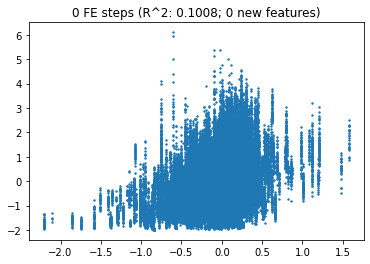

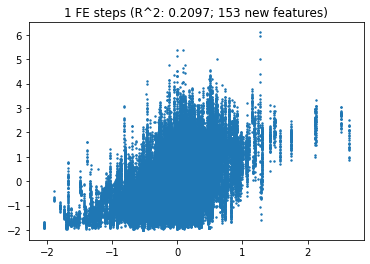

In [0]:
# Automatically generate potential features using the feature training set evaluated against the target
# Only uses feature training data for generation
# Final selection will be done on feature test data

for steps in range(2):
    np.random.seed(55)
    print("### AutoFeat with %i feateng_steps" % steps)
    afreg = AutoFeatRegressor(verbose=1, feateng_steps=steps)
    X_feat_train_gen = afreg.fit_transform(X_feat_train, y_feat_train.values.ravel())
    r2 = afreg.score(X_feat_train, y_feat_train.values.ravel())
    print("## Final R^2: %.4f" % r2)
    plt.figure()
    plt.scatter(afreg.predict(X_feat_train), y_feat_train.values.ravel(), s=2);
    plt.title("%i FE steps (R^2: %.4f; %i new features)" % (steps, r2, len(afreg.new_feat_cols_)))

In [0]:
X_feat_test_gen = afreg.transform(X_feat_test)
X_feat_test_gen.head()


[AutoFeat] Computing 153 new features.
[AutoFeat]   153/  153 new features ...done.


,ALTITUDE,PPN_10TH_MO_BEFORE_HARVESTED,PPN_11TH_MO_BEFORE_HARVESTED,PPN_1ST_MO_BEFORE_HARVESTED,PPN_2ND_MO_BEFORE_HARVESTED,PPN_3RD_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED,PPN_9TH_MO_BEFORE_HARVESTED,PPN_MONTH_OF_HARVESTED,PRECIPITATION_FROM_SOWING_TO_MATURITY,TOTAL_PRECIPIT_IN_12_MONTHS,ALTITUDE PPN_10TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_11TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_1ST_MO_BEFORE_HARVESTED,ALTITUDE PPN_2ND_MO_BEFORE_HARVESTED,ALTITUDE PPN_3RD_MO_BEFORE_HARVESTED,ALTITUDE PPN_4TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_5TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_6TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_7TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_8TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_9TH_MO_BEFORE_HARVESTED,ALTITUDE PPN_MONTH_OF_HARVESTED,ALTITUDE PRECIPITATION_FROM_SOWING_TO_MATURITY,ALTITUDE TOTAL_PRECIPIT_IN_12_MONTHS,ALTITUDE IRRIGATED.YES,PPN_10TH_MO_BEFORE_HARVESTED PPN_11TH_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_1ST_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_2ND_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_3RD_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_4TH_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_5TH_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_6TH_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_7TH_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_8TH_MO_BEFORE_HARVESTED,PPN_10TH_MO_BEFORE_HARVESTED PPN_9TH_MO_BEFORE_HARVESTED,...,PPN_5TH_MO_BEFORE_HARVESTEDPRECIPITATION_FROM_SOWING_TO_MATURITY**2,PPN_1ST_MO_BEFORE_HARVESTEDPRECIPITATION_FROM_SOWING_TO_MATURITY**2,PPN_6TH_MO_BEFORE_HARVESTEDPRECIPITATION_FROM_SOWING_TO_MATURITY**3,Abs(PPN_8TH_MO_BEFORE_HARVESTEDPRECIPITATION_FROM_SOWING_TO_MATURITY),Abs(PPN_9TH_MO_BEFORE_HARVESTEDPRECIPITATION_FROM_SOWING_TO_MATURITY),Abs(PPN_4TH_MO_BEFORE_HARVESTEDPRECIPITATION_FROM_SOWING_TO_MATURITY),1/ALTITUDEPPN_2ND_MO_BEFORE_HARVESTED,1/ALTITUDEPRECIPITATION_FROM_SOWING_TO_MATURITY,PPN_2ND_MO_BEFORE_HARVESTEDPPN_MONTH_OF_HARVESTED**2,1/PPN_10TH_MO_BEFORE_HARVESTEDPPN_9TH_MO_BEFORE_HARVESTED,1/PPN_10TH_MO_BEFORE_HARVESTEDPPN_7TH_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTEDPPN_7TH_MO_BEFORE_HARVESTED**2,PPN_1ST_MO_BEFORE_HARVESTEDPPN_9TH_MO_BEFORE_HARVESTED**2,PPN_10TH_MO_BEFORE_HARVESTEDPPN_3RD_MO_BEFORE_HARVESTED**3,PPN_10TH_MO_BEFORE_HARVESTEDPPN_2ND_MO_BEFORE_HARVESTED**3,Abs(PPN_10TH_MO_BEFORE_HARVESTEDPPN_4TH_MO_BEFORE_HARVESTED),Abs(PPN_7TH_MO_BEFORE_HARVESTEDIRRIGATEDYES),1/PPN_4TH_MO_BEFORE_HARVESTEDPPN_MONTH_OF_HARVESTED,1/PPN_1ST_MO_BEFORE_HARVESTEDPPN_6TH_MO_BEFORE_HARVESTED,1/PPN_6TH_MO_BEFORE_HARVESTEDPRECIPITATION_FROM_SOWING_TO_MATURITY,1/PPN_11TH_MO_BEFORE_HARVESTEDPRECIPITATION_FROM_SOWING_TO_MATURITY,1/PPN_10TH_MO_BEFORE_HARVESTEDPRECIPITATION_FROM_SOWING_TO_MATURITY,1/ALTITUDEPPN_8TH_MO_BEFORE_HARVESTED,1/PPN_8TH_MO_BEFORE_HARVESTEDIRRIGATEDYES,1/PPN_5TH_MO_BEFORE_HARVESTEDPPN_MONTH_OF_HARVESTED,1/PPN_6TH_MO_BEFORE_HARVESTEDPPN_MONTH_OF_HARVESTED,exp(PRECIPITATION_FROM_SOWING_TO_MATURITYIRRIGATEDYES),Abs(PRECIPITATION_FROM_SOWING_TO_MATURITYIRRIGATEDYES),1/PPN_10TH_MO_BEFORE_HARVESTEDPPN_8TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTEDPPN_7TH_MO_BEFORE_HARVESTED**2,PPN_10TH_MO_BEFORE_HARVESTEDPPN_4TH_MO_BEFORE_HARVESTED**3,Abs(PPN_11TH_MO_BEFORE_HARVESTEDPPN_2ND_MO_BEFORE_HARVESTED),1/PPN_2ND_MO_BEFORE_HARVESTEDPRECIPITATION_FROM_SOWING_TO_MATURITY,exp(ALTITUDEPPN_MONTH_OF_HARVESTED),ALTITUDEPPN_3RD_MO_BEFORE_HARVESTED**2,1/PPN_7TH_MO_BEFORE_HARVESTEDIRRIGATEDYES,PPN_6TH_MO_BEFORE_HARVESTEDIRRIGATEDYES**3,Abs(PPN_6TH_MO_BEFORE_HARVESTEDIRRIGATEDYES),1/PPN_10TH_MO_BEFORE_HARVESTEDPPN_11TH_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTEDPRECIPITATION_FROM_SOWING_TO_MATURITY**2
0,-0.3460,0.0672,1.4983,0.3188,0.2296,-0.0042,0.5682,0.0404,0.1155,0.3805,0.7311,1.1442,1.3212,0.2447,-0.6571,-0.2113,0.0854,-0.1541,-0.2015,-0.2772,-0.1760,-0.2192,-0.1993,-0.1421,-0.0591,0.0976,0.1317,-0.1603,-0.3916

### Feature Selector from MLXtend

http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/

From Example 3


In [0]:
#https://hub.packtpub.com/4-ways-implement-feature-selection-python-machine-learning/


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


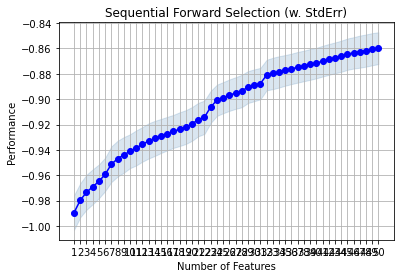

Total runtime was (s): 2960.0818581581116


In [0]:
# Evaluate potential features and select best predictors using feature test set

from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import time

start = time.time()

lr = LinearRegression()

sfs = SFS(lr, 
          k_features=50, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=15)

sfs = sfs.fit(X_feat_test_gen, y_feat_test)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

print('Total runtime was (s): {}'.format(time.time() - start))

# Last runtime with 30 features: 1153 seconds

In [0]:
features = list(sfs.k_feature_names_)
features

['ALTITUDE',
 'PPN_4TH_MO_BEFORE_HARVESTED',
 'PPN_5TH_MO_BEFORE_HARVESTED',
 'ALTITUDE PPN_11TH_MO_BEFORE_HARVESTED',
 'ALTITUDE PPN_3RD_MO_BEFORE_HARVESTED',
 'ALTITUDE IRRIGATED.YES',
 'PPN_10TH_MO_BEFORE_HARVESTED PPN_3RD_MO_BEFORE_HARVESTED',
 'PPN_11TH_MO_BEFORE_HARVESTED PPN_8TH_MO_BEFORE_HARVESTED',
 'PPN_1ST_MO_BEFORE_HARVESTED TOTAL_PRECIPIT_IN_12_MONTHS',
 'PPN_2ND_MO_BEFORE_HARVESTED IRRIGATED.YES',
 'PPN_3RD_MO_BEFORE_HARVESTED PPN_9TH_MO_BEFORE_HARVESTED',
 'PPN_3RD_MO_BEFORE_HARVESTED PPN_MONTH_OF_HARVESTED',
 'PPN_3RD_MO_BEFORE_HARVESTED TOTAL_PRECIPIT_IN_12_MONTHS',
 'PPN_3RD_MO_BEFORE_HARVESTED IRRIGATED.YES',
 'PPN_4TH_MO_BEFORE_HARVESTED IRRIGATED.YES',
 'PPN_6TH_MO_BEFORE_HARVESTED PPN_7TH_MO_BEFORE_HARVESTED',
 'PPN_6TH_MO_BEFORE_HARVESTED TOTAL_PRECIPIT_IN_12_MONTHS',
 'PPN_6TH_MO_BEFORE_HARVESTED IRRIGATED.YES',
 'PRECIPITATION_FROM_SOWING_TO_MATURITY IRRIGATED.YES',
 'TOTAL_PRECIPIT_IN_12_MONTHS IRRIGATED.YES',
 'IRRIGATED.YES',
 'ALTITUDEIRRIGATEDYES**3',
 'Ab

In [0]:
# Transform training set for hyperparameter tuning using afreg
# Select features using optimal feature set of feature selection
# This training set is paired with y_train_scaled 

X_train_model = afreg.transform(X_train_scaled)
X_train_model = X_train_model[features]

# The parameter tuning is evaluated against the X_test_scaled and y_test_scaled data
X_test_model = afreg.transform(X_test_scaled)
X_test_model = X_test_model[features]

[AutoFeat] Computing 153 new features.
[AutoFeat]   153/  153 new features ...done.
[AutoFeat] Computing 153 new features.
[AutoFeat]   153/  153 new features ...done.


In [0]:
y_train_model = y_train_scaled
y_test_model = y_test_scaled

In [0]:
X_train_model.to_pickle('X_train_model.pkl')
X_test_model.to_pickle('X_test_model.pkl')
y_train_model.to_pickle('y_train_model.pkl')
y_test_model.to_pickle('y_test_model.pkl')

In [0]:
# Alternative data set without feature engineering or selection
X_train_model = X_train_scaled
X_test_model = X_test_scaled
y_train_model = y_train_scaled
y_test_model = y_test_scaled

In [0]:
# Exhaustive Feature Selection (Takes too long)
# from sklearn.linear_model import LinearRegression
# from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
# import time

# start = time.time()

# lr = LinearRegression()

# efs = EFS(lr, 
#           min_features=5,
#           max_features=17,
#           scoring='neg_mean_squared_error',
#           cv=3)

# efs.fit(X_train, y_train)

# print('Best MSE score: %.2f' % efs.best_score_ * (-1))
# print('Best subset:', efs.best_idx_)

# print('Total runtime was (s): {}'.format(time.time() - start))

In [0]:
# https://pypi.org/project/autofeat/#data
# https://github.com/cod3licious/autofeat/blob/master/autofeat_examples.ipynb

## GridSearchCV for Regularized Regression

https://alfurka.github.io/2018-11-18-grid-search/

https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb#scrollTo=OcK-JlX-ZCLo

In [0]:
# Import model data objects, in case you want to skip the processing steps above
X_train_model = pd.read_pickle('X_train_scaled_GID.pkl')
X_test_model = pd.read_pickle('X_test_scaled_GID.pkl')
y_train_model = pd.read_pickle('y_train_scaled.pkl')
y_test_model = pd.read_pickle('y_test_scaled.pkl')

In [0]:
X_train_model.head()

,ALTITUDE,PPN_10TH_MO_BEFORE_HARVESTED,PPN_11TH_MO_BEFORE_HARVESTED,PPN_1ST_MO_BEFORE_HARVESTED,PPN_2ND_MO_BEFORE_HARVESTED,PPN_3RD_MO_BEFORE_HARVESTED,PPN_4TH_MO_BEFORE_HARVESTED,PPN_5TH_MO_BEFORE_HARVESTED,PPN_6TH_MO_BEFORE_HARVESTED,PPN_7TH_MO_BEFORE_HARVESTED,PPN_8TH_MO_BEFORE_HARVESTED,PPN_9TH_MO_BEFORE_HARVESTED,PPN_MONTH_OF_HARVESTED,PRECIPITATION_FROM_SOWING_TO_MATURITY,TOTAL_PRECIPIT_IN_12_MONTHS,LENGTH_OF_ROWS_SOWN,SPACE_BTN_ROWS_SOWN,NO_OF_ROWS_SOWN,LENGTH_OF_ROWS_HARVESTED,NO_OF_ROWS_HARVESTED,IRRIGATED_YES,SOIL_ALUMINIUM_TOXICITY_YES,OTHER_MICRONUTRIENT_TOXICITY/DEFICIENCY_Y/N_YES,BIRD_DAMAGE_MODERATE,BIRD_DAMAGE_SEVERE,BIRD_DAMAGE_SLIGHT,BIRD_DAMAGE_TRACES,CROP_STAND_OR_DENSITY_DENSE,CROP_STAND_OR_DENSITY_SPARSE,WEED_PROBLEM_MODERATE,WEED_PROBLEM_SEVERE,WEED_PROBLEM_SLIGHT,WEED_PROBLEM_TRACES,INSECT_DAMAGE_MODERATE,INSECT_DAMAGE_SEVERE,INSECT_DAMAGE_SLIGHT,INSECT_DAMAGE_TRACES,FERTILIZER_APPLIED_YES,FOLIAR_DISEASE_DEVELOPMENT_MODERATE,FOLIAR_DISEASE_DEVELOPMENT_SEVERE,...,897039,897095,89762,900613,902339,904516,909641,909658,909857,915212,916362,916978,92207,934019,96413,96458,96482,96495,96501,965756,96619,96638,96678,97120,97127,97137,97474,97487,97585,980127,980979,981739,981878,981881,984151,990711,991203,991208,991388,991401
Unique_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36ESWYT_20027_560623_14,0.4596,0.1307,0.7488,-0.2915,-0.4097,0.1188,-0.7607,-0.3837,-0.2804,-0.2538,-0.2678,-0.4279,0.5857,-0.1504,-0.7227,0.6648,-0.4400,0.0005,0.2409,-0.4613,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.1176,0.0652,0.1355,0.0748,0.0505,0.0943,0.1531,0.1531,0.0197,0.0070,0.1080,0.1066,0.2551,0.0844,0.1347,0.1197,0.1697,0.0390,0.1391,0.2626,0.2551,0.1974,0.1459,0.0872,0.1398,0.2582,0.1030,0.2140,0.0741,0.0987,0.0168,0.0255,0.0168,0.0168,0.1605,7.7709e-03,0.0165,0.0168,0.0169,0.0168
17ESWYT_65001_48579_21,-0.7215,-0.5871,-0.5831,-0.6056,-0.1609,-0.2258,-0.4552,0.2601,0.0985,0.2827,-0.4056,0.0133,-0.0315,0.0388,-0.0465,-0.8882,0.3175,0.0005,-0.9749,-0.4613,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.1102,0.0711,0.1457,0.0540,0.0688,0.0556,0.4062,0.4062,0.0044,0.0162,0.1106,0.0555,0.3007,0.0675,0.2599,0.1461,0.1189,0.2986,0.0575,0.0996,0.3007,0.5416,0.1503,0.1490,0.1504,0.2090,0.0724,0.1100,0.1596,0.2708,0.0260,0.0222,0.0260,0.0260,0.4790,9.9623e-03,0.0254,0.0260,0.0261,0.0260
37ESWYT_22210_562707_52,-0.4350,-0.7303,-0.0143,-0.8980,-0.7663,-0.7919,-0.6441,0.0725,-0.0735,0.7313,-0.0368,-0.4306,-0.2530,-0.4997,-0.7128,0.6648,-0.4400,0.0005,1.0515,0.7425,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0999,0.0524,0.1188,0.0607,0.0424,0.0741,0.1420,0.1420,0.0269,0.0107,0.1016,0.1038,0.2402,0.0574,0.0946,0.1160,0.1343,0.0356,0.1123,0.2054,0.2402,0.1771,0.1402,0.0726,0.1227,0.1629,0.0845,0.1718,0.0664,0.0885,0.0119,0.0212,0.0119,0.0119,0.1388,7.2763e-03,0.0116,0.0119,0.0120,0.0119
2SAWYT_53002_20593_321,3.3553,-0.9354,-1.0305,-0.4460,0.1022,0.2070,1.1518,0.6727,-0.8126,-0.9408,-0.9734,-0.8506,-0.7953,-0.0734,0.0030,-0.5776,0.8225,0.0005,-0.9749,-0.4613,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.1708,0.0421,0.0418,0.2249,0.0144,0.0303,0.0401,0.0401,0.0016,0.1839,0.1710,0.0345,0.0862,0.0362,0.0241,0.0418,0.1713,0.0303,0.1496,0.0447,0.0862,0.0534,0.0431,0.0291,0.0431,0.0624,0.0595,0.0760,0.0986,0.0267,0.0044,0.0149,0.0044,0.0044,0.0405,2.4921e-03,0.0043,0.0044,0.0044,0.0044
21ESWYT_20409_122467_76,-0.7108,-0.4634,-0.6079,0.3375,0.1689,-0.3993,0.3492,0.2036,-0.1739,-0.0751,-0.0354,-0.1890,-0.1602,0.1401,-0.5399,-1.1988,0.1912,-0.0992,-1.3802,-1.0632,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0117,0.0081,0.0126,0.0082,0.0099,0.0078,0.0142,0.0142,0.5883,0.0001,0.0118,0.6204,0.0259,0.0102,0.0131,0.0126,0.0136,0.0638,0.0113,0.0144,0.0259,0.0189,0.0130,0.0125,0.0130,0.0202,0.1323,0.0182,0.0684,0.

In [0]:
df = pd.DataFrame([['Train', 'OLS'], ['Train', 'Ridge'], ['Train', 'LASSO'],
                    ['Test', 'OLS'], ['Test', 'Ridge'], ['Test', 'LASSO']],
                   columns=['Train_Test', 'Model']) 

results_grid = pd.DataFrame(index = pd.MultiIndex.from_frame(df), columns=['R_2','Adj_R_2','RMSE','MAE'])

In [0]:
results_grid

R_2 Adj_R_2 RMSE  MAE
Train_Test Model                       
Train      OLS    NaN     NaN  NaN  NaN
           Ridge  NaN     NaN  NaN  NaN
           LASSO  NaN     NaN  NaN  NaN
Test       OLS    NaN     NaN  NaN  NaN
           Ridge  NaN     NaN  NaN  NaN
           LASSO  NaN     NaN  NaN  NaN

In [0]:
from sklearn.model_selection import GridSearchCV
import sklearn.linear_model
from sklearn import metrics

ols_regressor = sklearn.linear_model.LinearRegression()

In [0]:
ols_train_pred = ols_regressor.fit(X_train_model, y_train_model).predict(X_train_model)

results_grid.loc['Train','OLS']['R_2'] = metrics.r2_score(y_train_model, ols_train_pred)
results_grid.loc['Train','OLS']['Adj_R_2'] = 1-(1-results_grid.loc['Train','OLS']['R_2'])*(y_train_model.shape[0]-1)/(y_train_model.shape[0]-X_train_model.shape[1]-1)
results_grid.loc['Train','OLS']['RMSE'] = np.sqrt(metrics.mean_squared_error(y_train_model, ols_train_pred))
results_grid.loc['Train','OLS']['MAE'] = metrics.mean_absolute_error(y_train_model, ols_train_pred)

ols_test_pred = ols_regressor.fit(X_train_model, y_train_model).predict(X_test_model)

results_grid.loc['Test','OLS']['R_2'] = metrics.r2_score(y_test_model, ols_test_pred)
results_grid.loc['Test','OLS']['Adj_R_2'] = 1-(1-results_grid.loc['Test','OLS']['R_2'])*(y_train_model.shape[0]-1)/(y_train_model.shape[0]-X_train_model.shape[1]-1)
results_grid.loc['Test','OLS']['RMSE'] = np.sqrt(metrics.mean_squared_error(y_test_model, ols_test_pred))
results_grid.loc['Test','OLS']['MAE'] = metrics.mean_absolute_error(y_test_model, ols_test_pred)

results_grid

R_2    Adj_R_2       RMSE        MAE
Train_Test Model                                            
Train      OLS       0.1974      0.166     0.8959     0.7062
           Ridge        NaN        NaN        NaN        NaN
           LASSO        NaN        NaN        NaN        NaN
Test       OLS   -3.749e+17 -3.895e+17  6.123e+08  7.696e+06
           Ridge        NaN        NaN        NaN        NaN
           LASSO        NaN        NaN        NaN        NaN

In [0]:
lasso = sklearn.linear_model.Lasso(selection = 'random')

parameters = {'alpha' : [0.001, 0.01, 0.1, 1, 5], 'tol' : [0.01, 0.1, 1], 'max_iter' : [50, 100, 500, 1000]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv = 5)


In [0]:
lasso_fitted = lasso_regressor.fit(X_train_model, y_train_model)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16288.173617243241, tolerance: 745.2443390959041
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14346.884385169193, tolerance: 744.7318173817863
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15447.126177909027, tolerance: 745.8644360734655
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15488.341

In [0]:
lasso_train_pred = lasso_fitted.predict(X_train_model)

results_grid.loc['Train','LASSO']['R_2'] = metrics.r2_score(y_train_model, lasso_train_pred)
results_grid.loc['Train','LASSO']['Adj_R_2'] = 1-(1-results_grid.loc['Train','LASSO']['R_2'])*(y_train_model.shape[0]-1)/(y_train_model.shape[0]-X_train_model.shape[1]-1)
results_grid.loc['Train','LASSO']['RMSE'] = np.sqrt(metrics.mean_squared_error(y_train_model, lasso_train_pred))
results_grid.loc['Train','LASSO']['MAE'] = metrics.mean_absolute_error(y_train_model, lasso_train_pred)

lasso_test_pred = lasso_fitted.predict(X_test_model)

results_grid.loc['Test','LASSO']['R_2'] = metrics.r2_score(y_test_model, lasso_test_pred)
results_grid.loc['Test','LASSO']['Adj_R_2'] = 1-(1-results_grid.loc['Test','LASSO']['R_2'])*(y_train_model.shape[0]-1)/(y_train_model.shape[0]-X_train_model.shape[1]-1)
results_grid.loc['Test','LASSO']['RMSE'] = np.sqrt(metrics.mean_squared_error(y_test_model, lasso_test_pred))
results_grid.loc['Test','LASSO']['MAE'] = metrics.mean_absolute_error(y_test_model, lasso_test_pred)

results_grid

R_2 Adj_R_2    RMSE     MAE
Train_Test Model                                
Train      OLS      0.31  0.3073  0.8307  0.6489
           Ridge     NaN     NaN     NaN     NaN
           LASSO   0.259  0.2561  0.8608  0.6749
Test       OLS    0.2909  0.2881  0.8421  0.6569
           Ridge     NaN     NaN     NaN     NaN
           LASSO  0.2438  0.2409  0.8696  0.6823

In [0]:
ridge = sklearn.linear_model.Ridge()

parameters = {'alpha' : [.001, 0.01, 0.1, 0.5, 1, 1.5, 5]}

ridge_regressor = GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv = 5)

ridge_fitted = ridge_regressor.fit(X_train_model, y_train_model)

KeyboardInterrupt: ignored

In [0]:
ridge_train_pred = ridge_fitted.predict(X_train_model)

results_grid.loc['Train','Ridge']['R_2'] = metrics.r2_score(y_train_model, ridge_train_pred)
results_grid.loc['Train','Ridge']['Adj_R_2'] = 1-(1-results_grid.loc['Train','Ridge']['R_2'])*(y_train_model.shape[0]-1)/(y_train_model.shape[0]-X_train_model.shape[1]-1)
results_grid.loc['Train','Ridge']['RMSE'] = np.sqrt(metrics.mean_squared_error(y_train_model, ridge_train_pred))
results_grid.loc['Train','Ridge']['MAE'] = metrics.mean_absolute_error(y_train_model, ridge_train_pred)

ridge_test_pred = ridge_fitted.predict(X_test_model)

results_grid.loc['Test','Ridge']['R_2'] = metrics.r2_score(y_test_model, ridge_test_pred)
results_grid.loc['Test','Ridge']['Adj_R_2'] = 1-(1-results_grid.loc['Test','Ridge']['R_2'])*(y_train_model.shape[0]-1)/(y_train_model.shape[0]-X_train_model.shape[1]-1)

results_grid.loc['Test','Ridge']['RMSE'] = np.sqrt(metrics.mean_squared_error(y_test_model, ridge_test_pred))
results_grid.loc['Test','Ridge']['MAE'] = metrics.mean_absolute_error(y_test_model, ridge_test_pred)

results_grid

In [0]:
# Residuals Plot

## More advanced options for regression comparison

Pipelines and Iterative Gridsearch

In [0]:
# Create a pipeline
# pipe = Pipeline([("classifier", RandomForestClassifier())])
# # Create dictionary with candidate learning algorithms and their hyperparameters
# search_space = [
#                 {"classifier": [LogisticRegression()],
#                  "classifier__penalty": ['l2','l1'],
#                  "classifier__C": np.logspace(0, 4, 10)
#                  },
#                 {"classifier": [LogisticRegression()],
#                  "classifier__penalty": ['l2'],
#                  "classifier__C": np.logspace(0, 4, 10),
#                  "classifier__solver":['newton-cg','saga','sag','liblinear'] ##This solvers don't allow L1 penalty
#                  },
#                 {"classifier": [RandomForestClassifier()],
#                  "classifier__n_estimators": [10, 100, 1000],
#                  "classifier__max_depth":[5,8,15,25,30,None],
#                  "classifier__min_samples_leaf":[1,2,5,10,15,100],
#                  "classifier__max_leaf_nodes": [2, 5,10]}]
# # create a gridsearch of the pipeline, the fit the best model
# gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0,n_jobs=-1) # Fit grid search
# best_model = gridsearch.fit(features, target)

In [0]:
# from sklearn import metrics
# from sklearn import linear_model
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.model_selection import GridSearchCV, train_test_split

# def test(models, X, Y, iterations = 100):
#     results = pd.DataFrame(columns=[list(models.keys())])
#     for i in models:
#         result_iter = pd.DataFrame(columns=['Parameters','Train_R_2','Train_RMSE','Train_MAE', 'Test_R_2','Test_RMSE','Test_MAE'])
#         for j in range(iterations):
#             X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2)
#             train_pred = models[i].fit(X_train, y_train).predict(X_train)
#             result_iter.loc[j,'Train_R_2'] = (metrics.r2_score(y_train, train_pred))
# #            result_iter.loc[j,'Train_RMSE'] = (np.sqrt(metrics.mean_squared_error(y_train, train_pred)))
# #            result_iter.loc[j,'Train_MAE'] = (metrics.mean_absolute_error(y_train, train_pred))

#             test_pred = models[i].fit(X_train, y_train).predict(X_test)
#             result_iter.loc[j,'Test_R_2'] = (metrics.r2_score(y_test, test_pred))
# #            result_iter.loc[j,'Test_RMSE'] = (np.sqrt(metrics.mean_squared_error(y_test, test_pred)))
# #            result_iter.loc[j,'Test_MAE'] = (metrics.mean_absolute_error(y_test, test_pred))

#         # results.loc[i,:] = [np.mean(result_iter['Train_R_2']), np.mean(result_iter['Train_RMSE']), np.mean(result_iter['Train_MAE']),
#         #               np.mean(result_iter['Test_R_2']), np.mean(result_iter['Test_RMSE']), np.mean(result_iter['Test_MAE'])]
#           results.
#     return pd.DataFrame(results)

In [0]:
# models = {'OLS': linear_model.LinearRegression(),
#          'Lasso': linear_model.Lasso(),
#          'Ridge': linear_model.Ridge()}

In [0]:
# start = time.time()
# results = test(models, X=X_train_model[features], Y=y_train_model)
# print('Total runtime was (s): {}'.format(time.time() - start))

Total runtime was (s): 28.472332000732422


In [0]:
# results

,Train_R_2,Train_RMSE,Train_MAE,Test_R_2,Test_RMSE,Test_MAE
OLS,0.06207,0.9686,0.7671,0.06203,0.968,0.7667
Lasso,0.002589,0.9988,0.793,0.002388,0.9986,0.7928
Ridge,0.06218,0.9683,0.7668,0.06162,0.9692,0.7675


In [0]:
# lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
# ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

# models2 = {'OLS': linear_model.LinearRegression(),
#            'Lasso': GridSearchCV(linear_model.Lasso(), 
#                                param_grid=lasso_params).fit(X_train_scaled, y_train_scaled),
#            'Ridge': GridSearchCV(linear_model.Ridge(), 
#                                param_grid=ridge_params).fit(X_train_scaled, y_train_scaled)}

In [0]:
# Lasso = GridSearchCV(linear_model.Lasso(), param_grid=lasso_params).fit(X_train_scaled, y_train_scaled)

In [0]:
# start = time.time()

# results_grid = test(models2, X=X_train_gen[features], Y=y_train_scaled)

# print('Total runtime was (s): {}'.format(time.time() - start))

Total runtime was (s): 30.61686110496521


In [0]:
# results_grid

,Train_R_2,Train_RMSE,Train_MAE,Test_R_2,Test_RMSE,Test_MAE
OLS,0.06222,0.9685,0.767,0.06145,0.9683,0.7667
Lasso,0.0495,0.975,0.7728,0.04911,0.9747,0.7729
Ridge,0.0621,0.9685,0.767,0.06194,0.9684,0.7669


In [0]:
# How to pull optimal alpha values from gridsearch?
# https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8



## Other Resources

In [0]:
# https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

In [0]:
# Pipelining Tutorial
# https://towardsdatascience.com/hyper-parameter-tuning-and-model-selection-like-a-movie-star-a884b8ee8d68

# Hint: If Medium gives you paywalls, 
# you can usually get around them by opening the window in incognito mode

In [0]:
# Gradient Boosting Regression Example
# https://towardsdatascience.com/a-complete-machine-learning-project-walk-through-in-python-part-two-300f1f8147e2

In [0]:
# Regularized Boosting with XGBoost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [0]:
# Speeding things up with PySpark
# https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/